# Imports

In [1]:
#!pip install tensorflow
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential, Model
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback
from keras import Loss
from keras.saving import custom_object_scope
import seaborn as sns

2025-04-22 10:56:40.805005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745315800.946576    1103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745315800.987077    1103 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 10:56:41.353239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train on single vehicle dynamics

## Constant coefficient car

In [2]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate
        self.x0 = x0
        self.X = np.array(self.x0, dtype=np.float32) #[position, velocity]
        
        self.history = {
            "x": [], "v": [], "u": [], "a_k+1": [], "v_k+1": [], "x_k+1": [],
        }


    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""
        
        self.history['u'].append(u)
        self.history['v'].append(self.X[1])
        self.history['x'].append(self.X[0])

        #backwards/implicit method -> get a_{k+1}
        a_next = self._dynamics(self.X, u)
        self.history["a_k+1"].append(a_next) 

        v_k = self.X[1]
        self.X[1] += a_next*dt #velocity update
        self.X[0] += v_k*dt + 0.5*a_next*dt**2 #position update
        
        self.history["v_k+1"].append(self.X[1]) 
        self.history["x_k+1"].append(self.X[0]) 
        
        return self.X

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x_k, v_k = X
        Fr = (self.c0 + self.c1 * v_k)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v_k**2)/2
        Fg = self.m*g*np.sin(self.road_grade)

        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        #return np.array([v,a])
        return a

    def reset(self, x0):
        del self.history
        self.history = {
            "x": [], "v": [], "u": [], "a_k+1": [], "v_k+1": [], "x_k+1": [],
        }
        self.X = np.array(x0, dtype=np.float32) #[position, velocity]


## Generate synthetic data

   traj_id    t      u     v_meas     v_true    x_meas    x_true  v_true_next  \
0      0.0  0.0  510.0  13.867029  13.888889  0.097047  0.000000    13.888803   
1      0.0  0.1  510.0  13.812484  13.888803  1.471489  1.388885    13.888718   
2      0.0  0.2  510.0  13.811006  13.888718  2.722660  2.777761    13.888632   
3      0.0  0.3  510.0  14.073567  13.888632  4.217592  4.166628    13.888546   
4      0.0  0.4  510.0  13.817986  13.888546  5.532910  5.555487    13.888460   

   x_true_next  a_true_next  a_meas_next  
0     1.388885    -0.000861     0.075673  
1     2.777761    -0.000861     0.195605  
2     4.166628    -0.000860    -0.104635  
3     5.555487    -0.000859    -0.018428  
4     6.944337    -0.000859    -0.117851  


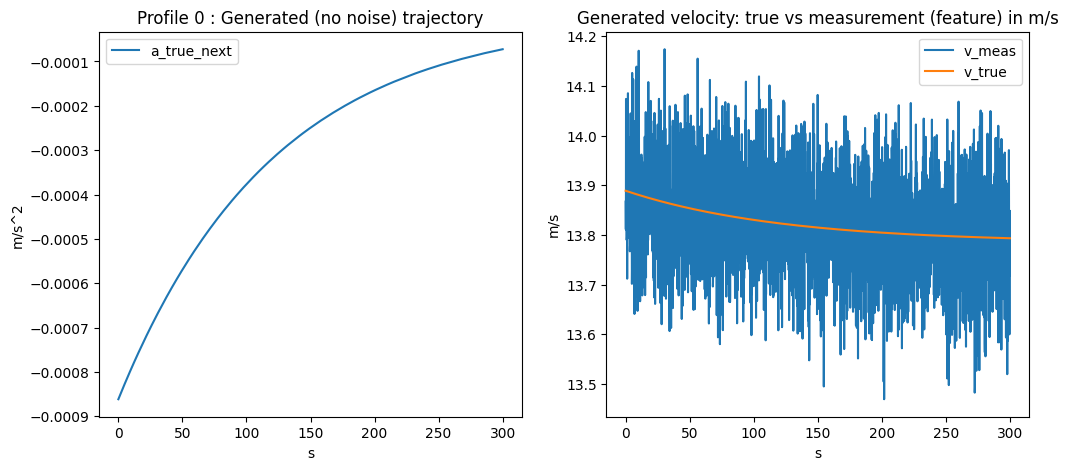

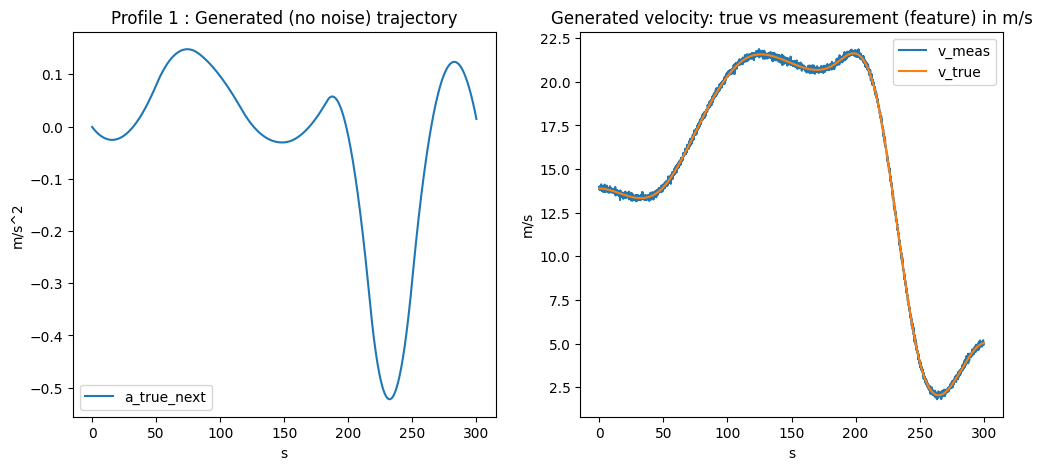

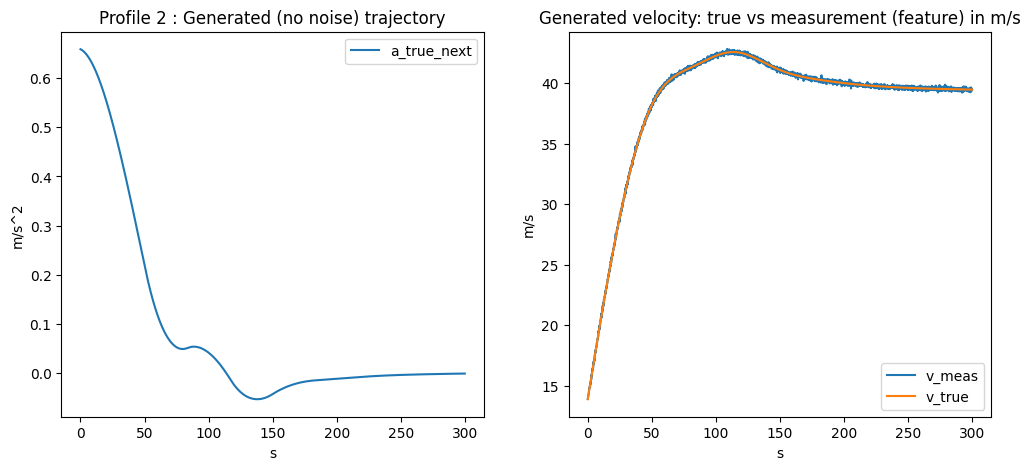

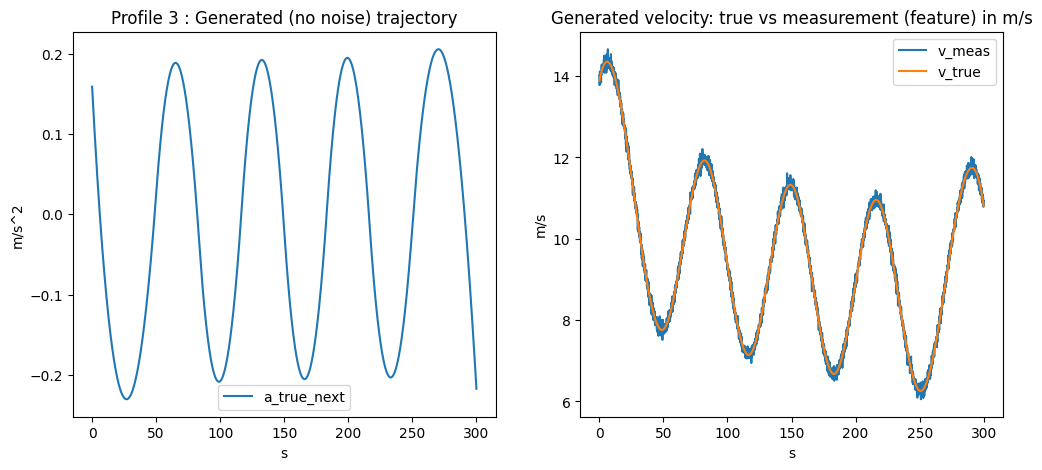

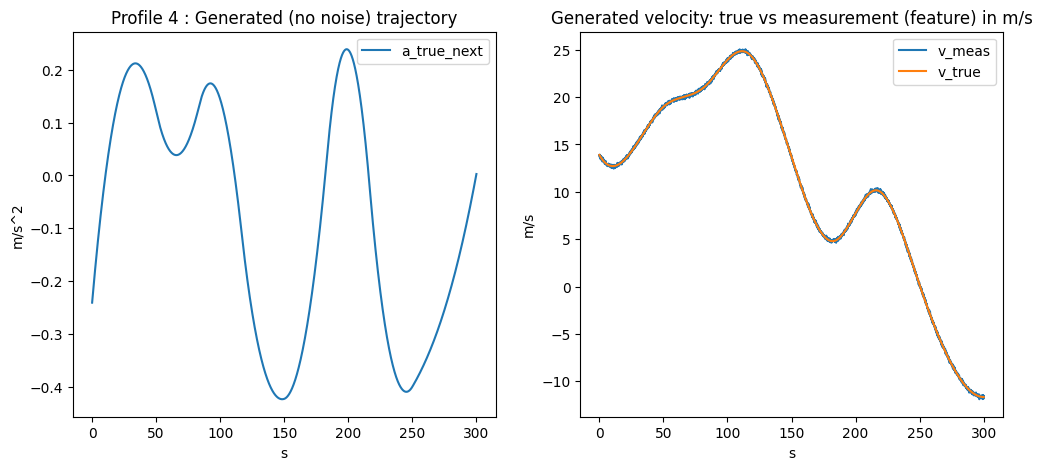

In [3]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
v0 = 50/3.6
x0 = (0, v0) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)
t_samp = np.linspace(0, t_end, 10, dtype=np.float32)
std = 1e-1

#DEFINE U PROFILES
input_profiles = []
input_profiles.append(np.full_like(t_samp, 0.34, dtype=np.float32) * m) #crusing
input_profiles.append(np.array([0.34, 0.34, 0.5, 0.5, 0.4, 0.4, 0.4, -0.2, 0.3, 0.3], dtype=np.float32) * m) #emerg braking
input_profiles.append(np.array([1.0, 1.0, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7], dtype=np.float32) * m) #accelerating
input_profiles.append(np.array([0.5, 0.1]*5, dtype=np.float32) * m) #stop&go/oscillating
np.random.seed(31)
input_profiles.append(np.random.uniform(low=-0.1, high=0.6, size=t_samp.shape).astype(np.float32) * m) #random

input_interp = []
for profile in input_profiles:
    input_interp.append(interp1d(t_samp, profile, kind='quadratic'))

#simulate and build dataframes
def simulate_traj(car, u_func, traj_id, t):
    for t_curr in t:
        car.update(u_func(t_curr), dt)
    data = {
        'traj_id': traj_id,
        't': t,
        'u': car.history["u"],
        'v_meas': np.array(car.history["v"]) + np.random.normal(loc=0, scale=std, size=len(t)),
        'v_true': car.history["v"],
        'x_meas': np.array(car.history["x"]) + np.random.normal(loc=0, scale=std, size=len(t)),
        'x_true': car.history["x"],
        'v_true_next': car.history["v_k+1"],
        'x_true_next': car.history["x_k+1"],
        'a_true_next': car.history["a_k+1"],
        'a_meas_next': car.history["a_k+1"] + np.random.normal(loc=0, scale=std, size=len(t)),
    }

    df = pd.DataFrame(data, dtype=np.float32)
    #label/output is next step acceleration
    return df

dataframes = []
for id, func in enumerate(input_interp):
    dataframe = simulate_traj(car, func, id, t)

    #plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    dataframe.plot(x='t', y="a_true_next", ax=axs[0],
               title="Profile " + str(id) + " : Generated (no noise) trajectory",
               legend=True, ylabel="m/s^2", xlabel="s")
    dataframe.plot(x='t', y=["v_meas","v_true"], ax=axs[1],
               title="Generated velocity: true vs measurement (feature) in m/s",
               legend=True, ylabel="m/s", xlabel="s")

    dataframes.append(dataframe)
    car.reset(x0) #x0 common for all trajectories

dataset = pd.concat(dataframes, axis=0, ignore_index=True)
dataset.to_csv("data/synthetic_5_trajectories.csv", index=False)
print(dataset.head())

## Helper funcs

In [33]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str, meas_data: np.ndarray = None):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''

    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12, 8))
    plt.suptitle(suptitle)

    # Plot for acceleration:
    plt.subplot(1, 3, 1)
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    if meas_data is not None:
        plt.scatter(t, meas_data, label="Measured acceleration points", s=7, c='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Acceleration")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1, 3, 2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()


    plt.subplot(1, 3, 3)
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, es_start_epoch):
    loss = history["loss"]
    val_loss = history["val_loss"]
    best_epoch = es_start_epoch + np.argmin(val_loss[es_start_epoch:]) + 1

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    #add a marker for the early stopping epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Restored')
    plt.text(best_epoch, val_loss[best_epoch - 1], f'({best_epoch}, {val_loss[best_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

def evaluate_results(model, X_norm, true_data, scaler_Y=None):
    v = np.zeros_like(t)
    x = np.zeros_like(t)

    pred_a = model.predict(X_norm)
    if scaler_Y:
        pred_a = scaler_Y.inverse_transform(pred_a)
    v = np.cumsum(pred_a.flatten() * dt)
    v += x0[1]
    x = np.cumsum(v*dt)
    x += x0[0]

    mse_a = mean_squared_error(true_data[:, 0], pred_a)
    mse_v = mean_squared_error(true_data[:, 1], v)
    mse_x = mean_squared_error(true_data[:, 2], x)

    v = v.reshape(-1, 1)
    x = x.reshape(-1, 1)

    pred_data = np.hstack((pred_a, v, x))

    print(f"MSE/RMSE for acceleration: {mse_a:.5e}, {np.sqrt(mse_a):.5e}")
    print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
    print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

    return pred_data

# Prepping data

**for now only using one of the trajectories for training although I had made a tf.dataset that would have shape (traj, N, features) for parallel training. But that would require changing the models architecture as far as I know for now. Stash that**

Number of training points:
(300, 1)


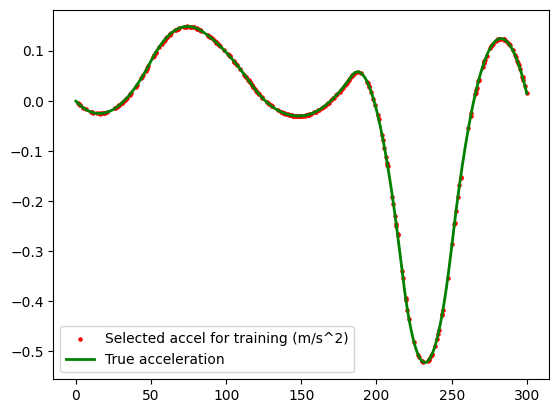

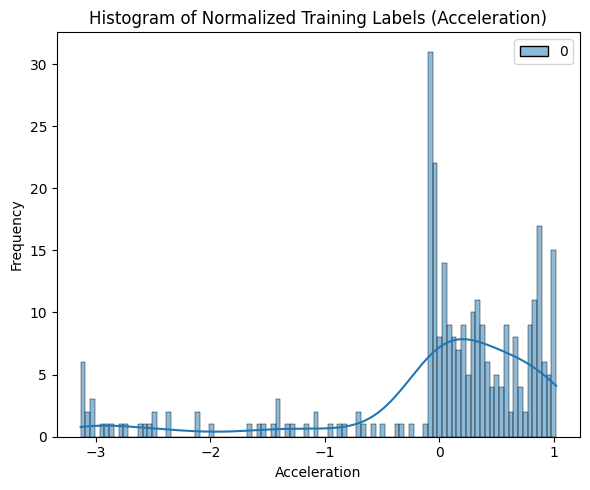

In [38]:
train_ratio = .1 #data sparsity
train_id = 1 #traj id
df_train_traj = dataset[dataset['traj_id'] == train_id]
X = df_train_traj[["t", "u", "v_true", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N

Y_train_traj = df_train_traj[["a_true_next"]].to_numpy()  #NN only predicts a
y0_true = Y_train_traj[0]
Y_train, Y_val, X_train, X_val = train_test_split(Y_train_traj, X, train_size=train_ratio, random_state=31)
print("Number of training points:")
print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_train_traj, Y_train)
Y_mask = Y_train_traj.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_mask, label="Selected accel for training (m/s^2)", s=5, color="red")
plt.plot(t, Y_train_traj, label="True acceleration", linewidth=2, color="green")
plt.legend()
plt.show()

#Prediction Normalization
scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_val_norm = scaler_Y.transform(Y_val)

# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_norm = scaler_X.transform(X)
x0_norm = X_norm[0, :]

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train_norm, bins=100, kde=True, color='orange')
plt.title('Histogram of Normalized Training Labels (Acceleration)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# PUNN-only

Epoch 1/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.1340

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 1.1393 - val_loss: 1.2824 - learning_rate: 1.0000e-04
Epoch 2/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2268

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.2229 - val_loss: 1.1240 - learning_rate: 1.0000e-04
Epoch 3/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1155

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.0189 - val_loss: 1.0243 - learning_rate: 1.0000e-04
Epoch 4/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.2096

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.9213 - val_loss: 0.9512 - learning_rate: 1.0000e-04
Epoch 5/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.5340

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.9456 - val_loss: 0.8848 - learning_rate: 1.0000e-04
Epoch 6/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7835

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.7823 - val_loss: 0.8279 - learning_rate: 1.0000e-04
Epoch 7/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1018

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.7795 - val_loss: 0.7733 - learning_rate: 1.0000e-04
Epoch 8/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6170 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.6195 - val_loss: 0.7236 - learning_rate: 1.0000e-04
Epoch 9/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6341 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.6288 - val_loss: 0.6713 - learning_rate: 1.0000e-04
Epoch 10/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3672

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.5952 - val_loss: 0.6266 - learning_rate: 1.0000e-04
Epoch 11/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4911 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.4977 - val_loss: 0.5846 - learning_rate: 1.0000e-04
Epoch 12/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4943 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.4941 - val_loss: 0.5447 - learning_rate: 1.0000e-04
Epoch 13/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7808

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5417 - val_loss: 0.5085 - learning_rate: 1.0000e-04
Epoch 14/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4238

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4069 - val_loss: 0.4758 - learning_rate: 1.0000e-04
Epoch 15/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4775

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.4138 - val_loss: 0.4415 - learning_rate: 1.0000e-04
Epoch 16/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3343

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4001 - val_loss: 0.4141 - learning_rate: 1.0000e-04
Epoch 17/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.4066

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.3576 - val_loss: 0.3899 - learning_rate: 1.0000e-04
Epoch 18/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3717

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.3168 - val_loss: 0.3650 - learning_rate: 1.0000e-04
Epoch 19/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3498

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3199 - val_loss: 0.3401 - learning_rate: 1.0000e-04
Epoch 20/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2212

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2724 - val_loss: 0.3203 - learning_rate: 1.0000e-04
Epoch 21/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3579

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3045 - val_loss: 0.3011 - learning_rate: 1.0000e-04
Epoch 22/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2393 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2430 - val_loss: 0.2860 - learning_rate: 1.0000e-04
Epoch 23/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2639 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2592 - val_loss: 0.2685 - learning_rate: 1.0000e-04
Epoch 24/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2235 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2240 - val_loss: 0.2548 - learning_rate: 1.0000e-04
Epoch 25/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2324

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2082 - val_loss: 0.2441 - learning_rate: 1.0000e-04
Epoch 26/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2721

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2329 - val_loss: 0.2292 - learning_rate: 1.0000e-04
Epoch 27/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1946 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1936 - val_loss: 0.2204 - learning_rate: 1.0000e-04
Epoch 28/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0645

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1609 - val_loss: 0.2102 - learning_rate: 1.0000e-04
Epoch 29/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1509

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1627 - val_loss: 0.2001 - learning_rate: 1.0000e-04
Epoch 30/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1806

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1635 - val_loss: 0.1925 - learning_rate: 1.0000e-04
Epoch 31/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2172

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1806 - val_loss: 0.1830 - learning_rate: 1.0000e-04
Epoch 32/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1076

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1433 - val_loss: 0.1772 - learning_rate: 1.0000e-04
Epoch 33/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1539

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1492 - val_loss: 0.1690 - learning_rate: 1.0000e-04
Epoch 34/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1240

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1451 - val_loss: 0.1636 - learning_rate: 1.0000e-04
Epoch 35/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0962

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1256 - val_loss: 0.1578 - learning_rate: 1.0000e-04
Epoch 36/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0830

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1204 - val_loss: 0.1504 - learning_rate: 1.0000e-04
Epoch 37/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1610

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1323 - val_loss: 0.1462 - learning_rate: 1.0000e-04
Epoch 38/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1207

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1196 - val_loss: 0.1403 - learning_rate: 1.0000e-04
Epoch 39/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1188

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1136 - val_loss: 0.1357 - learning_rate: 1.0000e-04
Epoch 40/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1133 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1127 - val_loss: 0.1283 - learning_rate: 1.0000e-04
Epoch 41/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0965

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1032 - val_loss: 0.1243 - learning_rate: 1.0000e-04
Epoch 42/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1089 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1083 - val_loss: 0.1185 - learning_rate: 1.0000e-04
Epoch 43/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0809

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - loss: 0.0956 - val_loss: 0.1146 - learning_rate: 1.0000e-04
Epoch 44/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0882 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0895 - val_loss: 0.1094 - learning_rate: 1.0000e-04
Epoch 45/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1273

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0960 - val_loss: 0.1042 - learning_rate: 1.0000e-04
Epoch 46/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1167

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0869 - val_loss: 0.1004 - learning_rate: 1.0000e-04
Epoch 47/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0846

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0844 - val_loss: 0.0947 - learning_rate: 1.0000e-04
Epoch 48/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0739 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0742 - val_loss: 0.0911 - learning_rate: 1.0000e-04
Epoch 49/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0790 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0776 - val_loss: 0.0863 - learning_rate: 1.0000e-04
Epoch 50/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0743 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0733 - val_loss: 0.0825 - learning_rate: 1.0000e-04
Epoch 51/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0722

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0693 - val_loss: 0.0775 - learning_rate: 1.0000e-04
Epoch 52/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0558

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0612 - val_loss: 0.0740 - learning_rate: 1.0000e-04
Epoch 53/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0544

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0601 - val_loss: 0.0697 - learning_rate: 1.0000e-04
Epoch 54/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0537 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0539 - val_loss: 0.0666 - learning_rate: 1.0000e-04
Epoch 55/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0622 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0608 - val_loss: 0.0626 - learning_rate: 1.0000e-04
Epoch 56/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0585 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0579 - val_loss: 0.0594 - learning_rate: 1.0000e-04
Epoch 57/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0381

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0464 - val_loss: 0.0554 - learning_rate: 1.0000e-04
Epoch 58/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0596

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0491 - val_loss: 0.0526 - learning_rate: 1.0000e-04
Epoch 59/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0485 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0470 - val_loss: 0.0493 - learning_rate: 1.0000e-04
Epoch 60/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0624

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0440 - val_loss: 0.0464 - learning_rate: 1.0000e-04
Epoch 61/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0366 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0368 - val_loss: 0.0433 - learning_rate: 1.0000e-04
Epoch 62/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0290

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0376 - val_loss: 0.0409 - learning_rate: 1.0000e-04
Epoch 63/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0380

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0352 - val_loss: 0.0383 - learning_rate: 1.0000e-04
Epoch 64/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0340

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0304 - val_loss: 0.0354 - learning_rate: 1.0000e-04
Epoch 65/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0290

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0289 - val_loss: 0.0329 - learning_rate: 1.0000e-04
Epoch 66/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0228

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0251 - val_loss: 0.0307 - learning_rate: 1.0000e-04
Epoch 67/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0297

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0261 - val_loss: 0.0284 - learning_rate: 1.0000e-04
Epoch 68/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0247

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0231 - val_loss: 0.0266 - learning_rate: 1.0000e-04
Epoch 69/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0219 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0219 - val_loss: 0.0241 - learning_rate: 1.0000e-04
Epoch 70/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0255

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0209 - val_loss: 0.0225 - learning_rate: 1.0000e-04
Epoch 71/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0186 - val_loss: 0.0207 - learning_rate: 1.0000e-04
Epoch 72/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0162 - val_loss: 0.0189 - learning_rate: 1.0000e-04
Epoch 73/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0145 - val_loss: 0.0173 - learning_rate: 1.0000e-04
Epoch 74/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0133 - val_loss: 0.0159 - learning_rate: 1.0000e-04
Epoch 75/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0138 - val_loss: 0.0145 - learning_rate: 1.0000e-04
Epoch 76/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0116 - val_loss: 0.0132 - learning_rate: 1.0000e-04
Epoch 77/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0073

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0093 - val_loss: 0.0120 - learning_rate: 1.0000e-04
Epoch 78/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0096

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0098 - val_loss: 0.0110 - learning_rate: 1.0000e-04
Epoch 79/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0140

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0099 - val_loss: 0.0099 - learning_rate: 1.0000e-04
Epoch 80/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0070

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0084 - val_loss: 0.0090 - learning_rate: 1.0000e-04
Epoch 81/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0066 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 82/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064  

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0064 - val_loss: 0.0074 - learning_rate: 1.0000e-04
Epoch 83/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0059 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 84/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0053

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0055 - val_loss: 0.0061 - learning_rate: 1.0000e-04
Epoch 85/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0047 - val_loss: 0.0055 - learning_rate: 1.0000e-04
Epoch 86/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0043

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0043 - val_loss: 0.0050 - learning_rate: 1.0000e-04
Epoch 87/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0040 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 88/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0039 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 89/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.0032

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0032 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 90/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0028 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 91/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0026 - val_loss: 0.0031 - learning_rate: 1.0000e-04
Epoch 92/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0026 - val_loss: 0.0027 - learning_rate: 1.0000e-04
Epoch 93/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0022 - val_loss: 0.0025 - learning_rate: 1.0000e-04
Epoch 94/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0021 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 95/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0018 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 96/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0019 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 97/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0016 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 98/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0016 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 99/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 100/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0015 - val_loss: 0.0014 - learning_rate: 9.0000e-05
Epoch 101/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0013 - val_loss: 0.0014 - learning_rate: 9.0000e-05
Epoch 102/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0012

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0012 - val_loss: 0.0013 - learning_rate: 9.0000e-05
Epoch 103/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 9.0000e-05
Epoch 104/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0011 - val_loss: 0.0012 - learning_rate: 9.0000e-05
Epoch 105/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3908e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 9.6577e-04 - val_loss: 0.0011 - learning_rate: 9.0000e-05
Epoch 106/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 9.0000e-05
Epoch 107/2000
 5/10 ━━━━━━━━━━━━━━━━━━━━ 3s 740ms/step - loss: 0.0011

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - loss: 0.0011 - val_loss: 0.0010 - learning_rate: 9.0000e-05
Epoch 108/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7697e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 8.8586e-04 - val_loss: 0.0010 - learning_rate: 9.0000e-05
Epoch 109/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.0938e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 9.0574e-04 - val_loss: 0.0010 - learning_rate: 9.0000e-05
Epoch 110/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 9.9753e-04 - val_loss: 9.5751e-04 - learning_rate: 9.0000e-05
Epoch 111/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6916e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 9.5634e-04 - val_loss: 9.4631e-04 - learning_rate: 9.0000e-05
Epoch 112/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.4064e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 8.8944e-04 - val_loss: 9.1253e-04 - learning_rate: 9.0000e-05
Epoch 113/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.9483e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.9251e-04 - val_loss: 9.0285e-04 - learning_rate: 9.0000e-05
Epoch 114/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1614e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 9.1369e-04 - val_loss: 8.9504e-04 - learning_rate: 9.0000e-05
Epoch 115/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4908e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 8.5265e-04 - val_loss: 8.6671e-04 - learning_rate: 9.0000e-05
Epoch 116/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.9855e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 8.5860e-04 - val_loss: 8.5705e-04 - learning_rate: 9.0000e-05
Epoch 117/2000
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.1940e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 8.8586e-04 - val_loss: 8.5004e-04 - learning_rate: 9.0000e-05
Epoch 118/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.9407e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 8.4984e-04 - val_loss: 8.3824e-04 - learning_rate: 9.0000e-05
Epoch 119/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7406e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 8.5941e-04 - val_loss: 8.2433e-04 - learning_rate: 9.0000e-05
Epoch 120/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0981e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 8.1039e-04 - val_loss: 8.1982e-04 - learning_rate: 9.0000e-05
Epoch 121/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 7.8015e-04 - val_loss: 8.3023e-04 - learning_rate: 9.0000e-05
Epoch 122/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.0611e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.1996e-04 - val_loss: 8.0547e-04 - learning_rate: 9.0000e-05
Epoch 123/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.6654e-04 - val_loss: 8.0621e-04 - learning_rate: 9.0000e-05
Epoch 124/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.4394e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 8.2083e-04 - val_loss: 7.9817e-04 - learning_rate: 9.0000e-05
Epoch 125/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4312e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 8.3873e-04 - val_loss: 7.9661e-04 - learning_rate: 9.0000e-05
Epoch 126/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2720e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.3889e-04 - val_loss: 7.9147e-04 - learning_rate: 9.0000e-05
Epoch 127/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.8221e-04 - val_loss: 7.9749e-04 - learning_rate: 9.0000e-05
Epoch 128/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.6108e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.5250e-04 - val_loss: 7.7793e-04 - learning_rate: 9.0000e-05
Epoch 129/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.9710e-04 - val_loss: 7.8281e-04 - learning_rate: 9.0000e-05
Epoch 130/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.7773e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.2225e-04 - val_loss: 7.7292e-04 - learning_rate: 9.0000e-05
Epoch 131/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.5431e-04 - val_loss: 7.7824e-04 - learning_rate: 9.0000e-05
Epoch 132/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.6784e-04 - val_loss: 7.9762e-04 - learning_rate: 9.0000e-05
Epoch 133/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1258e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 8.0515e-04 - val_loss: 7.6516e-04 - learning_rate: 9.0000e-05
Epoch 134/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.8363e-04 - val_loss: 7.9093e-04 - learning_rate: 9.0000e-05
Epoch 135/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3285e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.3633e-04 - val_loss: 7.6178e-04 - learning_rate: 9.0000e-05
Epoch 136/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 7.3572e-04 - val_loss: 7.6525e-04 - learning_rate: 9.0000e-05
Epoch 137/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.5138e-04 - val_loss: 7.6305e-04 - learning_rate: 9.0000e-05
Epoch 138/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.1434e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 8.0293e-04 - val_loss: 7.5412e-04 - learning_rate: 9.0000e-05
Epoch 139/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 8.4226e-04 - val_loss: 7.7764e-04 - learning_rate: 9.0000e-05
Epoch 140/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9892e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.5065e-04 - val_loss: 7.5222e-04 - learning_rate: 9.0000e-05
Epoch 141/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.6011e-04 - val_loss: 7.5801e-04 - learning_rate: 9.0000e-05
Epoch 142/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7212e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 7.7233e-04 - val_loss: 7.4885e-04 - learning_rate: 9.0000e-05
Epoch 143/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 8.2504e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.8329e-04 - val_loss: 7.4771e-04 - learning_rate: 9.0000e-05
Epoch 144/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.7341e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.7155e-04 - val_loss: 7.4678e-04 - learning_rate: 9.0000e-05
Epoch 145/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.0203e-04 - val_loss: 7.6009e-04 - learning_rate: 9.0000e-05
Epoch 146/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7758e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 6.6622e-04 - val_loss: 7.3984e-04 - learning_rate: 9.0000e-05
Epoch 147/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1978e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 7.2357e-04 - val_loss: 7.3799e-04 - learning_rate: 9.0000e-05
Epoch 148/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.3567e-04 - val_loss: 7.6254e-04 - learning_rate: 9.0000e-05
Epoch 149/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 7.4917e-04 - val_loss: 7.3869e-04 - learning_rate: 9.0000e-05
Epoch 150/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.7051e-04 - val_loss: 7.5576e-04 - learning_rate: 9.0000e-05
Epoch 151/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3985e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 7.4293e-04 - val_loss: 7.3456e-04 - learning_rate: 9.0000e-05
Epoch 152/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8215e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.9481e-04 - val_loss: 7.3189e-04 - learning_rate: 9.0000e-05
Epoch 153/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.9586e-04 - val_loss: 7.5091e-04 - learning_rate: 9.0000e-05
Epoch 154/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.8277e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.8943e-04 - val_loss: 7.2759e-04 - learning_rate: 9.0000e-05
Epoch 155/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.5044e-04 - val_loss: 7.7354e-04 - learning_rate: 9.0000e-05
Epoch 156/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 7.9372e-04 - val_loss: 7.3148e-04 - learning_rate: 9.0000e-05
Epoch 157/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.0742e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 8.3007e-04 - val_loss: 7.2361e-04 - learning_rate: 9.0000e-05
Epoch 158/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.6549e-04 - val_loss: 7.6960e-04 - learning_rate: 9.0000e-05
Epoch 159/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.2879e-04 - val_loss: 7.7790e-04 - learning_rate: 9.0000e-05
Epoch 160/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.9813e-04 - val_loss: 7.6614e-04 - learning_rate: 9.0000e-05
Epoch 161/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.7803e-04 - val_loss: 7.3075e-04 - learning_rate: 9.0000e-05
Epoch 162/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.7477e-04 - val_loss: 7.8556e-04 - learning_rate: 9.0000e-05
Epoch 163/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.9415e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 7.5826e-04 - val_loss: 7.1618e-04 - learning_rate: 9.0000e-05
Epoch 164/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.1798e-04 - val_loss: 7.1918e-04 - learning_rate: 9.0000e-05
Epoch 165/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.1553e-04 - val_loss: 7.3357e-04 - learning_rate: 9.0000e-05
Epoch 166/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 7.4080e-04 - val_loss: 7.2939e-04 - learning_rate: 9.0000e-05
Epoch 167/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.5506e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.2090e-04 - val_loss: 7.1244e-04 - learning_rate: 9.0000e-05
Epoch 168/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.1491e-04 - val_loss: 7.1739e-04 - learning_rate: 9.0000e-05
Epoch 169/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.1697e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 7.4564e-04 - val_loss: 7.0585e-04 - learning_rate: 9.0000e-05
Epoch 170/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 7.4288e-04 - val_loss: 7.0858e-04 - learning_rate: 9.0000e-05
Epoch 171/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5942e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 6.7561e-04 - val_loss: 7.0526e-04 - learning_rate: 9.0000e-05
Epoch 172/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - loss: 7.1122e-04 - val_loss: 7.5155e-04 - learning_rate: 9.0000e-05
Epoch 173/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.6038e-04 - val_loss: 7.1052e-04 - learning_rate: 9.0000e-05
Epoch 174/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 7.3173e-04 - val_loss: 7.8084e-04 - learning_rate: 9.0000e-05
Epoch 175/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.8842e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.5623e-04 - val_loss: 7.0212e-04 - learning_rate: 9.0000e-05
Epoch 176/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 7.0530e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.7511e-04 - val_loss: 6.9889e-04 - learning_rate: 9.0000e-05
Epoch 177/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 6.6184e-04 - val_loss: 7.0667e-04 - learning_rate: 9.0000e-05
Epoch 178/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.9981e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 7.1425e-04 - val_loss: 6.9789e-04 - learning_rate: 9.0000e-05
Epoch 179/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1254e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.1480e-04 - val_loss: 6.9169e-04 - learning_rate: 9.0000e-05
Epoch 180/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.2971e-04 - val_loss: 7.3514e-04 - learning_rate: 9.0000e-05
Epoch 181/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 6.9605e-04 - val_loss: 6.9554e-04 - learning_rate: 9.0000e-05
Epoch 182/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.4009e-04 - val_loss: 7.1285e-04 - learning_rate: 9.0000e-05
Epoch 183/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 6.5381e-04 - val_loss: 6.9201e-04 - learning_rate: 9.0000e-05
Epoch 184/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 7.5926e-04 - val_loss: 6.9584e-04 - learning_rate: 9.0000e-05
Epoch 185/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 6.7896e-04 - val_loss: 7.1782e-04 - learning_rate: 9.0000e-05
Epoch 186/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.7731e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.5203e-04 - val_loss: 6.7907e-04 - learning_rate: 9.0000e-05
Epoch 187/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.1637e-04 - val_loss: 7.8026e-04 - learning_rate: 9.0000e-05
Epoch 188/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 6.9401e-04 - val_loss: 6.8207e-04 - learning_rate: 9.0000e-05
Epoch 189/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.4385e-04 - val_loss: 6.8126e-04 - learning_rate: 9.0000e-05
Epoch 190/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.7394e-04 - val_loss: 7.1882e-04 - learning_rate: 9.0000e-05
Epoch 191/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 6.7388e-04 - val_loss: 6.8102e-04 - learning_rate: 9.0000e-05
Epoch 192/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 7.8270e-04 - val_loss: 6.8526e-04 - learning_rate: 9.0000e-05
Epoch 193/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8374e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 7.5251e-04 - val_loss: 6.6876e-04 - learning_rate: 9.0000e-05
Epoch 194/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 7.1082e-04 - val_loss: 6.7168e-04 - learning_rate: 9.0000e-05
Epoch 195/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.1969e-04 - val_loss: 6.7196e-04 - learning_rate: 9.0000e-05
Epoch 196/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.2824e-04 - val_loss: 7.0870e-04 - learning_rate: 9.0000e-05
Epoch 197/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.1823e-04 - val_loss: 6.7587e-04 - learning_rate: 9.0000e-05
Epoch 198/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.4691e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.9157e-04 - val_loss: 6.6674e-04 - learning_rate: 9.0000e-05
Epoch 199/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.8009e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.9939e-04 - val_loss: 6.6408e-04 - learning_rate: 9.0000e-05
Epoch 200/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.3307e-04 - val_loss: 6.8040e-04 - learning_rate: 8.1000e-05
Epoch 201/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.6069e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.6774e-04 - val_loss: 6.6030e-04 - learning_rate: 8.1000e-05
Epoch 202/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.3580e-04 - val_loss: 7.1900e-04 - learning_rate: 8.1000e-05
Epoch 203/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.5558e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.9016e-04 - val_loss: 6.5844e-04 - learning_rate: 8.1000e-05
Epoch 204/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.5529e-04 - val_loss: 6.8249e-04 - learning_rate: 8.1000e-05
Epoch 205/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.0592e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.9538e-04 - val_loss: 6.5672e-04 - learning_rate: 8.1000e-05
Epoch 206/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.4130e-04 - val_loss: 6.6470e-04 - learning_rate: 8.1000e-05
Epoch 207/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.6048e-04 - val_loss: 6.5758e-04 - learning_rate: 8.1000e-05
Epoch 208/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.4931e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.8263e-04 - val_loss: 6.4687e-04 - learning_rate: 8.1000e-05
Epoch 209/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.3031e-04 - val_loss: 6.5704e-04 - learning_rate: 8.1000e-05
Epoch 210/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.9681e-04 - val_loss: 6.6228e-04 - learning_rate: 8.1000e-05
Epoch 211/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9972e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 6.9170e-04 - val_loss: 6.4321e-04 - learning_rate: 8.1000e-05
Epoch 212/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.0893e-04 - val_loss: 6.5951e-04 - learning_rate: 8.1000e-05
Epoch 213/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.9854e-04 - val_loss: 6.5050e-04 - learning_rate: 8.1000e-05
Epoch 214/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.5453e-04 - val_loss: 6.4882e-04 - learning_rate: 8.1000e-05
Epoch 215/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.8990e-04 - val_loss: 6.8059e-04 - learning_rate: 8.1000e-05
Epoch 216/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.3504e-04 - val_loss: 7.0222e-04 - learning_rate: 8.1000e-05
Epoch 217/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5191e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.7516e-04 - val_loss: 6.4018e-04 - learning_rate: 8.1000e-05
Epoch 218/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.4775e-04 - val_loss: 6.4076e-04 - learning_rate: 8.1000e-05
Epoch 219/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.8603e-04 - val_loss: 6.4404e-04 - learning_rate: 8.1000e-05
Epoch 220/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.2001e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.5175e-04 - val_loss: 6.3252e-04 - learning_rate: 8.1000e-05
Epoch 221/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.3900e-04 - val_loss: 6.3358e-04 - learning_rate: 8.1000e-05
Epoch 222/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.1815e-04 - val_loss: 6.3957e-04 - learning_rate: 8.1000e-05
Epoch 223/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 6.3418e-04 - val_loss: 6.8085e-04 - learning_rate: 8.1000e-05
Epoch 224/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7157e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 6.6955e-04 - val_loss: 6.2496e-04 - learning_rate: 8.1000e-05
Epoch 225/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 6.4806e-04 - val_loss: 6.7341e-04 - learning_rate: 8.1000e-05
Epoch 226/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 6.3409e-04 - val_loss: 6.4505e-04 - learning_rate: 8.1000e-05
Epoch 227/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6343e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - loss: 6.5148e-04 - val_loss: 6.2462e-04 - learning_rate: 8.1000e-05
Epoch 228/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 6.3447e-04 - val_loss: 6.5342e-04 - learning_rate: 8.1000e-05
Epoch 229/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 6.7621e-04 - val_loss: 6.5471e-04 - learning_rate: 8.1000e-05
Epoch 230/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.6693e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 6.6348e-04 - val_loss: 6.1879e-04 - learning_rate: 8.1000e-05
Epoch 231/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9470e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 6.0130e-04 - val_loss: 6.1747e-04 - learning_rate: 8.1000e-05
Epoch 232/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.5626e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 6.5179e-04 - val_loss: 6.1473e-04 - learning_rate: 8.1000e-05
Epoch 233/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 6.0238e-04 - val_loss: 6.6250e-04 - learning_rate: 8.1000e-05
Epoch 234/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 6.5018e-04 - val_loss: 6.3947e-04 - learning_rate: 8.1000e-05
Epoch 235/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.6904e-04 - val_loss: 6.8460e-04 - learning_rate: 8.1000e-05
Epoch 236/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.7377e-04 - val_loss: 6.9926e-04 - learning_rate: 8.1000e-05
Epoch 237/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.1908e-04 - val_loss: 6.2991e-04 - learning_rate: 8.1000e-05
Epoch 238/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.6146e-04 - val_loss: 6.5349e-04 - learning_rate: 8.1000e-05
Epoch 239/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.4112e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 6.3407e-04 - val_loss: 6.0051e-04 - learning_rate: 8.1000e-05
Epoch 240/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 5.7030e-04 - val_loss: 6.0342e-04 - learning_rate: 8.1000e-05
Epoch 241/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.0534e-04 - val_loss: 6.2306e-04 - learning_rate: 8.1000e-05
Epoch 242/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.7653e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 6.0589e-04 - val_loss: 5.9620e-04 - learning_rate: 8.1000e-05
Epoch 243/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.8813e-04 - val_loss: 6.6144e-04 - learning_rate: 8.1000e-05
Epoch 244/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 6.7381e-04 - val_loss: 6.0398e-04 - learning_rate: 8.1000e-05
Epoch 245/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.9727e-04 - val_loss: 6.1586e-04 - learning_rate: 8.1000e-05
Epoch 246/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.6695e-04 - val_loss: 6.7611e-04 - learning_rate: 8.1000e-05
Epoch 247/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.9163e-04 - val_loss: 6.3116e-04 - learning_rate: 8.1000e-05
Epoch 248/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 6.5864e-04 - val_loss: 6.1143e-04 - learning_rate: 8.1000e-05
Epoch 249/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.0194e-04 - val_loss: 6.1399e-04 - learning_rate: 8.1000e-05
Epoch 250/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 6.0379e-04 - val_loss: 5.9236e-04 - learning_rate: 8.1000e-05
Epoch 251/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 5.9779e-04 - val_loss: 6.0613e-04 - learning_rate: 8.1000e-05
Epoch 252/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3812e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 6.3613e-04 - val_loss: 5.8399e-04 - learning_rate: 8.1000e-05
Epoch 253/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.0885e-04 - val_loss: 6.2157e-04 - learning_rate: 8.1000e-05
Epoch 254/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.9885e-04 - val_loss: 6.0679e-04 - learning_rate: 8.1000e-05
Epoch 255/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5.9910e-04 - val_loss: 5.8764e-04 - learning_rate: 8.1000e-05
Epoch 256/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2801e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.2509e-04 - val_loss: 5.7715e-04 - learning_rate: 8.1000e-05
Epoch 257/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 6.1369e-04 - val_loss: 6.8046e-04 - learning_rate: 8.1000e-05
Epoch 258/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.1087e-04 - val_loss: 5.7807e-04 - learning_rate: 8.1000e-05
Epoch 259/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.7317e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.1071e-04 - val_loss: 5.7041e-04 - learning_rate: 8.1000e-05
Epoch 260/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.7000e-04 - val_loss: 5.8458e-04 - learning_rate: 8.1000e-05
Epoch 261/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.9250e-04 - val_loss: 6.3816e-04 - learning_rate: 8.1000e-05
Epoch 262/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.0192e-04 - val_loss: 5.9539e-04 - learning_rate: 8.1000e-05
Epoch 263/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.1605e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.0999e-04 - val_loss: 5.6687e-04 - learning_rate: 8.1000e-05
Epoch 264/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.0262e-04 - val_loss: 5.6982e-04 - learning_rate: 8.1000e-05
Epoch 265/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.8380e-04 - val_loss: 5.7640e-04 - learning_rate: 8.1000e-05
Epoch 266/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.3370e-04 - val_loss: 6.0012e-04 - learning_rate: 8.1000e-05
Epoch 267/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.9522e-04 - val_loss: 5.7011e-04 - learning_rate: 8.1000e-05
Epoch 268/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.0621e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.2749e-04 - val_loss: 5.5701e-04 - learning_rate: 8.1000e-05
Epoch 269/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.7362e-04 - val_loss: 5.6093e-04 - learning_rate: 8.1000e-05
Epoch 270/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.1505e-04 - val_loss: 6.7211e-04 - learning_rate: 8.1000e-05
Epoch 271/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.8178e-04 - val_loss: 5.6986e-04 - learning_rate: 8.1000e-05
Epoch 272/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.8831e-04 - val_loss: 5.8567e-04 - learning_rate: 8.1000e-05
Epoch 273/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.1663e-04 - val_loss: 5.6887e-04 - learning_rate: 8.1000e-05
Epoch 274/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.5850e-04 - val_loss: 5.6730e-04 - learning_rate: 8.1000e-05
Epoch 275/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.5096e-04 - val_loss: 5.9271e-04 - learning_rate: 8.1000e-05
Epoch 276/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.4382e-04 - val_loss: 5.4678e-04 - learning_rate: 8.1000e-05
Epoch 277/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.7043e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.5899e-04 - val_loss: 5.4603e-04 - learning_rate: 8.1000e-05
Epoch 278/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.5253e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.4241e-04 - val_loss: 5.4384e-04 - learning_rate: 8.1000e-05
Epoch 279/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 5.9413e-04 - val_loss: 5.4524e-04 - learning_rate: 8.1000e-05
Epoch 280/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.4694e-04 - val_loss: 6.6410e-04 - learning_rate: 8.1000e-05
Epoch 281/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.3907e-04 - val_loss: 5.7669e-04 - learning_rate: 8.1000e-05
Epoch 282/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.2877e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.6111e-04 - val_loss: 5.3876e-04 - learning_rate: 8.1000e-05
Epoch 283/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.7593e-04 - val_loss: 5.4497e-04 - learning_rate: 8.1000e-05
Epoch 284/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.6352e-04 - val_loss: 5.5285e-04 - learning_rate: 8.1000e-05
Epoch 285/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.4270e-04 - val_loss: 5.4329e-04 - learning_rate: 8.1000e-05
Epoch 286/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.6656e-04 - val_loss: 5.4960e-04 - learning_rate: 8.1000e-05
Epoch 287/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.2075e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.6334e-04 - val_loss: 5.3755e-04 - learning_rate: 8.1000e-05
Epoch 288/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.3671e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.7274e-04 - val_loss: 5.2745e-04 - learning_rate: 8.1000e-05
Epoch 289/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.3414e-04 - val_loss: 5.7244e-04 - learning_rate: 8.1000e-05
Epoch 290/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.0595e-04 - val_loss: 5.2825e-04 - learning_rate: 8.1000e-05
Epoch 291/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.6498e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.5661e-04 - val_loss: 5.2158e-04 - learning_rate: 8.1000e-05
Epoch 292/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.3235e-04 - val_loss: 5.2974e-04 - learning_rate: 8.1000e-05
Epoch 293/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0267e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.2222e-04 - val_loss: 5.2111e-04 - learning_rate: 8.1000e-05
Epoch 294/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.4514e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.3643e-04 - val_loss: 5.2025e-04 - learning_rate: 8.1000e-05
Epoch 295/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.3894e-04 - val_loss: 5.3390e-04 - learning_rate: 8.1000e-05
Epoch 296/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.0414e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.1706e-04 - val_loss: 5.1878e-04 - learning_rate: 8.1000e-05
Epoch 297/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.0093e-04 - val_loss: 5.2774e-04 - learning_rate: 8.1000e-05
Epoch 298/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.8810e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.3495e-04 - val_loss: 5.1376e-04 - learning_rate: 8.1000e-05
Epoch 299/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.5142e-04 - val_loss: 6.8750e-04 - learning_rate: 8.1000e-05
Epoch 300/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.9670e-04 - val_loss: 5.6427e-04 - learning_rate: 7.2900e-05
Epoch 301/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.2319e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.1512e-04 - val_loss: 5.1124e-04 - learning_rate: 7.2900e-05
Epoch 302/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.9481e-04 - val_loss: 5.1815e-04 - learning_rate: 7.2900e-05
Epoch 303/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.4728e-04 - val_loss: 5.9266e-04 - learning_rate: 7.2900e-05
Epoch 304/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.0355e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.2205e-04 - val_loss: 5.0238e-04 - learning_rate: 7.2900e-05
Epoch 305/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.0969e-04 - val_loss: 5.0470e-04 - learning_rate: 7.2900e-05
Epoch 306/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.5245e-04 - val_loss: 5.7129e-04 - learning_rate: 7.2900e-05
Epoch 307/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.8643e-04 - val_loss: 5.1141e-04 - learning_rate: 7.2900e-05
Epoch 308/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.1452e-04 - val_loss: 5.1638e-04 - learning_rate: 7.2900e-05
Epoch 309/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.6980e-04 - val_loss: 5.9471e-04 - learning_rate: 7.2900e-05
Epoch 310/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.6400e-04 - val_loss: 6.2143e-04 - learning_rate: 7.2900e-05
Epoch 311/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.0983e-04 - val_loss: 5.0277e-04 - learning_rate: 7.2900e-05
Epoch 312/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.5064e-04 - val_loss: 4.9511e-04 - learning_rate: 7.2900e-05
Epoch 313/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.0299e-04 - val_loss: 5.2110e-04 - learning_rate: 7.2900e-05
Epoch 314/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.3594e-04 - val_loss: 5.1597e-04 - learning_rate: 7.2900e-05
Epoch 315/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5278e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.4782e-04 - val_loss: 4.8551e-04 - learning_rate: 7.2900e-05
Epoch 316/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.9965e-04 - val_loss: 4.8578e-04 - learning_rate: 7.2900e-05
Epoch 317/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.9925e-04 - val_loss: 4.9499e-04 - learning_rate: 7.2900e-05
Epoch 318/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.7815e-04 - val_loss: 4.8832e-04 - learning_rate: 7.2900e-05
Epoch 319/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.1655e-04 - val_loss: 4.8770e-04 - learning_rate: 7.2900e-05
Epoch 320/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.3365e-04 - val_loss: 5.0265e-04 - learning_rate: 7.2900e-05
Epoch 321/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.8337e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.5356e-04 - val_loss: 4.8258e-04 - learning_rate: 7.2900e-05
Epoch 322/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.1024e-04 - val_loss: 4.9823e-04 - learning_rate: 7.2900e-05
Epoch 323/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.9541e-04 - val_loss: 4.8565e-04 - learning_rate: 7.2900e-05
Epoch 324/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.8408e-04 - val_loss: 4.8335e-04 - learning_rate: 7.2900e-05
Epoch 325/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.9571e-04 - val_loss: 5.1312e-04 - learning_rate: 7.2900e-05
Epoch 326/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1318e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 5.4668e-04 - val_loss: 4.7399e-04 - learning_rate: 7.2900e-05
Epoch 327/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.5177e-04 - val_loss: 5.1390e-04 - learning_rate: 7.2900e-05
Epoch 328/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.7001e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.0027e-04 - val_loss: 4.6954e-04 - learning_rate: 7.2900e-05
Epoch 329/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.8766e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.7523e-04 - val_loss: 4.6819e-04 - learning_rate: 7.2900e-05
Epoch 330/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1431e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.9468e-04 - val_loss: 4.6729e-04 - learning_rate: 7.2900e-05
Epoch 331/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 4.9598e-04 - val_loss: 4.9418e-04 - learning_rate: 7.2900e-05
Epoch 332/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 5.0958e-04 - val_loss: 5.0596e-04 - learning_rate: 7.2900e-05
Epoch 333/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.9915e-04 - val_loss: 5.1605e-04 - learning_rate: 7.2900e-05
Epoch 334/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.3177e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.2874e-04 - val_loss: 4.6152e-04 - learning_rate: 7.2900e-05
Epoch 335/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.9754e-04 - val_loss: 4.7196e-04 - learning_rate: 7.2900e-05
Epoch 336/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - loss: 5.6292e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.1283e-04 - val_loss: 4.6058e-04 - learning_rate: 7.2900e-05
Epoch 337/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.5640e-04 - val_loss: 5.3234e-04 - learning_rate: 7.2900e-05
Epoch 338/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.2828e-04 - val_loss: 4.7634e-04 - learning_rate: 7.2900e-05
Epoch 339/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.1699e-04 - val_loss: 5.0666e-04 - learning_rate: 7.2900e-05
Epoch 340/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.6042e-04 - val_loss: 4.6501e-04 - learning_rate: 7.2900e-05
Epoch 341/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.8420e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.3966e-04 - val_loss: 4.5243e-04 - learning_rate: 7.2900e-05
Epoch 342/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.1270e-04 - val_loss: 4.6549e-04 - learning_rate: 7.2900e-05
Epoch 343/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.8049e-04 - val_loss: 4.6432e-04 - learning_rate: 7.2900e-05
Epoch 344/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.3906e-04 - val_loss: 4.8445e-04 - learning_rate: 7.2900e-05
Epoch 345/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.6624e-04 - val_loss: 4.6416e-04 - learning_rate: 7.2900e-05
Epoch 346/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.3976e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.2456e-04 - val_loss: 4.4586e-04 - learning_rate: 7.2900e-05
Epoch 347/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.8304e-04 - val_loss: 6.2089e-04 - learning_rate: 7.2900e-05
Epoch 348/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.5246e-04 - val_loss: 6.9324e-04 - learning_rate: 7.2900e-05
Epoch 349/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.4763e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.8737e-04 - val_loss: 4.4007e-04 - learning_rate: 7.2900e-05
Epoch 350/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.8000e-04 - val_loss: 5.0889e-04 - learning_rate: 7.2900e-05
Epoch 351/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.1832e-04 - val_loss: 4.4069e-04 - learning_rate: 7.2900e-05
Epoch 352/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.6591e-04 - val_loss: 4.4147e-04 - learning_rate: 7.2900e-05
Epoch 353/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.1846e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.6282e-04 - val_loss: 4.3746e-04 - learning_rate: 7.2900e-05
Epoch 354/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.5182e-04 - val_loss: 4.4390e-04 - learning_rate: 7.2900e-05
Epoch 355/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.6809e-04 - val_loss: 4.4980e-04 - learning_rate: 7.2900e-05
Epoch 356/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.3868e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.4024e-04 - val_loss: 4.3113e-04 - learning_rate: 7.2900e-05
Epoch 357/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8910e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.3109e-04 - val_loss: 4.3110e-04 - learning_rate: 7.2900e-05
Epoch 358/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.4221e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.8399e-04 - val_loss: 4.2640e-04 - learning_rate: 7.2900e-05
Epoch 359/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.9533e-04 - val_loss: 4.4680e-04 - learning_rate: 7.2900e-05
Epoch 360/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.3768e-04 - val_loss: 4.3762e-04 - learning_rate: 7.2900e-05
Epoch 361/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.5907e-04 - val_loss: 4.5112e-04 - learning_rate: 7.2900e-05
Epoch 362/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.5232e-04 - val_loss: 4.4220e-04 - learning_rate: 7.2900e-05
Epoch 363/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.0218e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.5182e-04 - val_loss: 4.2484e-04 - learning_rate: 7.2900e-05
Epoch 364/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.6510e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.0985e-04 - val_loss: 4.2173e-04 - learning_rate: 7.2900e-05
Epoch 365/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.8385e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - loss: 4.8694e-04 - val_loss: 4.2030e-04 - learning_rate: 7.2900e-05
Epoch 366/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.1917e-04 - val_loss: 5.2689e-04 - learning_rate: 7.2900e-05
Epoch 367/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3599e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.8412e-04 - val_loss: 4.1729e-04 - learning_rate: 7.2900e-05
Epoch 368/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.4870e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.3922e-04 - val_loss: 4.1698e-04 - learning_rate: 7.2900e-05
Epoch 369/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5195e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.4378e-04 - val_loss: 4.1082e-04 - learning_rate: 7.2900e-05
Epoch 370/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.7185e-04 - val_loss: 4.6695e-04 - learning_rate: 7.2900e-05
Epoch 371/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.5296e-04 - val_loss: 4.7283e-04 - learning_rate: 7.2900e-05
Epoch 372/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.7929e-04 - val_loss: 4.1602e-04 - learning_rate: 7.2900e-05
Epoch 373/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.0929e-04 - val_loss: 4.3608e-04 - learning_rate: 7.2900e-05
Epoch 374/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.4994e-04 - val_loss: 4.2445e-04 - learning_rate: 7.2900e-05
Epoch 375/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.8758e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.8647e-04 - val_loss: 4.1068e-04 - learning_rate: 7.2900e-05
Epoch 376/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8055e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.7254e-04 - val_loss: 4.1035e-04 - learning_rate: 7.2900e-05
Epoch 377/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.9086e-04 - val_loss: 4.7994e-04 - learning_rate: 7.2900e-05
Epoch 378/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 4.7794e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 4.4540e-04 - val_loss: 4.0744e-04 - learning_rate: 7.2900e-05
Epoch 379/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.4139e-04 - val_loss: 4.5614e-04 - learning_rate: 7.2900e-05
Epoch 380/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.4275e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.6904e-04 - val_loss: 3.9999e-04 - learning_rate: 7.2900e-05
Epoch 381/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.0879e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.1157e-04 - val_loss: 3.9787e-04 - learning_rate: 7.2900e-05
Epoch 382/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.0273e-04 - val_loss: 4.0407e-04 - learning_rate: 7.2900e-05
Epoch 383/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.8653e-04 - val_loss: 4.0803e-04 - learning_rate: 7.2900e-05
Epoch 384/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.8492e-04 - val_loss: 4.0097e-04 - learning_rate: 7.2900e-05
Epoch 385/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.0502e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.7012e-04 - val_loss: 3.9029e-04 - learning_rate: 7.2900e-05
Epoch 386/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.0559e-04 - val_loss: 3.9556e-04 - learning_rate: 7.2900e-05
Epoch 387/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.0204e-04 - val_loss: 4.8582e-04 - learning_rate: 7.2900e-05
Epoch 388/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.9257e-04 - val_loss: 3.9054e-04 - learning_rate: 7.2900e-05
Epoch 389/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.0612e-04 - val_loss: 4.2338e-04 - learning_rate: 7.2900e-05
Epoch 390/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.9582e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.3450e-04 - val_loss: 3.8468e-04 - learning_rate: 7.2900e-05
Epoch 391/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.9238e-04 - val_loss: 3.8539e-04 - learning_rate: 7.2900e-05
Epoch 392/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.2191e-04 - val_loss: 3.8677e-04 - learning_rate: 7.2900e-05
Epoch 393/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.6071e-04 - val_loss: 5.6275e-04 - learning_rate: 7.2900e-05
Epoch 394/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.8971e-04 - val_loss: 4.0364e-04 - learning_rate: 7.2900e-05
Epoch 395/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.6376e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.4517e-04 - val_loss: 3.8257e-04 - learning_rate: 7.2900e-05
Epoch 396/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.4542e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.5260e-04 - val_loss: 3.7653e-04 - learning_rate: 7.2900e-05
Epoch 397/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.9183e-04 - val_loss: 4.4403e-04 - learning_rate: 7.2900e-05
Epoch 398/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.8855e-04 - val_loss: 3.8102e-04 - learning_rate: 7.2900e-05
Epoch 399/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.8290e-04 - val_loss: 3.9841e-04 - learning_rate: 7.2900e-05
Epoch 400/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.0800e-04 - val_loss: 3.8492e-04 - learning_rate: 6.5610e-05
Epoch 401/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.7457e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.6448e-04 - val_loss: 3.7056e-04 - learning_rate: 6.5610e-05
Epoch 402/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.6674e-04 - val_loss: 4.3782e-04 - learning_rate: 6.5610e-05
Epoch 403/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.0697e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.1219e-04 - val_loss: 3.6831e-04 - learning_rate: 6.5610e-05
Epoch 404/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.3364e-04 - val_loss: 4.0615e-04 - learning_rate: 6.5610e-05
Epoch 405/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.8896e-04 - val_loss: 4.2203e-04 - learning_rate: 6.5610e-05
Epoch 406/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.8009e-04 - val_loss: 4.4468e-04 - learning_rate: 6.5610e-05
Epoch 407/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.4932e-04 - val_loss: 4.1944e-04 - learning_rate: 6.5610e-05
Epoch 408/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.0655e-04 - val_loss: 3.7571e-04 - learning_rate: 6.5610e-05
Epoch 409/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9923e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.6536e-04 - val_loss: 3.6234e-04 - learning_rate: 6.5610e-05
Epoch 410/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.7693e-04 - val_loss: 4.7220e-04 - learning_rate: 6.5610e-05
Epoch 411/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.1270e-04 - val_loss: 4.5754e-04 - learning_rate: 6.5610e-05
Epoch 412/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.2347e-04 - val_loss: 3.7709e-04 - learning_rate: 6.5610e-05
Epoch 413/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.9428e-04 - val_loss: 4.2792e-04 - learning_rate: 6.5610e-05
Epoch 414/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.0703e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.8811e-04 - val_loss: 3.5860e-04 - learning_rate: 6.5610e-05
Epoch 415/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.3201e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.2079e-04 - val_loss: 3.5848e-04 - learning_rate: 6.5610e-05
Epoch 416/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.0228e-04 - val_loss: 4.2472e-04 - learning_rate: 6.5610e-05
Epoch 417/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.7441e-04 - val_loss: 4.2978e-04 - learning_rate: 6.5610e-05
Epoch 418/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.7611e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.9865e-04 - val_loss: 3.5702e-04 - learning_rate: 6.5610e-05
Epoch 419/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0767e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.5593e-04 - val_loss: 3.4899e-04 - learning_rate: 6.5610e-05
Epoch 420/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.8545e-04 - val_loss: 4.0481e-04 - learning_rate: 6.5610e-05
Epoch 421/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.9697e-04 - val_loss: 4.0031e-04 - learning_rate: 6.5610e-05
Epoch 422/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.3422e-04 - val_loss: 3.8108e-04 - learning_rate: 6.5610e-05
Epoch 423/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.0391e-04 - val_loss: 3.7041e-04 - learning_rate: 6.5610e-05
Epoch 424/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.5397e-04 - val_loss: 4.3432e-04 - learning_rate: 6.5610e-05
Epoch 425/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0917e-04 - val_loss: 4.0394e-04 - learning_rate: 6.5610e-05
Epoch 426/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9717e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.2288e-04 - val_loss: 3.4830e-04 - learning_rate: 6.5610e-05
Epoch 427/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.3257e-04 - val_loss: 3.6345e-04 - learning_rate: 6.5610e-05
Epoch 428/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2565e-04 - val_loss: 4.1234e-04 - learning_rate: 6.5610e-05
Epoch 429/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2275e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.8189e-04 - val_loss: 3.4366e-04 - learning_rate: 6.5610e-05
Epoch 430/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.4250e-04 - val_loss: 3.5753e-04 - learning_rate: 6.5610e-05
Epoch 431/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.3028e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3.8243e-04 - val_loss: 3.3653e-04 - learning_rate: 6.5610e-05
Epoch 432/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.3653e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3.3741e-04 - val_loss: 3.3568e-04 - learning_rate: 6.5610e-05
Epoch 433/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3.5208e-04 - val_loss: 3.4595e-04 - learning_rate: 6.5610e-05
Epoch 434/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.4035e-04 - val_loss: 3.8752e-04 - learning_rate: 6.5610e-05
Epoch 435/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.1073e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.7925e-04 - val_loss: 3.3199e-04 - learning_rate: 6.5610e-05
Epoch 436/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.3052e-04 - val_loss: 3.3200e-04 - learning_rate: 6.5610e-05
Epoch 437/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.1869e-04 - val_loss: 3.4148e-04 - learning_rate: 6.5610e-05
Epoch 438/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.5065e-04 - val_loss: 3.6218e-04 - learning_rate: 6.5610e-05
Epoch 439/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.3371e-04 - val_loss: 3.6474e-04 - learning_rate: 6.5610e-05
Epoch 440/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.3976e-04 - val_loss: 3.6800e-04 - learning_rate: 6.5610e-05
Epoch 441/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1562e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.7314e-04 - val_loss: 3.2844e-04 - learning_rate: 6.5610e-05
Epoch 442/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.6184e-04 - val_loss: 3.4835e-04 - learning_rate: 6.5610e-05
Epoch 443/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.0017e-04 - val_loss: 3.4985e-04 - learning_rate: 6.5610e-05
Epoch 444/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.5982e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.6266e-04 - val_loss: 3.1986e-04 - learning_rate: 6.5610e-05
Epoch 445/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.1652e-04 - val_loss: 3.2967e-04 - learning_rate: 6.5610e-05
Epoch 446/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3.5996e-04 - val_loss: 3.2859e-04 - learning_rate: 6.5610e-05
Epoch 447/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.2701e-04 - val_loss: 3.4699e-04 - learning_rate: 6.5610e-05
Epoch 448/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.1065e-04 - val_loss: 3.6295e-04 - learning_rate: 6.5610e-05
Epoch 449/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.5774e-04 - val_loss: 3.4192e-04 - learning_rate: 6.5610e-05
Epoch 450/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.2752e-04 - val_loss: 3.4148e-04 - learning_rate: 6.5610e-05
Epoch 451/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8409e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 3.2212e-04 - val_loss: 3.1454e-04 - learning_rate: 6.5610e-05
Epoch 452/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.9418e-04 - val_loss: 4.2546e-04 - learning_rate: 6.5610e-05
Epoch 453/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.9051e-04 - val_loss: 4.6165e-04 - learning_rate: 6.5610e-05
Epoch 454/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.0635e-04 - val_loss: 4.5784e-04 - learning_rate: 6.5610e-05
Epoch 455/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - loss: 3.9610e-04 - val_loss: 3.3993e-04 - learning_rate: 6.5610e-05
Epoch 456/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.2681e-04 - val_loss: 3.5928e-04 - learning_rate: 6.5610e-05
Epoch 457/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4909e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.4811e-04 - val_loss: 3.1136e-04 - learning_rate: 6.5610e-05
Epoch 458/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9617e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.0168e-04 - val_loss: 3.0805e-04 - learning_rate: 6.5610e-05
Epoch 459/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.5760e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2120e-04 - val_loss: 3.0432e-04 - learning_rate: 6.5610e-05
Epoch 460/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.1227e-04 - val_loss: 3.0599e-04 - learning_rate: 6.5610e-05
Epoch 461/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.2287e-04 - val_loss: 3.0613e-04 - learning_rate: 6.5610e-05
Epoch 462/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.9373e-04 - val_loss: 3.2415e-04 - learning_rate: 6.5610e-05
Epoch 463/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.7855e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.6783e-04 - val_loss: 3.0033e-04 - learning_rate: 6.5610e-05
Epoch 464/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.2028e-04 - val_loss: 3.2955e-04 - learning_rate: 6.5610e-05
Epoch 465/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.2412e-04 - val_loss: 3.1010e-04 - learning_rate: 6.5610e-05
Epoch 466/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.1988e-04 - val_loss: 3.0192e-04 - learning_rate: 6.5610e-05
Epoch 467/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.1133e-04 - val_loss: 3.0829e-04 - learning_rate: 6.5610e-05
Epoch 468/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7454e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.8544e-04 - val_loss: 2.9545e-04 - learning_rate: 6.5610e-05
Epoch 469/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.1501e-04 - val_loss: 3.0211e-04 - learning_rate: 6.5610e-05
Epoch 470/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.1004e-04 - val_loss: 2.9687e-04 - learning_rate: 6.5610e-05
Epoch 471/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0659e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.0408e-04 - val_loss: 2.9376e-04 - learning_rate: 6.5610e-05
Epoch 472/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8832e-04 - val_loss: 3.4312e-04 - learning_rate: 6.5610e-05
Epoch 473/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.0108e-04 - val_loss: 3.0071e-04 - learning_rate: 6.5610e-05
Epoch 474/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2673e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.1834e-04 - val_loss: 2.8860e-04 - learning_rate: 6.5610e-05
Epoch 475/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.1972e-04 - val_loss: 3.1265e-04 - learning_rate: 6.5610e-05
Epoch 476/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.9337e-04 - val_loss: 3.0814e-04 - learning_rate: 6.5610e-05
Epoch 477/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8996e-04 - val_loss: 3.0866e-04 - learning_rate: 6.5610e-05
Epoch 478/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.9616e-04 - val_loss: 3.0631e-04 - learning_rate: 6.5610e-05
Epoch 479/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.8906e-04 - val_loss: 3.8213e-04 - learning_rate: 6.5610e-05
Epoch 480/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2627e-04 - val_loss: 3.3186e-04 - learning_rate: 6.5610e-05
Epoch 481/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.8931e-04 - val_loss: 3.4420e-04 - learning_rate: 6.5610e-05
Epoch 482/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8575e-04 - val_loss: 2.8745e-04 - learning_rate: 6.5610e-05
Epoch 483/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.4170e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.7916e-04 - val_loss: 2.7841e-04 - learning_rate: 6.5610e-05
Epoch 484/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.2969e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.9457e-04 - val_loss: 2.7621e-04 - learning_rate: 6.5610e-05
Epoch 485/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.1856e-04 - val_loss: 2.8150e-04 - learning_rate: 6.5610e-05
Epoch 486/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.7757e-04 - val_loss: 2.7926e-04 - learning_rate: 6.5610e-05
Epoch 487/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.8315e-04 - val_loss: 3.1564e-04 - learning_rate: 6.5610e-05
Epoch 488/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.4955e-04 - val_loss: 3.6131e-04 - learning_rate: 6.5610e-05
Epoch 489/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.5145e-04 - val_loss: 3.5688e-04 - learning_rate: 6.5610e-05
Epoch 490/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.4575e-04 - val_loss: 3.2242e-04 - learning_rate: 6.5610e-05
Epoch 491/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.9288e-04 - val_loss: 2.8141e-04 - learning_rate: 6.5610e-05
Epoch 492/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.0408e-04 - val_loss: 2.7474e-04 - learning_rate: 6.5610e-05
Epoch 495/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.6888e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.7891e-04 - val_loss: 2.7336e-04 - learning_rate: 6.5610e-05
Epoch 496/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6505e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.6528e-04 - val_loss: 2.7220e-04 - learning_rate: 6.5610e-05
Epoch 497/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8163e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.8144e-04 - val_loss: 2.6398e-04 - learning_rate: 6.5610e-05
Epoch 498/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.9141e-04 - val_loss: 2.6598e-04 - learning_rate: 6.5610e-05
Epoch 499/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0755e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.5584e-04 - val_loss: 2.6311e-04 - learning_rate: 6.5610e-05
Epoch 500/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4172e-04 - val_loss: 2.6361e-04 - learning_rate: 5.9049e-05
Epoch 501/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.8596e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.8371e-04 - val_loss: 2.6179e-04 - learning_rate: 5.9049e-05
Epoch 502/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.7340e-04 - val_loss: 2.6307e-04 - learning_rate: 5.9049e-05
Epoch 503/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.5375e-04 - val_loss: 2.6309e-04 - learning_rate: 5.9049e-05
Epoch 504/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.0779e-04 - val_loss: 2.6711e-04 - learning_rate: 5.9049e-05
Epoch 505/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.6721e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8334e-04 - val_loss: 2.6134e-04 - learning_rate: 5.9049e-05
Epoch 506/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.8243e-04 - val_loss: 2.8121e-04 - learning_rate: 5.9049e-05
Epoch 507/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.9780e-04 - val_loss: 2.7294e-04 - learning_rate: 5.9049e-05
Epoch 508/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.8459e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4938e-04 - val_loss: 2.5342e-04 - learning_rate: 5.9049e-05
Epoch 509/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 2.6118e-04 - val_loss: 3.3343e-04 - learning_rate: 5.9049e-05
Epoch 510/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.7379e-04 - val_loss: 2.5712e-04 - learning_rate: 5.9049e-05
Epoch 511/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.4750e-04 - val_loss: 2.7028e-04 - learning_rate: 5.9049e-05
Epoch 512/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.6915e-04 - val_loss: 2.9390e-04 - learning_rate: 5.9049e-05
Epoch 513/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.0758e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.0638e-04 - val_loss: 2.5272e-04 - learning_rate: 5.9049e-05
Epoch 514/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.4294e-04 - val_loss: 2.5358e-04 - learning_rate: 5.9049e-05
Epoch 515/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.5275e-04 - val_loss: 2.6497e-04 - learning_rate: 5.9049e-05
Epoch 516/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.6339e-04 - val_loss: 2.6508e-04 - learning_rate: 5.9049e-05
Epoch 517/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3359e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.6386e-04 - val_loss: 2.4878e-04 - learning_rate: 5.9049e-05
Epoch 518/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7654e-04 - val_loss: 2.5291e-04 - learning_rate: 5.9049e-05
Epoch 519/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.5179e-04 - val_loss: 2.6117e-04 - learning_rate: 5.9049e-05
Epoch 520/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.1301e-04 - val_loss: 2.6691e-04 - learning_rate: 5.9049e-05
Epoch 521/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.8761e-04 - val_loss: 2.5113e-04 - learning_rate: 5.9049e-05
Epoch 522/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.1588e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.6028e-04 - val_loss: 2.4270e-04 - learning_rate: 5.9049e-05
Epoch 523/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.5484e-04 - val_loss: 2.5409e-04 - learning_rate: 5.9049e-05
Epoch 524/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.5345e-04 - val_loss: 2.4588e-04 - learning_rate: 5.9049e-05
Epoch 525/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.3679e-04 - val_loss: 2.4367e-04 - learning_rate: 5.9049e-05
Epoch 526/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3108e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.3509e-04 - val_loss: 2.3853e-04 - learning_rate: 5.9049e-05
Epoch 527/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.5283e-04 - val_loss: 2.4322e-04 - learning_rate: 5.9049e-05
Epoch 528/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.3970e-04 - val_loss: 2.4089e-04 - learning_rate: 5.9049e-05
Epoch 529/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.6277e-04 - val_loss: 2.4485e-04 - learning_rate: 5.9049e-05
Epoch 530/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.4403e-04 - val_loss: 2.3873e-04 - learning_rate: 5.9049e-05
Epoch 531/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.2536e-04 - val_loss: 2.4157e-04 - learning_rate: 5.9049e-05
Epoch 532/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 2.1821e-04 - val_loss: 3.0586e-04 - learning_rate: 5.9049e-05
Epoch 533/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - loss: 3.8614e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 2.9352e-04 - val_loss: 2.3539e-04 - learning_rate: 5.9049e-05
Epoch 534/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.6981e-04 - val_loss: 2.9481e-04 - learning_rate: 5.9049e-05
Epoch 535/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5768e-04  

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2.5786e-04 - val_loss: 2.3511e-04 - learning_rate: 5.9049e-05
Epoch 536/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 4s 535ms/step - loss: 2.8963e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.7363e-04 - val_loss: 2.3351e-04 - learning_rate: 5.9049e-05
Epoch 537/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.3676e-04 - val_loss: 2.4128e-04 - learning_rate: 5.9049e-05
Epoch 538/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.6349e-04 - val_loss: 2.8006e-04 - learning_rate: 5.9049e-05
Epoch 539/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.7613e-04 - val_loss: 2.6185e-04 - learning_rate: 5.9049e-05
Epoch 540/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.8427e-04 - val_loss: 3.4643e-04 - learning_rate: 5.9049e-05
Epoch 541/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.0435e-04 - val_loss: 3.4605e-04 - learning_rate: 5.9049e-05
Epoch 542/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.8856e-04 - val_loss: 2.3596e-04 - learning_rate: 5.9049e-05
Epoch 543/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.0511e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.3600e-04 - val_loss: 2.2674e-04 - learning_rate: 5.9049e-05
Epoch 544/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.3897e-04 - val_loss: 2.6683e-04 - learning_rate: 5.9049e-05
Epoch 545/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.7695e-04 - val_loss: 2.4933e-04 - learning_rate: 5.9049e-05
Epoch 546/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.4082e-04 - val_loss: 2.4122e-04 - learning_rate: 5.9049e-05
Epoch 547/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.8504e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.1932e-04 - val_loss: 2.2161e-04 - learning_rate: 5.9049e-05
Epoch 548/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.2305e-04 - val_loss: 2.2166e-04 - learning_rate: 5.9049e-05
Epoch 549/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.2596e-04 - val_loss: 2.2363e-04 - learning_rate: 5.9049e-05
Epoch 550/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.2587e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.9995e-04 - val_loss: 2.1915e-04 - learning_rate: 5.9049e-05
Epoch 551/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.2637e-04 - val_loss: 2.2104e-04 - learning_rate: 5.9049e-05
Epoch 552/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.3652e-04 - val_loss: 2.3191e-04 - learning_rate: 5.9049e-05
Epoch 553/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.3361e-04 - val_loss: 2.2013e-04 - learning_rate: 5.9049e-05
Epoch 554/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.1637e-04 - val_loss: 2.4408e-04 - learning_rate: 5.9049e-05
Epoch 555/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.6757e-04 - val_loss: 2.4175e-04 - learning_rate: 5.9049e-05
Epoch 556/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.3167e-04 - val_loss: 2.5650e-04 - learning_rate: 5.9049e-05
Epoch 557/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.5817e-04 - val_loss: 2.4481e-04 - learning_rate: 5.9049e-05
Epoch 558/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.2073e-04 - val_loss: 2.1004e-04 - learning_rate: 5.9049e-05
Epoch 562/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.2677e-04 - val_loss: 2.2791e-04 - learning_rate: 5.9049e-05
Epoch 563/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.3242e-04 - val_loss: 2.4563e-04 - learning_rate: 5.9049e-05
Epoch 564/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.2447e-04 - val_loss: 2.2495e-04 - learning_rate: 5.9049e-05
Epoch 565/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.3036e-04 - val_loss: 2.3164e-04 - learning_rate: 5.9049e-05
Epoch 566/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.3822e-04 - val_loss: 2.1449e-04 - learning_rate: 5.9049e-05
Epoch 567/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.1157e-04 - val_loss: 2.2251e-04 - learning_rate: 5.9049e-05
Epoch 568/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.1242e-04 - val_loss: 2.2471e-04 - learning_rate: 5.9049e-05
Epoch 569/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.3833e-04 - val_loss: 2.0332e-04 - learning_rate: 5.9049e-05
Epoch 579/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6003e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.1961e-04 - val_loss: 1.9664e-04 - learning_rate: 5.9049e-05
Epoch 580/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.0277e-04 - val_loss: 2.0354e-04 - learning_rate: 5.9049e-05
Epoch 581/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0937e-04 - val_loss: 1.9732e-04 - learning_rate: 5.9049e-05
Epoch 582/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.8080e-04 - val_loss: 1.9976e-04 - learning_rate: 5.9049e-05
Epoch 583/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1915e-04 - val_loss: 2.1399e-04 - learning_rate: 5.9049e-05
Epoch 584/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5928e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.0145e-04 - val_loss: 1.9356e-04 - learning_rate: 5.9049e-05
Epoch 585/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9366e-04 - val_loss: 1.9568e-04 - learning_rate: 5.9049e-05
Epoch 586/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.8660e-04 - val_loss: 2.4622e-04 - learning_rate: 5.9049e-05
Epoch 587/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.0894e-04 - val_loss: 2.0329e-04 - learning_rate: 5.9049e-05
Epoch 588/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8926e-04 - val_loss: 2.2799e-04 - learning_rate: 5.9049e-05
Epoch 589/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.0804e-04 - val_loss: 3.9110e-04 - learning_rate: 5.9049e-05
Epoch 590/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.7088e-04 - val_loss: 2.7919e-04 - learning_rate: 5.9049e-05
Epoch 591/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.1389e-04 - val_loss: 3.1595e-04 - learning_rate: 5.9049e-05
Epoch 592/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.9431e-04 - val_loss: 1.8942e-04 - learning_rate: 5.9049e-05
Epoch 596/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.0115e-04 - val_loss: 1.9341e-04 - learning_rate: 5.9049e-05
Epoch 597/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0752e-04 - val_loss: 2.0111e-04 - learning_rate: 5.9049e-05
Epoch 598/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9624e-04 - val_loss: 1.9654e-04 - learning_rate: 5.9049e-05
Epoch 599/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5847e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8128e-04 - val_loss: 1.8275e-04 - learning_rate: 5.9049e-05
Epoch 600/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7728e-04 - val_loss: 2.0783e-04 - learning_rate: 5.3144e-05
Epoch 601/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8624e-04 - val_loss: 2.0443e-04 - learning_rate: 5.3144e-05
Epoch 602/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9312e-04 - val_loss: 1.8696e-04 - learning_rate: 5.3144e-05
Epoch 603/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8541e-04 - val_loss: 1.8458e-04 - learning_rate: 5.3144e-05
Epoch 604/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1641e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.9479e-04 - val_loss: 1.8098e-04 - learning_rate: 5.3144e-05
Epoch 605/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.9112e-04 - val_loss: 1.8167e-04 - learning_rate: 5.3144e-05
Epoch 606/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6626e-04 - val_loss: 1.8892e-04 - learning_rate: 5.3144e-05
Epoch 607/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.4607e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.1176e-04 - val_loss: 1.7852e-04 - learning_rate: 5.3144e-05
Epoch 608/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.8694e-04 - val_loss: 1.8538e-04 - learning_rate: 5.3144e-05
Epoch 609/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6990e-04 - val_loss: 2.4040e-04 - learning_rate: 5.3144e-05
Epoch 610/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1597e-04 - val_loss: 2.1418e-04 - learning_rate: 5.3144e-05
Epoch 611/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3816e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7621e-04 - val_loss: 1.7530e-04 - learning_rate: 5.3144e-05
Epoch 612/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7414e-04 - val_loss: 2.2348e-04 - learning_rate: 5.3144e-05
Epoch 613/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8682e-04 - val_loss: 1.7896e-04 - learning_rate: 5.3144e-05
Epoch 614/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7514e-04 - val_loss: 2.3662e-04 - learning_rate: 5.3144e-05
Epoch 615/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9182e-04 - val_loss: 1.7872e-04 - learning_rate: 5.3144e-05
Epoch 616/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8572e-04 - val_loss: 1.8076e-04 - learning_rate: 5.3144e-05
Epoch 617/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6427e-04 - val_loss: 1.8160e-04 - learning_rate: 5.3144e-05
Epoch 618/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.0113e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.9917e-04 - val_loss: 1.7362e-04 - learning_rate: 5.3144e-05
Epoch 619/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6525e-04 - val_loss: 1.7616e-04 - learning_rate: 5.3144e-05
Epoch 620/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6733e-04 - val_loss: 2.3186e-04 - learning_rate: 5.3144e-05
Epoch 621/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.0442e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.9455e-04 - val_loss: 1.7122e-04 - learning_rate: 5.3144e-05
Epoch 622/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9531e-04 - val_loss: 1.7751e-04 - learning_rate: 5.3144e-05
Epoch 623/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3082e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.6548e-04 - val_loss: 1.6921e-04 - learning_rate: 5.3144e-05
Epoch 624/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.7900e-04 - val_loss: 1.7213e-04 - learning_rate: 5.3144e-05
Epoch 625/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2645e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8088e-04 - val_loss: 1.6894e-04 - learning_rate: 5.3144e-05
Epoch 626/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0049e-04 - val_loss: 1.7513e-04 - learning_rate: 5.3144e-05
Epoch 627/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.7526e-04 - val_loss: 1.7960e-04 - learning_rate: 5.3144e-05
Epoch 628/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7916e-04 - val_loss: 1.7210e-04 - learning_rate: 5.3144e-05
Epoch 629/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.9725e-04 - val_loss: 1.7931e-04 - learning_rate: 5.3144e-05
Epoch 630/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6613e-04 - val_loss: 1.7089e-04 - learning_rate: 5.3144e-05
Epoch 631/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6842e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0155e-04 - val_loss: 1.6807e-04 - learning_rate: 5.3144e-05
Epoch 632/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6405e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.7957e-04 - val_loss: 1.6405e-04 - learning_rate: 5.3144e-05
Epoch 633/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6628e-04 - val_loss: 1.7186e-04 - learning_rate: 5.3144e-05
Epoch 634/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.5589e-04 - val_loss: 1.9824e-04 - learning_rate: 5.3144e-05
Epoch 635/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.8476e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.8052e-04 - val_loss: 1.6117e-04 - learning_rate: 5.3144e-05
Epoch 636/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.4085e-04 - val_loss: 1.6335e-04 - learning_rate: 5.3144e-05
Epoch 637/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7189e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.7020e-04 - val_loss: 1.6111e-04 - learning_rate: 5.3144e-05
Epoch 638/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.6155e-04 - val_loss: 1.6484e-04 - learning_rate: 5.3144e-05
Epoch 639/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5114e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.6407e-04 - val_loss: 1.5986e-04 - learning_rate: 5.3144e-05
Epoch 640/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5672e-04 - val_loss: 1.6262e-04 - learning_rate: 5.3144e-05
Epoch 641/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6767e-04 - val_loss: 1.5995e-04 - learning_rate: 5.3144e-05
Epoch 642/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.7806e-04 - val_loss: 1.6346e-04 - learning_rate: 5.3144e-05
Epoch 643/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6303e-04 - val_loss: 1.7858e-04 - learning_rate: 5.3144e-05
Epoch 644/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.6821e-04 - val_loss: 1.7914e-04 - learning_rate: 5.3144e-05
Epoch 645/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.6936e-04 - val_loss: 2.3417e-04 - learning_rate: 5.3144e-05
Epoch 646/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.7996e-04 - val_loss: 2.1119e-04 - learning_rate: 5.3144e-05
Epoch 647/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8748e-04 - val_loss: 1.5863e-04 - learning_rate: 5.3144e-05
Epoch 648/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.7375e-04 - val_loss: 1.8168e-04 - learning_rate: 5.3144e-05
Epoch 649/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6782e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6386e-04 - val_loss: 1.5641e-04 - learning_rate: 5.3144e-05
Epoch 650/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5918e-04 - val_loss: 1.7254e-04 - learning_rate: 5.3144e-05
Epoch 651/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5809e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.8247e-04 - val_loss: 1.5606e-04 - learning_rate: 5.3144e-05
Epoch 652/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2828e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5705e-04 - val_loss: 1.5536e-04 - learning_rate: 5.3144e-05
Epoch 653/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5618e-04 - val_loss: 1.5906e-04 - learning_rate: 5.3144e-05
Epoch 654/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4884e-04 - val_loss: 1.6032e-04 - learning_rate: 5.3144e-05
Epoch 655/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5218e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.5791e-04 - val_loss: 1.5332e-04 - learning_rate: 5.3144e-05
Epoch 656/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0625e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.6251e-04 - val_loss: 1.5120e-04 - learning_rate: 5.3144e-05
Epoch 657/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4891e-04 - val_loss: 1.5205e-04 - learning_rate: 5.3144e-05
Epoch 658/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4694e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5306e-04 - val_loss: 1.5108e-04 - learning_rate: 5.3144e-05
Epoch 659/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.5931e-04 - val_loss: 2.1257e-04 - learning_rate: 5.3144e-05
Epoch 660/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2040e-04  

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.1698e-04 - val_loss: 1.4968e-04 - learning_rate: 5.3144e-05
Epoch 661/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.5205e-04 - val_loss: 1.5051e-04 - learning_rate: 5.3144e-05
Epoch 662/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3971e-04 - val_loss: 1.5610e-04 - learning_rate: 5.3144e-05
Epoch 663/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4260e-04 - val_loss: 1.5064e-04 - learning_rate: 5.3144e-05
Epoch 664/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0174e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5296e-04 - val_loss: 1.4872e-04 - learning_rate: 5.3144e-05
Epoch 665/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6268e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5916e-04 - val_loss: 1.4628e-04 - learning_rate: 5.3144e-05
Epoch 666/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4626e-04 - val_loss: 2.1149e-04 - learning_rate: 5.3144e-05
Epoch 667/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.7038e-04 - val_loss: 1.6106e-04 - learning_rate: 5.3144e-05
Epoch 668/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4883e-04 - val_loss: 1.6545e-04 - learning_rate: 5.3144e-05
Epoch 669/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3358e-04 - val_loss: 1.5110e-04 - learning_rate: 5.3144e-05
Epoch 670/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.4881e-04 - val_loss: 1.4958e-04 - learning_rate: 5.3144e-05
Epoch 671/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.3577e-04 - val_loss: 1.7604e-04 - learning_rate: 5.3144e-05
Epoch 672/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5160e-04 - val_loss: 2.0679e-04 - learning_rate: 5.3144e-05
Epoch 673/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.6539e-04 - val_loss: 1.4193e-04 - learning_rate: 5.3144e-05
Epoch 676/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.5300e-04 - val_loss: 1.5616e-04 - learning_rate: 5.3144e-05
Epoch 677/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.5726e-04 - val_loss: 1.5503e-04 - learning_rate: 5.3144e-05
Epoch 678/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6056e-04 - val_loss: 1.4582e-04 - learning_rate: 5.3144e-05
Epoch 679/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4240e-04 - val_loss: 1.4403e-04 - learning_rate: 5.3144e-05
Epoch 680/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1129e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4628e-04 - val_loss: 1.4149e-04 - learning_rate: 5.3144e-05
Epoch 681/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4281e-04 - val_loss: 2.3990e-04 - learning_rate: 5.3144e-05
Epoch 682/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.8989e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.6872e-04 - val_loss: 1.4040e-04 - learning_rate: 5.3144e-05
Epoch 683/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3470e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4391e-04 - val_loss: 1.3968e-04 - learning_rate: 5.3144e-05
Epoch 684/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5261e-04 - val_loss: 1.4049e-04 - learning_rate: 5.3144e-05
Epoch 685/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.9867e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.3289e-04 - val_loss: 1.3623e-04 - learning_rate: 5.3144e-05
Epoch 686/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3501e-04 - val_loss: 1.5159e-04 - learning_rate: 5.3144e-05
Epoch 687/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3227e-04 - val_loss: 1.4138e-04 - learning_rate: 5.3144e-05
Epoch 688/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2370e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.3859e-04 - val_loss: 1.3498e-04 - learning_rate: 5.3144e-05
Epoch 689/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3248e-04 - val_loss: 1.4709e-04 - learning_rate: 5.3144e-05
Epoch 690/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.4418e-04 - val_loss: 1.3510e-04 - learning_rate: 5.3144e-05
Epoch 691/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.4053e-04 - val_loss: 1.3534e-04 - learning_rate: 5.3144e-05
Epoch 692/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3735e-04 - val_loss: 1.3854e-04 - learning_rate: 5.3144e-05
Epoch 693/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4164e-04 - val_loss: 1.3518e-04 - learning_rate: 5.3144e-05
Epoch 694/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6783e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.4540e-04 - val_loss: 1.3335e-04 - learning_rate: 5.3144e-05
Epoch 695/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.5004e-04 - val_loss: 1.3593e-04 - learning_rate: 5.3144e-05
Epoch 696/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3199e-04 - val_loss: 1.3910e-04 - learning_rate: 5.3144e-05
Epoch 697/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.3275e-04 - val_loss: 1.3483e-04 - learning_rate: 5.3144e-05
Epoch 698/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.2946e-04 - val_loss: 1.5571e-04 - learning_rate: 5.3144e-05
Epoch 699/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8422e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6522e-04 - val_loss: 1.3220e-04 - learning_rate: 5.3144e-05
Epoch 700/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.2190e-04 - val_loss: 1.3543e-04 - learning_rate: 4.7830e-05
Epoch 701/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 9.3245e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.2822e-04 - val_loss: 1.2981e-04 - learning_rate: 4.7830e-05
Epoch 702/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.3122e-04 - val_loss: 1.6864e-04 - learning_rate: 4.7830e-05
Epoch 703/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.4874e-04 - val_loss: 1.4265e-04 - learning_rate: 4.7830e-05
Epoch 704/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4210e-04 - val_loss: 1.5137e-04 - learning_rate: 4.7830e-05
Epoch 705/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4326e-04 - val_loss: 1.6189e-04 - learning_rate: 4.7830e-05
Epoch 706/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4501e-04 - val_loss: 1.4568e-04 - learning_rate: 4.7830e-05
Epoch 707/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4370e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.4768e-04 - val_loss: 1.2697e-04 - learning_rate: 4.7830e-05
Epoch 708/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3733e-04 - val_loss: 1.2739e-04 - learning_rate: 4.7830e-05
Epoch 709/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4564e-04 - val_loss: 1.3353e-04 - learning_rate: 4.7830e-05
Epoch 710/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1883e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.4850e-04 - val_loss: 1.2618e-04 - learning_rate: 4.7830e-05
Epoch 711/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4076e-04 - val_loss: 1.5812e-04 - learning_rate: 4.7830e-05
Epoch 712/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5759e-04 - val_loss: 1.8582e-04 - learning_rate: 4.7830e-05
Epoch 713/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4722e-04 - val_loss: 1.3008e-04 - learning_rate: 4.7830e-05
Epoch 714/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2348e-04 - val_loss: 1.2908e-04 - learning_rate: 4.7830e-05
Epoch 715/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2902e-04 - val_loss: 1.4707e-04 - learning_rate: 4.7830e-05
Epoch 716/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - loss: 1.5783e-04 - val_loss: 1.3778e-04 - learning_rate: 4.7830e-05
Epoch 717/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1799e-04 - val_loss: 1.3354e-04 - learning_rate: 4.7830e-05
Epoch 718/2000

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.2659e-04 - val_loss: 1.2372e-04 - learning_rate: 4.7830e-05
Epoch 721/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4094e-04 - val_loss: 1.2895e-04 - learning_rate: 4.7830e-05
Epoch 722/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4960e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3409e-04 - val_loss: 1.2242e-04 - learning_rate: 4.7830e-05
Epoch 723/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2389e-04 - val_loss: 1.2290e-04 - learning_rate: 4.7830e-05
Epoch 724/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2872e-04 - val_loss: 1.2297e-04 - learning_rate: 4.7830e-05
Epoch 725/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3685e-04 - val_loss: 1.3597e-04 - learning_rate: 4.7830e-05
Epoch 726/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4583e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3945e-04 - val_loss: 1.2041e-04 - learning_rate: 4.7830e-05
Epoch 727/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.5899e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3071e-04 - val_loss: 1.2035e-04 - learning_rate: 4.7830e-05
Epoch 728/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1757e-04 - val_loss: 1.2332e-04 - learning_rate: 4.7830e-05
Epoch 729/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2325e-04 - val_loss: 1.3177e-04 - learning_rate: 4.7830e-05
Epoch 730/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.2321e-04 - val_loss: 1.4423e-04 - learning_rate: 4.7830e-05
Epoch 731/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3792e-04 - val_loss: 1.4297e-04 - learning_rate: 4.7830e-05
Epoch 732/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3598e-04 - val_loss: 1.2517e-04 - learning_rate: 4.7830e-05
Epoch 733/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.3157e-04 - val_loss: 1.5608e-04 - learning_rate: 4.7830e-05
Epoch 734/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3922e-04 - val_loss: 1.2892e-04 - learning_rate: 4.7830e-05
Epoch 735/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.3144e-04 - val_loss: 1.1984e-04 - learning_rate: 4.7830e-05
Epoch 737/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.3182e-04 - val_loss: 1.2134e-04 - learning_rate: 4.7830e-05
Epoch 738/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.2184e-04 - val_loss: 1.5133e-04 - learning_rate: 4.7830e-05
Epoch 739/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.3594e-04 - val_loss: 1.4631e-04 - learning_rate: 4.7830e-05
Epoch 740/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.4982e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.3393e-04 - val_loss: 1.1806e-04 - learning_rate: 4.7830e-05
Epoch 741/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0641e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.0897e-04 - val_loss: 1.1543e-04 - learning_rate: 4.7830e-05
Epoch 742/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.1459e-04 - val_loss: 1.1750e-04 - learning_rate: 4.7830e-05
Epoch 743/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2736e-04 - val_loss: 1.2057e-04 - learning_rate: 4.7830e-05
Epoch 744/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.2014e-04 - val_loss: 1.1915e-04 - learning_rate: 4.7830e-05
Epoch 745/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.0815e-04 - val_loss: 1.3941e-04 - learning_rate: 4.7830e-05
Epoch 746/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.3401e-04 - val_loss: 1.3626e-04 - learning_rate: 4.7830e-05
Epoch 747/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.3928e-04 - val_loss: 1.1830e-04 - learning_rate: 4.7830e-05
Epoch 748/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.1648e-04 - val_loss: 1.1679e-04 - learning_rate: 4.7830e-05
Epoch 749/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.3310e-04 - val_loss: 1.1191e-04 - learning_rate: 4.7830e-05
Epoch 752/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.0606e-04 - val_loss: 1.1377e-04 - learning_rate: 4.7830e-05
Epoch 753/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.2056e-04 - val_loss: 1.1475e-04 - learning_rate: 4.7830e-05
Epoch 754/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1495e-04 - val_loss: 1.1329e-04 - learning_rate: 4.7830e-05
Epoch 755/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.6687e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2549e-04 - val_loss: 1.1122e-04 - learning_rate: 4.7830e-05
Epoch 756/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.3193e-04 - val_loss: 1.1635e-04 - learning_rate: 4.7830e-05
Epoch 757/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0369e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1987e-04 - val_loss: 1.1090e-04 - learning_rate: 4.7830e-05
Epoch 758/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0753e-04 - val_loss: 1.2894e-04 - learning_rate: 4.7830e-05
Epoch 759/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3194e-04 - val_loss: 1.1641e-04 - learning_rate: 4.7830e-05
Epoch 760/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.2880e-04 - val_loss: 1.1173e-04 - learning_rate: 4.7830e-05
Epoch 761/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.1643e-04 - val_loss: 1.1629e-04 - learning_rate: 4.7830e-05
Epoch 762/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5793e-04 - val_loss: 1.6517e-04 - learning_rate: 4.7830e-05
Epoch 763/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5073e-04 - val_loss: 2.3430e-04 - learning_rate: 4.7830e-05
Epoch 764/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.9224e-04 - val_loss: 1.7726e-04 - learning_rate: 4.7830e-05
Epoch 765/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0909e-04 - val_loss: 1.0724e-04 - learning_rate: 4.7830e-05
Epoch 770/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.0933e-04 - val_loss: 1.0973e-04 - learning_rate: 4.7830e-05
Epoch 771/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2582e-04 - val_loss: 1.0985e-04 - learning_rate: 4.7830e-05
Epoch 772/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0212e-04 - val_loss: 1.1208e-04 - learning_rate: 4.7830e-05
Epoch 773/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.2571e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.9212e-05 - val_loss: 1.0564e-04 - learning_rate: 4.7830e-05
Epoch 774/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1345e-04 - val_loss: 1.0620e-04 - learning_rate: 4.7830e-05
Epoch 775/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0349e-04 - val_loss: 1.1493e-04 - learning_rate: 4.7830e-05
Epoch 776/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0542e-04 - val_loss: 1.2047e-04 - learning_rate: 4.7830e-05
Epoch 777/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1485e-04 - val_loss: 1.1162e-04 - learning_rate: 4.7830e-05
Epoch 778/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1496e-04 - val_loss: 1.1820e-04 - learning_rate: 4.7830e-05
Epoch 779/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9896e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3487e-04 - val_loss: 1.0548e-04 - learning_rate: 4.7830e-05
Epoch 780/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0905e-04 - val_loss: 1.4396e-04 - learning_rate: 4.7830e-05
Epoch 781/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.5151e-04 - val_loss: 1.3208e-04 - learning_rate: 4.7830e-05
Epoch 782/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2538e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2510e-04 - val_loss: 1.0327e-04 - learning_rate: 4.7830e-05
Epoch 783/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0780e-04 - val_loss: 1.3589e-04 - learning_rate: 4.7830e-05
Epoch 784/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3335e-04 - val_loss: 1.1798e-04 - learning_rate: 4.7830e-05
Epoch 785/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4690e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1732e-04 - val_loss: 1.0326e-04 - learning_rate: 4.7830e-05
Epoch 786/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0162e-04 - val_loss: 1.1098e-04 - learning_rate: 4.7830e-05
Epoch 787/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0790e-04 - val_loss: 1.0627e-04 - learning_rate: 4.7830e-05
Epoch 788/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3007e-04 - val_loss: 1.4041e-04 - learning_rate: 4.7830e-05
Epoch 789/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2737e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.2584e-04 - val_loss: 1.0156e-04 - learning_rate: 4.7830e-05
Epoch 790/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.0991e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.0134e-04 - val_loss: 1.0065e-04 - learning_rate: 4.7830e-05
Epoch 791/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.9457e-05 - val_loss: 1.0197e-04 - learning_rate: 4.7830e-05
Epoch 792/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.7349e-05 - val_loss: 1.0333e-04 - learning_rate: 4.7830e-05
Epoch 793/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1412e-04 - val_loss: 1.0516e-04 - learning_rate: 4.7830e-05
Epoch 794/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.1256e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.2181e-05 - val_loss: 1.0053e-04 - learning_rate: 4.7830e-05
Epoch 795/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0472e-04 - val_loss: 1.0436e-04 - learning_rate: 4.7830e-05
Epoch 796/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0913e-04 - val_loss: 1.2087e-04 - learning_rate: 4.7830e-05
Epoch 797/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1014e-04 - val_loss: 1.0583e-04 - learning_rate: 4.7830e-05
Epoch 798/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0349e-04 - val_loss: 1.0308e-04 - learning_rate: 4.7830e-05
Epoch 799/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.6034e-05 - val_loss: 1.0204e-04 - learning_rate: 4.7830e-05
Epoch 800/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0745e-04 - val_loss: 1.1013e-04 - learning_rate: 4.3047e-05
Epoch 801/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0039e-04 - val_loss: 1.0219e-04 - learning_rate: 4.3047e-05
Epoch 802/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.0226e-04 - val_loss: 9.9053e-05 - learning_rate: 4.3047e-05
Epoch 803/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.1891e-05 - val_loss: 1.0891e-04 - learning_rate: 4.3047e-05
Epoch 804/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.8390e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.8561e-05 - val_loss: 9.8816e-05 - learning_rate: 4.3047e-05
Epoch 805/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.5453e-05 - val_loss: 1.1128e-04 - learning_rate: 4.3047e-05
Epoch 806/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 9.9569e-05 - val_loss: 1.0222e-04 - learning_rate: 4.3047e-05
Epoch 807/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.0396e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0000e-04 - val_loss: 9.6757e-05 - learning_rate: 4.3047e-05
Epoch 808/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.2456e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 8.9108e-05 - val_loss: 9.6691e-05 - learning_rate: 4.3047e-05
Epoch 809/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.4550e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - loss: 1.0464e-04 - val_loss: 9.6537e-05 - learning_rate: 4.3047e-05
Epoch 810/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.7525e-05 - val_loss: 9.9908e-05 - learning_rate: 4.3047e-05
Epoch 811/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.0640e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.6826e-05 - val_loss: 9.5856e-05 - learning_rate: 4.3047e-05
Epoch 812/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1033e-04 - val_loss: 9.8149e-05 - learning_rate: 4.3047e-05
Epoch 813/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1524e-04 - val_loss: 1.1290e-04 - learning_rate: 4.3047e-05
Epoch 814/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1491e-04 - val_loss: 9.5875e-05 - learning_rate: 4.3047e-05
Epoch 815/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.6949e-05 - val_loss: 9.6025e-05 - learning_rate: 4.3047e-05
Epoch 816/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 9.6067e-05 - val_loss: 9.6731e-05 - learning_rate: 4.3047e-05
Epoch 817/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0207e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.0923e-05 - val_loss: 9.5164e-05 - learning_rate: 4.3047e-05
Epoch 818/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.6044e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0296e-04 - val_loss: 9.4428e-05 - learning_rate: 4.3047e-05
Epoch 819/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.4573e-05 - val_loss: 9.6907e-05 - learning_rate: 4.3047e-05
Epoch 820/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.0843e-05 - val_loss: 9.4686e-05 - learning_rate: 4.3047e-05
Epoch 821/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0256e-04 - val_loss: 1.1560e-04 - learning_rate: 4.3047e-05
Epoch 822/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2085e-04 - val_loss: 9.9190e-05 - learning_rate: 4.3047e-05
Epoch 823/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.7878e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.3371e-05 - val_loss: 9.3149e-05 - learning_rate: 4.3047e-05
Epoch 824/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.2375e-05 - val_loss: 1.1498e-04 - learning_rate: 4.3047e-05
Epoch 825/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 9.4688e-05 - val_loss: 9.6015e-05 - learning_rate: 4.3047e-05
Epoch 826/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.6531e-05 - val_loss: 9.8512e-05 - learning_rate: 4.3047e-05
Epoch 827/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1196e-04 - val_loss: 9.4537e-05 - learning_rate: 4.3047e-05
Epoch 828/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.1830e-05 - val_loss: 1.2185e-04 - learning_rate: 4.3047e-05
Epoch 829/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1242e-04 - val_loss: 9.5837e-05 - learning_rate: 4.3047e-05
Epoch 830/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.8881e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.2573e-05 - val_loss: 9.0832e-05 - learning_rate: 4.3047e-05
Epoch 831/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.0562e-05 - val_loss: 9.0926e-05 - learning_rate: 4.3047e-05
Epoch 832/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.9609e-05 - val_loss: 1.0934e-04 - learning_rate: 4.3047e-05
Epoch 833/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.2435e-04 - val_loss: 1.3239e-04 - learning_rate: 4.3047e-05
Epoch 834/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2381e-04 - val_loss: 1.2713e-04 - learning_rate: 4.3047e-05
Epoch 835/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0295e-04 - val_loss: 9.5459e-05 - learning_rate: 4.3047e-05
Epoch 836/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 9.0968e-05 - val_loss: 9.2464e-05 - learning_rate: 4.3047e-05
Epoch 837/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 9.3379e-05 - val_loss: 9.2496e-05 - learning_rate: 4.3047e-05
Epoch 838/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.8342e-05 - val_loss: 8.8263e-05 - learning_rate: 4.3047e-05
Epoch 845/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.7143e-05 - val_loss: 9.1790e-05 - learning_rate: 4.3047e-05
Epoch 846/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.2506e-05 - val_loss: 1.1398e-04 - learning_rate: 4.3047e-05
Epoch 847/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 9.5080e-05 - val_loss: 8.8415e-05 - learning_rate: 4.3047e-05
Epoch 848/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.7197e-05 - val_loss: 9.4000e-05 - learning_rate: 4.3047e-05
Epoch 849/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.4573e-05 - val_loss: 9.6297e-05 - learning_rate: 4.3047e-05
Epoch 850/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.5753e-05 - val_loss: 8.9849e-05 - learning_rate: 4.3047e-05
Epoch 851/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.0203e-05 - val_loss: 8.9545e-05 - learning_rate: 4.3047e-05
Epoch 852/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.9358e-05 - val_loss: 8.6797e-05 - learning_rate: 4.3047e-05
Epoch 853/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.4704e-05 - val_loss: 8.7501e-05 - learning_rate: 4.3047e-05
Epoch 854/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 9.7455e-05 - val_loss: 1.0747e-04 - learning_rate: 4.3047e-05
Epoch 855/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0420e-04 - val_loss: 9.6198e-05 - learning_rate: 4.3047e-05
Epoch 856/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.4703e-05 - val_loss: 8.8984e-05 - learning_rate: 4.3047e-05
Epoch 857/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.5825e-05 - val_loss: 1.0362e-04 - learning_rate: 4.3047e-05
Epoch 858/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0108e-04 - val_loss: 9.3893e-05 - learning_rate: 4.3047e-05
Epoch 859/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.7627e-05 - val_loss: 1.0517e-04 - learning_rate: 4.3047e-05
Epoch 860/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.2787e-04 - val_loss: 8.4529e-05 - learning_rate: 4.3047e-05
Epoch 862/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.9792e-05 - val_loss: 9.9560e-05 - learning_rate: 4.3047e-05
Epoch 863/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.9863e-05 - val_loss: 1.1954e-04 - learning_rate: 4.3047e-05
Epoch 864/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.1418e-04 - val_loss: 8.9085e-05 - learning_rate: 4.3047e-05
Epoch 865/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.2893e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0748e-04 - val_loss: 8.4509e-05 - learning_rate: 4.3047e-05
Epoch 866/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.2435e-05 - val_loss: 8.9345e-05 - learning_rate: 4.3047e-05
Epoch 867/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.7458e-05 - val_loss: 8.5583e-05 - learning_rate: 4.3047e-05
Epoch 868/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.3346e-05 - val_loss: 8.4600e-05 - learning_rate: 4.3047e-05
Epoch 869/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.3281e-05 - val_loss: 8.7479e-05 - learning_rate: 4.3047e-05
Epoch 870/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.1373e-05 - val_loss: 8.7877e-05 - learning_rate: 4.3047e-05
Epoch 871/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.2473e-05 - val_loss: 9.2276e-05 - learning_rate: 4.3047e-05
Epoch 872/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.9770e-05 - val_loss: 8.8674e-05 - learning_rate: 4.3047e-05
Epoch 873/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.7404e-05 - val_loss: 8.3719e-05 - learning_rate: 4.3047e-05
Epoch 874/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.1011e-05 - val_loss: 1.0586e-04 - learning_rate: 4.3047e-05
Epoch 875/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.4392e-05 - val_loss: 9.5764e-05 - learning_rate: 4.3047e-05
Epoch 876/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9739e-05 - val_loss: 8.7029e-05 - learning_rate: 4.3047e-05
Epoch 877/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.1819e-05 - val_loss: 1.0941e-04 - learning_rate: 4.3047e-05
Epoch 878/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.2512e-05 - val_loss: 8.8148e-05 - learning_rate: 4.3047e-05
Epoch 879/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.9525e-05 - val_loss: 8.7099e-05 - learning_rate: 4.3047e-05
Epoch 880/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.9289e-05 - val_loss: 8.5487e-05 - learning_rate: 4.3047e-05
Epoch 881/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.2527e-05 - val_loss: 8.2798e-05 - learning_rate: 4.3047e-05
Epoch 886/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.0719e-05 - val_loss: 8.9824e-05 - learning_rate: 4.3047e-05
Epoch 887/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.8948e-05 - val_loss: 8.3037e-05 - learning_rate: 4.3047e-05
Epoch 888/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1612e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.8807e-05 - val_loss: 8.2035e-05 - learning_rate: 4.3047e-05
Epoch 889/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.1282e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.0499e-05 - val_loss: 8.0104e-05 - learning_rate: 4.3047e-05
Epoch 890/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.7710e-05 - val_loss: 8.3446e-05 - learning_rate: 4.3047e-05
Epoch 891/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.5133e-05 - val_loss: 8.1344e-05 - learning_rate: 4.3047e-05
Epoch 892/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.4535e-05 - val_loss: 8.0486e-05 - learning_rate: 4.3047e-05
Epoch 893/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.8803e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.0312e-05 - val_loss: 7.9077e-05 - learning_rate: 4.3047e-05
Epoch 894/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.2909e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.3678e-05 - val_loss: 7.8415e-05 - learning_rate: 4.3047e-05
Epoch 895/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.2882e-05 - val_loss: 7.9713e-05 - learning_rate: 4.3047e-05
Epoch 896/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.0282e-05 - val_loss: 8.3416e-05 - learning_rate: 4.3047e-05
Epoch 897/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.6337e-05 - val_loss: 1.0538e-04 - learning_rate: 4.3047e-05
Epoch 898/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.1383e-05 - val_loss: 8.2327e-05 - learning_rate: 4.3047e-05
Epoch 899/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.6230e-05 - val_loss: 8.0683e-05 - learning_rate: 4.3047e-05
Epoch 900/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1919e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.0937e-05 - val_loss: 7.7943e-05 - learning_rate: 3.8742e-05
Epoch 901/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.8364e-05 - val_loss: 8.8470e-05 - learning_rate: 3.8742e-05
Epoch 902/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.7475e-05 - val_loss: 8.1974e-05 - learning_rate: 3.8742e-05
Epoch 903/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 8.2333e-05 - val_loss: 9.0988e-05 - learning_rate: 3.8742e-05
Epoch 904/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2033e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.9824e-05 - val_loss: 7.7924e-05 - learning_rate: 3.8742e-05
Epoch 905/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.4590e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 8.2153e-05 - val_loss: 7.7340e-05 - learning_rate: 3.8742e-05
Epoch 906/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.5891e-05 - val_loss: 9.4872e-05 - learning_rate: 3.8742e-05
Epoch 907/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.0272e-05 - val_loss: 9.3911e-05 - learning_rate: 3.8742e-05
Epoch 908/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.3697e-05 - val_loss: 7.8483e-05 - learning_rate: 3.8742e-05
Epoch 909/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.1702e-05 - val_loss: 8.2490e-05 - learning_rate: 3.8742e-05
Epoch 910/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 8.0102e-05 - val_loss: 7.8178e-05 - learning_rate: 3.8742e-05
Epoch 911/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.9424e-05 - val_loss: 8.9711e-05 - learning_rate: 3.8742e-05
Epoch 912/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.7979e-05 - val_loss: 7.9481e-05 - learning_rate: 3.8742e-05
Epoch 913/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.4493e-05 - val_loss: 7.6270e-05 - learning_rate: 3.8742e-05
Epoch 916/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.4541e-05 - val_loss: 7.6473e-05 - learning_rate: 3.8742e-05
Epoch 917/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.8435e-05 - val_loss: 9.0867e-05 - learning_rate: 3.8742e-05
Epoch 918/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - loss: 8.4945e-05 - val_loss: 8.8302e-05 - learning_rate: 3.8742e-05
Epoch 919/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 8.9588e-05 - val_loss: 8.6749e-05 - learning_rate: 3.8742e-05
Epoch 920/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 9.9560e-05 - val_loss: 8.0063e-05 - learning_rate: 3.8742e-05
Epoch 921/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 8.2302e-05 - val_loss: 8.7695e-05 - learning_rate: 3.8742e-05
Epoch 922/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.7260e-05 - val_loss: 9.7989e-05 - learning_rate: 3.8742e-05
Epoch 923/2000

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.6354e-05 - val_loss: 7.3965e-05 - learning_rate: 3.8742e-05
Epoch 931/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.5778e-05 - val_loss: 7.8396e-05 - learning_rate: 3.8742e-05
Epoch 932/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.5632e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 7.4114e-05 - val_loss: 7.3808e-05 - learning_rate: 3.8742e-05
Epoch 933/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.3810e-05 - val_loss: 1.3194e-04 - learning_rate: 3.8742e-05
Epoch 934/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1240e-04 - val_loss: 7.9288e-05 - learning_rate: 3.8742e-05
Epoch 935/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.9719e-05 - val_loss: 7.4120e-05 - learning_rate: 3.8742e-05
Epoch 936/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.3702e-05 - val_loss: 8.4554e-05 - learning_rate: 3.8742e-05
Epoch 937/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.8557e-05 - val_loss: 8.0726e-05 - learning_rate: 3.8742e-05
Epoch 938/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.7451e-05 - val_loss: 7.5398e-05 - learning_rate: 3.8742e-05
Epoch 939/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.8307e-05 - val_loss: 7.4333e-05 - learning_rate: 3.8742e-05
Epoch 940/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.2472e-05 - val_loss: 7.2997e-05 - learning_rate: 3.8742e-05
Epoch 944/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.8084e-05 - val_loss: 8.0923e-05 - learning_rate: 3.8742e-05
Epoch 945/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.0850e-05 - val_loss: 8.2835e-05 - learning_rate: 3.8742e-05
Epoch 946/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8.0191e-05 - val_loss: 7.8343e-05 - learning_rate: 3.8742e-05
Epoch 947/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.7746e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.1610e-05 - val_loss: 7.1556e-05 - learning_rate: 3.8742e-05
Epoch 948/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.0887e-05 - val_loss: 8.5715e-05 - learning_rate: 3.8742e-05
Epoch 949/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 9.1256e-05 - val_loss: 8.0079e-05 - learning_rate: 3.8742e-05
Epoch 950/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.3402e-05 - val_loss: 7.3579e-05 - learning_rate: 3.8742e-05
Epoch 951/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.0262e-05 - val_loss: 7.3028e-05 - learning_rate: 3.8742e-05
Epoch 952/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.0698e-05 - val_loss: 7.8049e-05 - learning_rate: 3.8742e-05
Epoch 953/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.7893e-05 - val_loss: 7.7845e-05 - learning_rate: 3.8742e-05
Epoch 954/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.0558e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.0421e-05 - val_loss: 6.9812e-05 - learning_rate: 3.8742e-05
Epoch 955/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.9024e-05 - val_loss: 7.0248e-05 - learning_rate: 3.8742e-05
Epoch 956/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.4717e-05 - val_loss: 7.1500e-05 - learning_rate: 3.8742e-05
Epoch 957/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.3135e-05 - val_loss: 8.4138e-05 - learning_rate: 3.8742e-05
Epoch 958/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0461e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.2316e-05 - val_loss: 6.9365e-05 - learning_rate: 3.8742e-05
Epoch 959/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 7.4417e-05 - val_loss: 7.8194e-05 - learning_rate: 3.8742e-05
Epoch 960/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.2825e-05 - val_loss: 7.0678e-05 - learning_rate: 3.8742e-05
Epoch 961/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.1855e-05 - val_loss: 7.1282e-05 - learning_rate: 3.8742e-05
Epoch 962/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.7299e-05 - val_loss: 7.0400e-05 - learning_rate: 3.8742e-05
Epoch 963/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.8445e-05 - val_loss: 7.6598e-05 - learning_rate: 3.8742e-05
Epoch 964/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.5771e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.7618e-05 - val_loss: 6.8836e-05 - learning_rate: 3.8742e-05
Epoch 965/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.4546e-05 - val_loss: 7.1543e-05 - learning_rate: 3.8742e-05
Epoch 966/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.8642e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.9724e-05 - val_loss: 6.8197e-05 - learning_rate: 3.8742e-05
Epoch 967/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.6874e-05 - val_loss: 7.1211e-05 - learning_rate: 3.8742e-05
Epoch 968/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.9704e-05 - val_loss: 7.4018e-05 - learning_rate: 3.8742e-05
Epoch 969/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.3447e-05 - val_loss: 7.3922e-05 - learning_rate: 3.8742e-05
Epoch 970/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.3281e-05 - val_loss: 7.8135e-05 - learning_rate: 3.8742e-05
Epoch 971/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.1831e-05 - val_loss: 7.1334e-05 - learning_rate: 3.8742e-05
Epoch 972/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9678e-05 - val_loss: 7.8009e-05 - learning_rate: 3.8742e-05
Epoch 973/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.3419e-05 - val_loss: 6.9773e-05 - learning_rate: 3.8742e-05
Epoch 974/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7.0115e-05 - val_loss: 6.7423e-05 - learning_rate: 3.8742e-05
Epoch 976/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.6935e-05 - val_loss: 7.1882e-05 - learning_rate: 3.8742e-05
Epoch 977/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.3771e-05 - val_loss: 6.7486e-05 - learning_rate: 3.8742e-05
Epoch 978/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.9852e-05 - val_loss: 7.1673e-05 - learning_rate: 3.8742e-05
Epoch 979/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.0277e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.7356e-05 - val_loss: 6.6845e-05 - learning_rate: 3.8742e-05
Epoch 980/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.7510e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.4499e-05 - val_loss: 6.6646e-05 - learning_rate: 3.8742e-05
Epoch 981/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.6946e-05 - val_loss: 6.7751e-05 - learning_rate: 3.8742e-05
Epoch 982/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.0688e-05 - val_loss: 6.8553e-05 - learning_rate: 3.8742e-05
Epoch 983/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.7563e-05 - val_loss: 6.6765e-05 - learning_rate: 3.8742e-05
Epoch 984/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.8776e-05 - val_loss: 7.3491e-05 - learning_rate: 3.8742e-05
Epoch 985/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.2061e-05 - val_loss: 6.8507e-05 - learning_rate: 3.8742e-05
Epoch 986/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.5839e-05 - val_loss: 1.0066e-04 - learning_rate: 3.8742e-05
Epoch 987/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.5997e-05 - val_loss: 7.0802e-05 - learning_rate: 3.8742e-05
Epoch 988/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.8369e-05 - val_loss: 6.6185e-05 - learning_rate: 3.8742e-05
Epoch 990/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.7536e-05 - val_loss: 7.0033e-05 - learning_rate: 3.8742e-05
Epoch 991/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.7655e-05 - val_loss: 6.7081e-05 - learning_rate: 3.8742e-05
Epoch 992/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.3621e-05 - val_loss: 8.3211e-05 - learning_rate: 3.8742e-05
Epoch 993/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.4089e-05 - val_loss: 8.5944e-05 - learning_rate: 3.8742e-05
Epoch 994/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.9035e-05 - val_loss: 6.9809e-05 - learning_rate: 3.8742e-05
Epoch 995/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.7546e-05 - val_loss: 7.4542e-05 - learning_rate: 3.8742e-05
Epoch 996/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.4343e-05 - val_loss: 7.1132e-05 - learning_rate: 3.8742e-05
Epoch 997/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.2629e-05 - val_loss: 6.5068e-05 - learning_rate: 3.4868e-05
Epoch 1004/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.1321e-05 - val_loss: 7.0551e-05 - learning_rate: 3.4868e-05
Epoch 1005/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.7115e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.1775e-05 - val_loss: 6.4276e-05 - learning_rate: 3.4868e-05
Epoch 1006/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.4849e-05 - val_loss: 7.7289e-05 - learning_rate: 3.4868e-05
Epoch 1007/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.6249e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.5733e-05 - val_loss: 6.3944e-05 - learning_rate: 3.4868e-05
Epoch 1008/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.3626e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.8922e-05 - val_loss: 6.3597e-05 - learning_rate: 3.4868e-05
Epoch 1009/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5425e-05 - val_loss: 6.6228e-05 - learning_rate: 3.4868e-05
Epoch 1010/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5896e-05 - val_loss: 6.8404e-05 - learning_rate: 3.4868e-05
Epoch 1011/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.2922e-05 - val_loss: 6.8316e-05 - learning_rate: 3.4868e-05
Epoch 1012/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.8237e-05 - val_loss: 9.2465e-05 - learning_rate: 3.4868e-05
Epoch 1013/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.0495e-05 - val_loss: 7.7533e-05 - learning_rate: 3.4868e-05
Epoch 1014/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.0863e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.4584e-05 - val_loss: 6.3094e-05 - learning_rate: 3.4868e-05
Epoch 1015/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5154e-05 - val_loss: 7.1735e-05 - learning_rate: 3.4868e-05
Epoch 1016/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.9636e-05 - val_loss: 6.3609e-05 - learning_rate: 3.4868e-05
Epoch 1017/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.4015e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.7438e-05 - val_loss: 6.2501e-05 - learning_rate: 3.4868e-05
Epoch 1018/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.2145e-05 - val_loss: 6.9290e-05 - learning_rate: 3.4868e-05
Epoch 1019/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - loss: 6.1451e-05 - val_loss: 6.3739e-05 - learning_rate: 3.4868e-05
Epoch 1020/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.9314e-05 - val_loss: 6.5281e-05 - learning_rate: 3.4868e-05
Epoch 1021/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.0156e-05 - val_loss: 6.3564e-05 - learning_rate: 3.4868e-05
Epoch 1022/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.1926e-05 - val_loss: 7.0059e-05 - learning_rate: 3.4868e-05
Epoch 1023/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.2526e-05 - val_loss: 6.5224e-05 - learning_rate: 3.4868e-05
Epoch 1024/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5194e-05 - val_loss: 6.6943e-05 - learning_rate: 3.4868e-05
Epoch 1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.9383e-05 - val_loss: 6.2490e-05 - learning_rate: 3.4868e-05
Epoch 1030/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.0519e-05 - val_loss: 6.6448e-05 - learning_rate: 3.4868e-05
Epoch 1031/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.5566e-05 - val_loss: 6.7387e-05 - learning_rate: 3.4868e-05
Epoch 1032/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.6595e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.0615e-05 - val_loss: 6.1607e-05 - learning_rate: 3.4868e-05
Epoch 1033/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.9800e-05 - val_loss: 7.7190e-05 - learning_rate: 3.4868e-05
Epoch 1034/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.2305e-05 - val_loss: 6.6545e-05 - learning_rate: 3.4868e-05
Epoch 1035/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.9015e-05 - val_loss: 6.2415e-05 - learning_rate: 3.4868e-05
Epoch 1036/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.2212e-05 - val_loss: 7.8504e-05 - learning_rate: 3.4868e-05
Epoch 1037/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 7.2190e-05 - val_loss: 8.9323e-05 - learning_rate: 3.4868e-05
Epoch 1038/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.3755e-05 - val_loss: 6.2294e-05 - learning_rate: 3.4868e-05
Epoch 1039/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.0526e-05 - val_loss: 6.7431e-05 - learning_rate: 3.4868e-05
Epoch 10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.7724e-05 - val_loss: 6.1037e-05 - learning_rate: 3.4868e-05
Epoch 1042/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.1511e-05 - val_loss: 6.7312e-05 - learning_rate: 3.4868e-05
Epoch 1043/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.9671e-05 - val_loss: 6.3922e-05 - learning_rate: 3.4868e-05
Epoch 1044/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.2184e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.3676e-05 - val_loss: 6.0962e-05 - learning_rate: 3.4868e-05
Epoch 1045/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.2867e-05 - val_loss: 7.3288e-05 - learning_rate: 3.4868e-05
Epoch 1046/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.6662e-05 - val_loss: 6.1052e-05 - learning_rate: 3.4868e-05
Epoch 1047/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.3410e-05 - val_loss: 6.2916e-05 - learning_rate: 3.4868e-05
Epoch 1048/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.8262e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.7670e-05 - val_loss: 6.0400e-05 - learning_rate: 3.4868e-05
Epoch 1049/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.7852e-05 - val_loss: 6.3152e-05 - learning_rate: 3.4868e-05
Epoch 1050/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.1800e-05 - val_loss: 8.4245e-05 - learning_rate: 3.4868e-05
Epoch 1051/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.3031e-05 - val_loss: 6.4638e-05 - learning_rate: 3.4868e-05
Epoch 1052/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5291e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.2059e-05 - val_loss: 5.9627e-05 - learning_rate: 3.4868e-05
Epoch 1053/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.9738e-05 - val_loss: 6.4202e-05 - learning_rate: 3.4868e-05
Epoch 1054/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.4732e-05 - val_loss: 6.0972e-05 - learning_rate: 3.4868e-05
Epoch 1055/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.7168e-05 - val_loss: 6.0175e-05 - learning_rate: 3.4868e-05
Epoch 1056/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.8089e-05 - val_loss: 6.6976e-05 - learning_rate: 3.4868e-05
Epoch 1057/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.4280e-05 - val_loss: 6.0046e-05 - learning_rate: 3.4868e-05
Epoch 1058/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6751e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.1365e-05 - val_loss: 5.9355e-05 - learning_rate: 3.4868e-05
Epoch 1059/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.4928e-05 - val_loss: 8.5080e-05 - learning_rate: 3.4868e-05
Epoch 1060/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.3679e-05 - val_loss: 6.1565e-05 - learning_rate: 3.4868e-05
Epoch 1061/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.5435e-05 - val_loss: 7.1012e-05 - learning_rate: 3.4868e-05
Epoch 1062/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.4394e-05 - val_loss: 1.0057e-04 - learning_rate: 3.4868e-05
Epoch 1063/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.7013e-05 - val_loss: 6.6256e-05 - learning_rate: 3.4868e-05
Epoch 1064/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.4630e-05 - val_loss: 6.6651e-05 - learning_rate: 3.4868e-05
Epoch 1065/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.5811e-05 - val_loss: 6.0800e-05 - learning_rate: 3.4868e-05
Epoch 10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.7664e-05 - val_loss: 5.8580e-05 - learning_rate: 3.4868e-05
Epoch 1069/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4611e-05 - val_loss: 5.8722e-05 - learning_rate: 3.4868e-05
Epoch 1070/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.9919e-05 - val_loss: 5.9034e-05 - learning_rate: 3.4868e-05
Epoch 1071/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.5746e-05 - val_loss: 7.5805e-05 - learning_rate: 3.4868e-05
Epoch 1072/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.7806e-05 - val_loss: 6.2170e-05 - learning_rate: 3.4868e-05
Epoch 1073/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.3103e-05 - val_loss: 7.1146e-05 - learning_rate: 3.4868e-05
Epoch 1074/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.0414e-05 - val_loss: 5.9403e-05 - learning_rate: 3.4868e-05
Epoch 1075/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4484e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.9765e-05 - val_loss: 5.7641e-05 - learning_rate: 3.4868e-05
Epoch 1076/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.3574e-05 - val_loss: 6.7751e-05 - learning_rate: 3.4868e-05
Epoch 1077/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.1452e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.2040e-05 - val_loss: 5.7495e-05 - learning_rate: 3.4868e-05
Epoch 1078/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.5425e-05 - val_loss: 7.1349e-05 - learning_rate: 3.4868e-05
Epoch 1079/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.2854e-05 - val_loss: 5.7828e-05 - learning_rate: 3.4868e-05
Epoch 1080/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.9942e-05 - val_loss: 8.6148e-05 - learning_rate: 3.4868e-05
Epoch 1081/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.4773e-05 - val_loss: 7.0094e-05 - learning_rate: 3.4868e-05
Epoch 1082/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.4659e-05 - val_loss: 6.5790e-05 - learning_rate: 3.4868e-05
Epoch 1083/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.1031e-05 - val_loss: 6.6658e-05 - learning_rate: 3.4868e-05
Epoch 1084/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.9899e-05 - val_loss: 6.2562e-05 - learning_rate: 3.4868e-05
Epoch 10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.7979e-05 - val_loss: 5.7023e-05 - learning_rate: 3.4868e-05
Epoch 1092/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.7443e-05 - val_loss: 5.7432e-05 - learning_rate: 3.4868e-05
Epoch 1093/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.5542e-05 - val_loss: 5.8909e-05 - learning_rate: 3.4868e-05
Epoch 1094/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.9462e-05 - val_loss: 5.8538e-05 - learning_rate: 3.4868e-05
Epoch 1095/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.5590e-05 - val_loss: 6.1320e-05 - learning_rate: 3.4868e-05
Epoch 1096/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.5374e-05 - val_loss: 8.8643e-05 - learning_rate: 3.4868e-05
Epoch 1097/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.7525e-05 - val_loss: 9.7239e-05 - learning_rate: 3.4868e-05
Epoch 1098/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9166e-05 - val_loss: 6.0700e-05 - learning_rate: 3.4868e-05
Epoch 10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.7543e-05 - val_loss: 5.5536e-05 - learning_rate: 3.1381e-05
Epoch 1106/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.8155e-05 - val_loss: 5.5785e-05 - learning_rate: 3.1381e-05
Epoch 1107/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3259e-05 - val_loss: 5.7109e-05 - learning_rate: 3.1381e-05
Epoch 1108/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.2963e-05 - val_loss: 5.7391e-05 - learning_rate: 3.1381e-05
Epoch 1109/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.7121e-05 - val_loss: 5.5846e-05 - learning_rate: 3.1381e-05
Epoch 1110/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1213e-05 - val_loss: 5.7765e-05 - learning_rate: 3.1381e-05
Epoch 1111/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.6431e-05 - val_loss: 5.6615e-05 - learning_rate: 3.1381e-05
Epoch 1112/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.3475e-05 - val_loss: 7.4332e-05 - learning_rate: 3.1381e-05
Epoch 11

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 5.8359e-05 - val_loss: 5.5405e-05 - learning_rate: 3.1381e-05
Epoch 1118/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.6818e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.2325e-05 - val_loss: 5.5080e-05 - learning_rate: 3.1381e-05
Epoch 1119/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.2445e-05 - val_loss: 5.7286e-05 - learning_rate: 3.1381e-05
Epoch 1120/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.4627e-05 - val_loss: 5.6357e-05 - learning_rate: 3.1381e-05
Epoch 1121/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.1199e-05 - val_loss: 5.7813e-05 - learning_rate: 3.1381e-05
Epoch 1122/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.4700e-05 - val_loss: 5.8156e-05 - learning_rate: 3.1381e-05
Epoch 1123/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.2793e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.2387e-05 - val_loss: 5.5066e-05 - learning_rate: 3.1381e-05
Epoch 1124/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.6489e-05 - val_loss: 5.5992e-05 - learning_rate: 3.1381e-05
Epoch 1125/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.6323e-05 - val_loss: 6.3168e-05 - learning_rate: 3.1381e-05
Epoch 1126/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.9011e-05 - val_loss: 5.5996e-05 - learning_rate: 3.1381e-05
Epoch 1127/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.7525e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.6363e-05 - val_loss: 5.4687e-05 - learning_rate: 3.1381e-05
Epoch 1128/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.9737e-05 - val_loss: 5.5043e-05 - learning_rate: 3.1381e-05
Epoch 1129/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.3381e-05 - val_loss: 5.6551e-05 - learning_rate: 3.1381e-05
Epoch 1130/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2550e-05 - val_loss: 5.5046e-05 - learning_rate: 3.1381e-05
Epoch 1131/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.2704e-05 - val_loss: 6.4615e-05 - learning_rate: 3.1381e-05
Epoch 1132/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.2007e-05 - val_loss: 5.7354e-05 - learning_rate: 3.1381e-05
Epoch 1133/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.3871e-05 - val_loss: 8.0240e-05 - learning_rate: 3.1381e-05
Epoch 1134/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.9986e-05 - val_loss: 7.0251e-05 - learning_rate: 3.1381e-05
Epoch 11

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.9543e-05 - val_loss: 5.3653e-05 - learning_rate: 3.1381e-05
Epoch 1138/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.1441e-05 - val_loss: 5.4669e-05 - learning_rate: 3.1381e-05
Epoch 1139/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5.0646e-05 - val_loss: 5.4280e-05 - learning_rate: 3.1381e-05
Epoch 1140/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.4444e-05 - val_loss: 6.7474e-05 - learning_rate: 3.1381e-05
Epoch 1141/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.1557e-05 - val_loss: 5.4123e-05 - learning_rate: 3.1381e-05
Epoch 1142/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.8901e-05 - val_loss: 5.6589e-05 - learning_rate: 3.1381e-05
Epoch 1143/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5208e-05 - val_loss: 5.6799e-05 - learning_rate: 3.1381e-05
Epoch 1144/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.5826e-05 - val_loss: 7.4228e-05 - learning_rate: 3.1381e-05
Epoch 11

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.6261e-05 - val_loss: 5.2583e-05 - learning_rate: 3.1381e-05
Epoch 1156/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.4164e-05 - val_loss: 5.7281e-05 - learning_rate: 3.1381e-05
Epoch 1157/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.8071e-05 - val_loss: 5.4947e-05 - learning_rate: 3.1381e-05
Epoch 1158/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.1813e-05 - val_loss: 5.3679e-05 - learning_rate: 3.1381e-05
Epoch 1159/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.1268e-05 - val_loss: 6.5647e-05 - learning_rate: 3.1381e-05
Epoch 1160/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.1903e-05 - val_loss: 8.5847e-05 - learning_rate: 3.1381e-05
Epoch 1161/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.3944e-05 - val_loss: 6.2334e-05 - learning_rate: 3.1381e-05
Epoch 1162/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.2959e-05 - val_loss: 5.4562e-05 - learning_rate: 3.1381e-05
Epoch 11

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.6129e-05 - val_loss: 5.1932e-05 - learning_rate: 3.1381e-05
Epoch 1171/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.4440e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.2870e-05 - val_loss: 5.1889e-05 - learning_rate: 3.1381e-05
Epoch 1172/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9906e-05 - val_loss: 5.2141e-05 - learning_rate: 3.1381e-05
Epoch 1173/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.6242e-05 - val_loss: 5.3649e-05 - learning_rate: 3.1381e-05
Epoch 1174/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0844e-05 - val_loss: 5.3342e-05 - learning_rate: 3.1381e-05
Epoch 1175/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.8902e-05 - val_loss: 5.3347e-05 - learning_rate: 3.1381e-05
Epoch 1176/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.3554e-05 - val_loss: 6.6148e-05 - learning_rate: 3.1381e-05
Epoch 1177/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.4905e-05 - val_loss: 6.9843e-05 - learning_rate: 3.1381e-05
Epoch 1178/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.1211e-05 - val_loss: 6.3658e-05 - learning_rate: 3.1381e-05
Epoch 11

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8268e-05 - val_loss: 5.0930e-05 - learning_rate: 3.1381e-05
Epoch 1197/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.5754e-05 - val_loss: 6.2754e-05 - learning_rate: 3.1381e-05
Epoch 1198/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.8169e-05 - val_loss: 5.2002e-05 - learning_rate: 3.1381e-05
Epoch 1199/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6571e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5597e-05 - val_loss: 5.0868e-05 - learning_rate: 3.1381e-05
Epoch 1200/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.3992e-05 - val_loss: 5.2837e-05 - learning_rate: 2.8243e-05
Epoch 1201/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1124e-05 - val_loss: 5.1138e-05 - learning_rate: 2.8243e-05
Epoch 1202/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9960e-05 - val_loss: 5.1660e-05 - learning_rate: 2.8243e-05
Epoch 1203/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.2028e-05 - val_loss: 5.5525e-05 - learning_rate: 2.8243e-05
Epoch 1204/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.1232e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5924e-05 - val_loss: 5.0631e-05 - learning_rate: 2.8243e-05
Epoch 1205/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4938e-05 - val_loss: 7.4720e-05 - learning_rate: 2.8243e-05
Epoch 1206/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.4510e-05 - val_loss: 7.0621e-05 - learning_rate: 2.8243e-05
Epoch 1207/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8661e-05 - val_loss: 5.5665e-05 - learning_rate: 2.8243e-05
Epoch 1208/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0208e-05 - val_loss: 5.4985e-05 - learning_rate: 2.8243e-05
Epoch 1209/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.1054e-05 - val_loss: 5.7447e-05 - learning_rate: 2.8243e-05
Epoch 1210/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3517e-05 - val_loss: 6.1701e-05 - learning_rate: 2.8243e-05
Epoch 1211/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.5334e-05 - val_loss: 5.2195e-05 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.1853e-05 - val_loss: 5.0375e-05 - learning_rate: 2.8243e-05
Epoch 1218/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9804e-05 - val_loss: 7.0301e-05 - learning_rate: 2.8243e-05
Epoch 1219/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.1867e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.9226e-05 - val_loss: 5.0340e-05 - learning_rate: 2.8243e-05
Epoch 1220/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4010e-05 - val_loss: 5.0774e-05 - learning_rate: 2.8243e-05
Epoch 1221/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.0337e-05 - val_loss: 5.3092e-05 - learning_rate: 2.8243e-05
Epoch 1222/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7513e-05 - val_loss: 5.3175e-05 - learning_rate: 2.8243e-05
Epoch 1223/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1923e-05 - val_loss: 5.1336e-05 - learning_rate: 2.8243e-05
Epoch 1224/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9124e-05 - val_loss: 5.5540e-05 - learning_rate: 2.8243e-05
Epoch 1225/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.2586e-05 - val_loss: 5.0925e-05 - learning_rate: 2.8243e-05
Epoch 1226/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.3749e-05 - val_loss: 6.4582e-05 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.2159e-05 - val_loss: 4.9636e-05 - learning_rate: 2.8243e-05
Epoch 1230/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.8547e-05 - val_loss: 4.9903e-05 - learning_rate: 2.8243e-05
Epoch 1231/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.1079e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8569e-05 - val_loss: 4.9353e-05 - learning_rate: 2.8243e-05
Epoch 1232/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.2841e-05 - val_loss: 5.6501e-05 - learning_rate: 2.8243e-05
Epoch 1233/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.7520e-05 - val_loss: 5.9610e-05 - learning_rate: 2.8243e-05
Epoch 1234/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.2083e-05 - val_loss: 5.1745e-05 - learning_rate: 2.8243e-05
Epoch 1235/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.5180e-05 - val_loss: 5.1595e-05 - learning_rate: 2.8243e-05
Epoch 1236/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.4758e-05 - val_loss: 5.0656e-05 - learning_rate: 2.8243e-05
Epoch 1237/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2866e-05 - val_loss: 5.9173e-05 - learning_rate: 2.8243e-05
Epoch 1238/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.1761e-05 - val_loss: 5.4484e-05 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6938e-05 - val_loss: 4.8809e-05 - learning_rate: 2.8243e-05
Epoch 1246/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.9072e-05 - val_loss: 5.7520e-05 - learning_rate: 2.8243e-05
Epoch 1247/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.0798e-05 - val_loss: 4.8865e-05 - learning_rate: 2.8243e-05
Epoch 1248/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - loss: 5.0037e-05 - val_loss: 5.1803e-05 - learning_rate: 2.8243e-05
Epoch 1249/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9525e-05 - val_loss: 5.5803e-05 - learning_rate: 2.8243e-05
Epoch 1250/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4739e-05 - val_loss: 5.0789e-05 - learning_rate: 2.8243e-05
Epoch 1251/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9637e-05 - val_loss: 5.7787e-05 - learning_rate: 2.8243e-05
Epoch 1252/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.4210e-05 - val_loss: 5.4389e-05 - learning_rate: 2.8243e-05
Epoch 1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.1606e-05 - val_loss: 4.8650e-05 - learning_rate: 2.8243e-05
Epoch 1258/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7791e-05 - val_loss: 5.1794e-05 - learning_rate: 2.8243e-05
Epoch 1259/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.9574e-05 - val_loss: 6.2517e-05 - learning_rate: 2.8243e-05
Epoch 1260/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.4377e-05 - val_loss: 5.4834e-05 - learning_rate: 2.8243e-05
Epoch 1261/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8008e-05 - val_loss: 5.4622e-05 - learning_rate: 2.8243e-05
Epoch 1262/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.5338e-05 - val_loss: 4.9051e-05 - learning_rate: 2.8243e-05
Epoch 1263/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.5061e-05 - val_loss: 5.0991e-05 - learning_rate: 2.8243e-05
Epoch 1264/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1466e-05 - val_loss: 5.5008e-05 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.3278e-05 - val_loss: 4.7642e-05 - learning_rate: 2.8243e-05
Epoch 1278/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2023e-05 - val_loss: 6.1491e-05 - learning_rate: 2.8243e-05
Epoch 1279/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.5420e-05 - val_loss: 5.1217e-05 - learning_rate: 2.8243e-05
Epoch 1280/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.2036e-05 - val_loss: 4.8861e-05 - learning_rate: 2.8243e-05
Epoch 1281/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9771e-05 - val_loss: 5.0826e-05 - learning_rate: 2.8243e-05
Epoch 1282/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.6265e-05 - val_loss: 5.0833e-05 - learning_rate: 2.8243e-05
Epoch 1283/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9036e-05 - val_loss: 4.9487e-05 - learning_rate: 2.8243e-05
Epoch 1284/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7082e-05 - val_loss: 4.7821e-05 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.6820e-05 - val_loss: 4.7463e-05 - learning_rate: 2.8243e-05
Epoch 1288/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.6230e-05 - val_loss: 4.8387e-05 - learning_rate: 2.8243e-05
Epoch 1289/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.9367e-05 - val_loss: 6.1878e-05 - learning_rate: 2.8243e-05
Epoch 1290/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.7948e-05 - val_loss: 4.8684e-05 - learning_rate: 2.8243e-05
Epoch 1291/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.2466e-05 - val_loss: 4.9097e-05 - learning_rate: 2.8243e-05
Epoch 1292/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7412e-05 - val_loss: 4.8249e-05 - learning_rate: 2.8243e-05
Epoch 1293/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.6382e-05 - val_loss: 4.7951e-05 - learning_rate: 2.8243e-05
Epoch 1294/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.8297e-05 - val_loss: 4.7629e-05 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.3814e-05 - val_loss: 4.6756e-05 - learning_rate: 2.5419e-05
Epoch 1304/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9304e-05 - val_loss: 4.8203e-05 - learning_rate: 2.5419e-05
Epoch 1305/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.8774e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.1055e-05 - val_loss: 4.6615e-05 - learning_rate: 2.5419e-05
Epoch 1306/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.5359e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.7147e-05 - val_loss: 4.6548e-05 - learning_rate: 2.5419e-05
Epoch 1307/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5080e-05 - val_loss: 5.6222e-05 - learning_rate: 2.5419e-05
Epoch 1308/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1938e-05 - val_loss: 5.3858e-05 - learning_rate: 2.5419e-05
Epoch 1309/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0411e-05 - val_loss: 6.1666e-05 - learning_rate: 2.5419e-05
Epoch 1310/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.7201e-05 - val_loss: 5.3506e-05 - learning_rate: 2.5419e-05
Epoch 1311/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1068e-05 - val_loss: 4.8010e-05 - learning_rate: 2.5419e-05
Epoch 1312/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0854e-05 - val_loss: 4.8030e-05 - learning_rate: 2.5419e-05
Epoch 1313/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.5030e-05 - val_loss: 4.8469e-05 - learning_rate: 2.5419e-05
Epoch 13

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.9429e-05 - val_loss: 4.6400e-05 - learning_rate: 2.5419e-05
Epoch 1316/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3737e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.6072e-05 - val_loss: 4.6275e-05 - learning_rate: 2.5419e-05
Epoch 1317/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.5182e-05 - val_loss: 4.6604e-05 - learning_rate: 2.5419e-05
Epoch 1318/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.5280e-05 - val_loss: 6.3453e-05 - learning_rate: 2.5419e-05
Epoch 1319/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.4217e-05 - val_loss: 5.0835e-05 - learning_rate: 2.5419e-05
Epoch 1320/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.8836e-05 - val_loss: 5.5032e-05 - learning_rate: 2.5419e-05
Epoch 1321/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.1249e-05 - val_loss: 4.7006e-05 - learning_rate: 2.5419e-05
Epoch 1322/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.7397e-05 - val_loss: 5.1714e-05 - learning_rate: 2.5419e-05
Epoch 1323/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9871e-05 - val_loss: 4.6689e-05 - learning_rate: 2.5419e-05
Epoch 13

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.1660e-05 - val_loss: 4.5975e-05 - learning_rate: 2.5419e-05
Epoch 1336/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.0617e-05 - val_loss: 6.1018e-05 - learning_rate: 2.5419e-05
Epoch 1337/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5537e-05 - val_loss: 7.4834e-05 - learning_rate: 2.5419e-05
Epoch 1338/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 7.7883e-05 - val_loss: 1.0468e-04 - learning_rate: 2.5419e-05
Epoch 1339/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 7.5739e-05 - val_loss: 4.9773e-05 - learning_rate: 2.5419e-05
Epoch 1340/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9972e-05 - val_loss: 4.9413e-05 - learning_rate: 2.5419e-05
Epoch 1341/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.1977e-05 - val_loss: 6.1110e-05 - learning_rate: 2.5419e-05
Epoch 1342/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.8436e-05 - val_loss: 5.0688e-05 - learning_rate: 2.5419e-05
Epoch 13

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.9422e-05 - val_loss: 4.5697e-05 - learning_rate: 2.5419e-05
Epoch 1345/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.4801e-05 - val_loss: 4.8839e-05 - learning_rate: 2.5419e-05
Epoch 1346/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9006e-05 - val_loss: 4.5744e-05 - learning_rate: 2.5419e-05
Epoch 1347/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3763e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.4559e-05 - val_loss: 4.5431e-05 - learning_rate: 2.5419e-05
Epoch 1348/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.7236e-05 - val_loss: 6.0206e-05 - learning_rate: 2.5419e-05
Epoch 1349/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.4715e-05 - val_loss: 5.3471e-05 - learning_rate: 2.5419e-05
Epoch 1350/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.7731e-05 - val_loss: 5.5338e-05 - learning_rate: 2.5419e-05
Epoch 1351/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.1435e-05 - val_loss: 4.5820e-05 - learning_rate: 2.5419e-05
Epoch 1352/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.6139e-05 - val_loss: 7.3270e-05 - learning_rate: 2.5419e-05
Epoch 1353/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 6.6608e-05 - val_loss: 6.1928e-05 - learning_rate: 2.5419e-05
Epoch 1354/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5256e-05 - val_loss: 4.6847e-05 - learning_rate: 2.5419e-05
Epoch 13

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.4397e-05 - val_loss: 4.5126e-05 - learning_rate: 2.5419e-05
Epoch 1365/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.7690e-05 - val_loss: 4.6456e-05 - learning_rate: 2.5419e-05
Epoch 1366/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.9024e-05 - val_loss: 4.6528e-05 - learning_rate: 2.5419e-05
Epoch 1367/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2950e-05 - val_loss: 4.5280e-05 - learning_rate: 2.5419e-05
Epoch 1368/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.8189e-05 - val_loss: 4.6425e-05 - learning_rate: 2.5419e-05
Epoch 1369/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.6406e-05 - val_loss: 4.6768e-05 - learning_rate: 2.5419e-05
Epoch 1370/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.9123e-05 - val_loss: 5.6995e-05 - learning_rate: 2.5419e-05
Epoch 1371/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.9906e-05 - val_loss: 4.6284e-05 - learning_rate: 2.5419e-05
Epoch 13

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.9276e-05 - val_loss: 4.4948e-05 - learning_rate: 2.5419e-05
Epoch 1374/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.7074e-05 - val_loss: 4.8288e-05 - learning_rate: 2.5419e-05
Epoch 1375/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.0299e-05 - val_loss: 5.0057e-05 - learning_rate: 2.5419e-05
Epoch 1376/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9630e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.0065e-05 - val_loss: 4.4856e-05 - learning_rate: 2.5419e-05
Epoch 1377/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.4826e-05 - val_loss: 4.8227e-05 - learning_rate: 2.5419e-05
Epoch 1378/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.9900e-05 - val_loss: 4.4914e-05 - learning_rate: 2.5419e-05
Epoch 1379/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.1370e-05 - val_loss: 4.5374e-05 - learning_rate: 2.5419e-05
Epoch 1380/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.8519e-05 - val_loss: 5.0033e-05 - learning_rate: 2.5419e-05
Epoch 1381/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.0512e-05 - val_loss: 6.6708e-05 - learning_rate: 2.5419e-05
Epoch 1382/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.4560e-05 - val_loss: 4.7918e-05 - learning_rate: 2.5419e-05
Epoch 1383/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.3153e-05 - val_loss: 5.3396e-05 - learning_rate: 2.5419e-05
Epoch 13

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.1599e-05 - val_loss: 4.4836e-05 - learning_rate: 2.5419e-05
Epoch 1386/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.7819e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.5678e-05 - val_loss: 4.4748e-05 - learning_rate: 2.5419e-05
Epoch 1387/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2854e-05 - val_loss: 4.5051e-05 - learning_rate: 2.5419e-05
Epoch 1388/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9975e-05 - val_loss: 5.1510e-05 - learning_rate: 2.5419e-05
Epoch 1389/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9227e-05 - val_loss: 5.8639e-05 - learning_rate: 2.5419e-05
Epoch 1390/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6757e-05 - val_loss: 4.5739e-05 - learning_rate: 2.5419e-05
Epoch 1391/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.6043e-05 - val_loss: 4.8492e-05 - learning_rate: 2.5419e-05
Epoch 1392/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5924e-05 - val_loss: 4.5217e-05 - learning_rate: 2.5419e-05
Epoch 1393/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.6718e-05 - val_loss: 5.0187e-05 - learning_rate: 2.5419e-05
Epoch 13

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.6158e-05 - val_loss: 4.4663e-05 - learning_rate: 2.5419e-05
Epoch 1396/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.2327e-05 - val_loss: 4.6564e-05 - learning_rate: 2.5419e-05
Epoch 1397/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.1047e-05 - val_loss: 4.9468e-05 - learning_rate: 2.5419e-05
Epoch 1398/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.9046e-05 - val_loss: 4.4731e-05 - learning_rate: 2.5419e-05
Epoch 1399/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.8312e-05 - val_loss: 4.5445e-05 - learning_rate: 2.5419e-05
Epoch 1400/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.5504e-05 - val_loss: 4.5013e-05 - learning_rate: 2.2877e-05
Epoch 1401/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.6733e-05 - val_loss: 4.5522e-05 - learning_rate: 2.2877e-05
Epoch 1402/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.6764e-05 - val_loss: 4.5087e-05 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.5853e-05 - val_loss: 4.4440e-05 - learning_rate: 2.2877e-05
Epoch 1404/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.2433e-05 - val_loss: 4.9816e-05 - learning_rate: 2.2877e-05
Epoch 1405/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.7499e-05 - val_loss: 4.5670e-05 - learning_rate: 2.2877e-05
Epoch 1406/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.8419e-05 - val_loss: 4.6099e-05 - learning_rate: 2.2877e-05
Epoch 1407/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.0487e-05 - val_loss: 4.7779e-05 - learning_rate: 2.2877e-05
Epoch 1408/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.3733e-05 - val_loss: 4.6072e-05 - learning_rate: 2.2877e-05
Epoch 1409/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.5481e-05 - val_loss: 4.4647e-05 - learning_rate: 2.2877e-05
Epoch 1410/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.6758e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.3797e-05 - val_loss: 4.4113e-05 - learning_rate: 2.2877e-05
Epoch 1411/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.2421e-05 - val_loss: 4.7498e-05 - learning_rate: 2.2877e-05
Epoch 1412/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.3927e-05 - val_loss: 4.8755e-05 - learning_rate: 2.2877e-05
Epoch 1413/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.5732e-05 - val_loss: 4.4461e-05 - learning_rate: 2.2877e-05
Epoch 1414/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.8104e-05 - val_loss: 4.4405e-05 - learning_rate: 2.2877e-05
Epoch 1415/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.8250e-05 - val_loss: 4.5317e-05 - learning_rate: 2.2877e-05
Epoch 1416/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9982e-05 - val_loss: 4.8834e-05 - learning_rate: 2.2877e-05
Epoch 1417/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.7103e-05 - val_loss: 4.8118e-05 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.4632e-05 - val_loss: 4.4061e-05 - learning_rate: 2.2877e-05
Epoch 1425/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.5194e-05 - val_loss: 5.0319e-05 - learning_rate: 2.2877e-05
Epoch 1426/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9782e-05 - val_loss: 7.6172e-05 - learning_rate: 2.2877e-05
Epoch 1427/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.5609e-05 - val_loss: 6.5425e-05 - learning_rate: 2.2877e-05
Epoch 1428/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.8552e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.9957e-05 - val_loss: 4.3862e-05 - learning_rate: 2.2877e-05
Epoch 1429/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.5358e-05 - val_loss: 4.4379e-05 - learning_rate: 2.2877e-05
Epoch 1430/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7532e-05 - val_loss: 4.4657e-05 - learning_rate: 2.2877e-05
Epoch 1431/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.2088e-05 - val_loss: 4.7378e-05 - learning_rate: 2.2877e-05
Epoch 1432/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.7480e-05 - val_loss: 4.9794e-05 - learning_rate: 2.2877e-05
Epoch 1433/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2694e-05 - val_loss: 4.6757e-05 - learning_rate: 2.2877e-05
Epoch 1434/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.4077e-05 - val_loss: 4.6227e-05 - learning_rate: 2.2877e-05
Epoch 1435/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9140e-05 - val_loss: 4.6159e-05 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.8961e-05 - val_loss: 4.3854e-05 - learning_rate: 2.2877e-05
Epoch 1440/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.1300e-05 - val_loss: 4.5096e-05 - learning_rate: 2.2877e-05
Epoch 1441/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.7060e-05 - val_loss: 6.2233e-05 - learning_rate: 2.2877e-05
Epoch 1442/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.1778e-05 - val_loss: 5.9898e-05 - learning_rate: 2.2877e-05
Epoch 1443/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.8531e-05 - val_loss: 4.6050e-05 - learning_rate: 2.2877e-05
Epoch 1444/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.7989e-05 - val_loss: 4.8479e-05 - learning_rate: 2.2877e-05
Epoch 1445/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.5469e-05 - val_loss: 5.4629e-05 - learning_rate: 2.2877e-05
Epoch 1446/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.2087e-05 - val_loss: 5.0223e-05 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.6446e-05 - val_loss: 4.3773e-05 - learning_rate: 2.2877e-05
Epoch 1448/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9470e-05 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 4.9619e-05 - val_loss: 4.3750e-05 - learning_rate: 2.2877e-05
Epoch 1449/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.8633e-05 - val_loss: 4.9739e-05 - learning_rate: 2.2877e-05
Epoch 1450/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 5.2608e-05 - val_loss: 4.8904e-05 - learning_rate: 2.2877e-05
Epoch 1451/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.3340e-05 - val_loss: 4.4583e-05 - learning_rate: 2.2877e-05
Epoch 1452/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.5385e-05 - val_loss: 4.4228e-05 - learning_rate: 2.2877e-05
Epoch 1453/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.6791e-05 - val_loss: 4.9326e-05 - learning_rate: 2.2877e-05
Epoch 1454/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.2245e-05 - val_loss: 4.5567e-05 - learning_rate: 2.2877e-05
Epoch 1455/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - loss: 4.4750e-05 - val_loss: 4.3940e-05 - learning_rate: 2.2877e-05
Epoch 1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.3473e-05 - val_loss: 4.3193e-05 - learning_rate: 2.2877e-05
Epoch 1466/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.3737e-05 - val_loss: 4.3287e-05 - learning_rate: 2.2877e-05
Epoch 1467/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.2768e-05 - val_loss: 4.5900e-05 - learning_rate: 2.2877e-05
Epoch 1468/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1776e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.2619e-05 - val_loss: 4.3011e-05 - learning_rate: 2.2877e-05
Epoch 1469/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.5471e-05 - val_loss: 4.3032e-05 - learning_rate: 2.2877e-05
Epoch 1470/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.2613e-05 - val_loss: 4.3289e-05 - learning_rate: 2.2877e-05
Epoch 1471/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.4555e-05 - val_loss: 4.3520e-05 - learning_rate: 2.2877e-05
Epoch 1472/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.4647e-05 - val_loss: 4.4656e-05 - learning_rate: 2.2877e-05
Epoch 1473/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.3336e-05 - val_loss: 4.4261e-05 - learning_rate: 2.2877e-05
Epoch 1474/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.1947e-05 - val_loss: 4.4049e-05 - learning_rate: 2.2877e-05
Epoch 1475/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.7668e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.2021e-05 - val_loss: 4.2941e-05 - learning_rate: 2.2877e-05
Epoch 1476/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.4139e-05 - val_loss: 4.3790e-05 - learning_rate: 2.2877e-05
Epoch 1477/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4212e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.1495e-05 - val_loss: 4.2907e-05 - learning_rate: 2.2877e-05
Epoch 1478/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.7148e-05 - val_loss: 4.3597e-05 - learning_rate: 2.2877e-05
Epoch 1479/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 4.2009e-05 - val_loss: 4.8728e-05 - learning_rate: 2.2877e-05
Epoch 1480/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.2678e-05 - val_loss: 4.4020e-05 - learning_rate: 2.2877e-05
Epoch 1481/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.1790e-05 - val_loss: 4.4379e-05 - learning_rate: 2.2877e-05
Epoch 1482/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.6260e-05 - val_loss: 6.0068e-05 - learning_rate: 2.2877e-05
Epoch 1483/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.7285e-05 - val_loss: 5.2581e-05 - learning_rate: 2.2877e-05
Epoch 1484/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 4.9242e-05 - val_loss: 4.8178e-05 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.1339e-05 - val_loss: 4.2686e-05 - learning_rate: 2.2877e-05
Epoch 1496/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.2486e-05 - val_loss: 4.9479e-05 - learning_rate: 2.2877e-05
Epoch 1497/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 4.7480e-05 - val_loss: 4.3666e-05 - learning_rate: 2.2877e-05
Epoch 1498/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 4.4738e-05 - val_loss: 4.4702e-05 - learning_rate: 2.2877e-05
Epoch 1499/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.2838e-05 - val_loss: 5.6101e-05 - learning_rate: 2.2877e-05
Epoch 1500/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.5074e-05 - val_loss: 6.9365e-05 - learning_rate: 2.0589e-05
Epoch 1501/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5.7086e-05 - val_loss: 5.2750e-05 - learning_rate: 2.0589e-05
Epoch 1502/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.9823e-05 - val_loss: 4.5438e-05 - learning_rate: 2.0589e-05
Epoch 15

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.9659e-05 - val_loss: 4.2377e-05 - learning_rate: 2.0589e-05
Epoch 1513/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.5745e-05 - val_loss: 4.8344e-05 - learning_rate: 2.0589e-05
Epoch 1514/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.7914e-05 - val_loss: 4.4430e-05 - learning_rate: 2.0589e-05
Epoch 1515/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.4931e-05 - val_loss: 4.3851e-05 - learning_rate: 2.0589e-05
Epoch 1516/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0904e-05 - val_loss: 4.3694e-05 - learning_rate: 2.0589e-05
Epoch 1517/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.8895e-05 - val_loss: 4.3066e-05 - learning_rate: 2.0589e-05
Epoch 1518/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.1741e-05 - val_loss: 4.2766e-05 - learning_rate: 2.0589e-05
Epoch 1519/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.7584e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.9614e-05 - val_loss: 4.2245e-05 - learning_rate: 2.0589e-05
Epoch 1520/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.1707e-05 - val_loss: 4.6351e-05 - learning_rate: 2.0589e-05
Epoch 1521/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.4391e-05 - val_loss: 4.8973e-05 - learning_rate: 2.0589e-05
Epoch 1522/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.0228e-05 - val_loss: 4.7634e-05 - learning_rate: 2.0589e-05
Epoch 1523/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.2625e-05 - val_loss: 5.3030e-05 - learning_rate: 2.0589e-05
Epoch 1524/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.1074e-05 - val_loss: 4.5765e-05 - learning_rate: 2.0589e-05
Epoch 1525/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.5336e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.0484e-05 - val_loss: 4.2130e-05 - learning_rate: 2.0589e-05
Epoch 1526/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.3892e-05 - val_loss: 4.5298e-05 - learning_rate: 2.0589e-05
Epoch 1527/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2480e-05 - val_loss: 4.4818e-05 - learning_rate: 2.0589e-05
Epoch 1528/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.2580e-05 - val_loss: 5.9033e-05 - learning_rate: 2.0589e-05
Epoch 1529/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.3606e-05 - val_loss: 5.1151e-05 - learning_rate: 2.0589e-05
Epoch 1530/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.6379e-05 - val_loss: 4.8004e-05 - learning_rate: 2.0589e-05
Epoch 1531/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 4.6400e-05 - val_loss: 4.8925e-05 - learning_rate: 2.0589e-05
Epoch 1532/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.5129e-05 - val_loss: 5.1414e-05 - learning_rate: 2.0589e-05
Epoch 15

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.5999e-05 - val_loss: 4.1967e-05 - learning_rate: 2.0589e-05
Epoch 1539/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.3392e-05 - val_loss: 4.9071e-05 - learning_rate: 2.0589e-05
Epoch 1540/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.8522e-05 - val_loss: 5.8892e-05 - learning_rate: 2.0589e-05
Epoch 1541/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.8170e-05 - val_loss: 6.4306e-05 - learning_rate: 2.0589e-05
Epoch 1542/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8408e-05 - val_loss: 5.0618e-05 - learning_rate: 2.0589e-05
Epoch 1543/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9687e-05 - val_loss: 5.2622e-05 - learning_rate: 2.0589e-05
Epoch 1544/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.6526e-05 - val_loss: 4.5848e-05 - learning_rate: 2.0589e-05
Epoch 1545/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.2222e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.6208e-05 - val_loss: 4.1909e-05 - learning_rate: 2.0589e-05
Epoch 1546/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.1662e-05 - val_loss: 4.1934e-05 - learning_rate: 2.0589e-05
Epoch 1547/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.8653e-05 - val_loss: 6.3123e-05 - learning_rate: 2.0589e-05
Epoch 1548/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.8471e-05 - val_loss: 5.0559e-05 - learning_rate: 2.0589e-05
Epoch 1549/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.0299e-05 - val_loss: 4.2784e-05 - learning_rate: 2.0589e-05
Epoch 1550/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.3228e-05 - val_loss: 4.5325e-05 - learning_rate: 2.0589e-05
Epoch 1551/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.7239e-05 - val_loss: 5.0103e-05 - learning_rate: 2.0589e-05
Epoch 1552/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.5917e-05 - val_loss: 4.8730e-05 - learning_rate: 2.0589e-05
Epoch 15

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.4636e-05 - val_loss: 4.1685e-05 - learning_rate: 2.0589e-05
Epoch 1555/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.1938e-05 - val_loss: 4.3417e-05 - learning_rate: 2.0589e-05
Epoch 1556/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.6648e-05 - val_loss: 4.2190e-05 - learning_rate: 2.0589e-05
Epoch 1557/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.3636e-05 - val_loss: 4.9359e-05 - learning_rate: 2.0589e-05
Epoch 1558/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.5358e-05 - val_loss: 5.6683e-05 - learning_rate: 2.0589e-05
Epoch 1559/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.3365e-05 - val_loss: 4.4695e-05 - learning_rate: 2.0589e-05
Epoch 1560/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.1411e-05 - val_loss: 4.2081e-05 - learning_rate: 2.0589e-05
Epoch 1561/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.1624e-05 - val_loss: 5.1034e-05 - learning_rate: 2.0589e-05
Epoch 15

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.0770e-05 - val_loss: 4.1607e-05 - learning_rate: 2.0589e-05
Epoch 1567/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.5108e-05 - val_loss: 4.2080e-05 - learning_rate: 2.0589e-05
Epoch 1568/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9907e-05 - val_loss: 4.1856e-05 - learning_rate: 2.0589e-05
Epoch 1569/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.9808e-05 - val_loss: 4.1809e-05 - learning_rate: 2.0589e-05
Epoch 1570/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.0725e-05 - val_loss: 4.2368e-05 - learning_rate: 2.0589e-05
Epoch 1571/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.4930e-05 - val_loss: 4.2518e-05 - learning_rate: 2.0589e-05
Epoch 1572/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.1098e-05 - val_loss: 4.8537e-05 - learning_rate: 2.0589e-05
Epoch 1573/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.5783e-05 - val_loss: 4.1886e-05 - learning_rate: 2.0589e-05
Epoch 15

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.4584e-05 - val_loss: 4.1469e-05 - learning_rate: 2.0589e-05
Epoch 1578/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.0356e-05 - val_loss: 4.2344e-05 - learning_rate: 2.0589e-05
Epoch 1579/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.3105e-05 - val_loss: 4.3275e-05 - learning_rate: 2.0589e-05
Epoch 1580/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.5668e-05 - val_loss: 4.1905e-05 - learning_rate: 2.0589e-05
Epoch 1581/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9773e-05 - val_loss: 4.1639e-05 - learning_rate: 2.0589e-05
Epoch 1582/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.2803e-05 - val_loss: 4.1854e-05 - learning_rate: 2.0589e-05
Epoch 1583/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.6533e-05 - val_loss: 4.2014e-05 - learning_rate: 2.0589e-05
Epoch 1584/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.1620e-05 - val_loss: 4.3375e-05 - learning_rate: 2.0589e-05
Epoch 15

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.0850e-05 - val_loss: 4.1296e-05 - learning_rate: 2.0589e-05
Epoch 1589/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.0781e-05 - val_loss: 4.3862e-05 - learning_rate: 2.0589e-05
Epoch 1590/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2371e-05 - val_loss: 4.1319e-05 - learning_rate: 2.0589e-05
Epoch 1591/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0910e-05 - val_loss: 4.1506e-05 - learning_rate: 2.0589e-05
Epoch 1592/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.7071e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.4459e-05 - val_loss: 4.1266e-05 - learning_rate: 2.0589e-05
Epoch 1593/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9859e-05 - val_loss: 4.5534e-05 - learning_rate: 2.0589e-05
Epoch 1594/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.9641e-05 - val_loss: 5.1409e-05 - learning_rate: 2.0589e-05
Epoch 1595/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.0126e-05 - val_loss: 4.7829e-05 - learning_rate: 2.0589e-05
Epoch 1596/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.3280e-05 - val_loss: 4.2310e-05 - learning_rate: 2.0589e-05
Epoch 1597/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.6540e-05 - val_loss: 4.1533e-05 - learning_rate: 2.0589e-05
Epoch 1598/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.2322e-05 - val_loss: 4.1718e-05 - learning_rate: 2.0589e-05
Epoch 1599/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.0477e-05 - val_loss: 4.1748e-05 - learning_rate: 2.0589e-05
Epoch 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.1793e-05 - val_loss: 4.0769e-05 - learning_rate: 1.8530e-05
Epoch 1622/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.9543e-05 - val_loss: 4.1768e-05 - learning_rate: 1.8530e-05
Epoch 1623/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.2270e-05 - val_loss: 4.1028e-05 - learning_rate: 1.8530e-05
Epoch 1624/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.9585e-05 - val_loss: 4.1576e-05 - learning_rate: 1.8530e-05
Epoch 1625/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.1508e-05 - val_loss: 4.9469e-05 - learning_rate: 1.8530e-05
Epoch 1626/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.8417e-05 - val_loss: 5.0844e-05 - learning_rate: 1.8530e-05
Epoch 1627/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2694e-05 - val_loss: 4.8813e-05 - learning_rate: 1.8530e-05
Epoch 1628/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.5781e-05 - val_loss: 4.1692e-05 - learning_rate: 1.8530e-05
Epoch 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.3272e-05 - val_loss: 4.0652e-05 - learning_rate: 1.8530e-05
Epoch 1643/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2544e-05 - val_loss: 4.1441e-05 - learning_rate: 1.8530e-05
Epoch 1644/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6188e-05 - val_loss: 5.0365e-05 - learning_rate: 1.8530e-05
Epoch 1645/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.8462e-05 - val_loss: 4.8374e-05 - learning_rate: 1.8530e-05
Epoch 1646/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.6122e-05 - val_loss: 4.1422e-05 - learning_rate: 1.8530e-05
Epoch 1647/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.1425e-05 - val_loss: 4.0952e-05 - learning_rate: 1.8530e-05
Epoch 1648/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.3019e-05 - val_loss: 4.0675e-05 - learning_rate: 1.8530e-05
Epoch 1649/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.2519e-05 - val_loss: 4.2200e-05 - learning_rate: 1.8530e-05
Epoch 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.2359e-05 - val_loss: 4.0388e-05 - learning_rate: 1.8530e-05
Epoch 1663/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.1070e-05 - val_loss: 4.0874e-05 - learning_rate: 1.8530e-05
Epoch 1664/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.1429e-05 - val_loss: 4.0932e-05 - learning_rate: 1.8530e-05
Epoch 1665/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.8336e-05 - val_loss: 5.3653e-05 - learning_rate: 1.8530e-05
Epoch 1666/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.5490e-05 - val_loss: 6.1623e-05 - learning_rate: 1.8530e-05
Epoch 1667/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5117e-05 - val_loss: 4.2290e-05 - learning_rate: 1.8530e-05
Epoch 1668/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.1603e-05 - val_loss: 4.0509e-05 - learning_rate: 1.8530e-05
Epoch 1669/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.8669e-05 - val_loss: 4.0397e-05 - learning_rate: 1.8530e-05
Epoch 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.0605e-05 - val_loss: 4.0180e-05 - learning_rate: 1.8530e-05
Epoch 1686/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.1304e-05 - val_loss: 4.0586e-05 - learning_rate: 1.8530e-05
Epoch 1687/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.3140e-05 - val_loss: 4.0518e-05 - learning_rate: 1.8530e-05
Epoch 1688/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.2929e-05 - val_loss: 4.0717e-05 - learning_rate: 1.8530e-05
Epoch 1689/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.4982e-05 - val_loss: 5.8020e-05 - learning_rate: 1.8530e-05
Epoch 1690/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.0153e-05 - val_loss: 4.7039e-05 - learning_rate: 1.8530e-05
Epoch 1691/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3.8728e-05 - val_loss: 4.2580e-05 - learning_rate: 1.8530e-05
Epoch 1692/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.7952e-05 - val_loss: 4.1327e-05 - learning_rate: 1.8530e-05
Epoch 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.3937e-05 - val_loss: 3.9993e-05 - learning_rate: 1.6677e-05
Epoch 1704/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.3048e-05 - val_loss: 4.0076e-05 - learning_rate: 1.6677e-05
Epoch 1705/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.1745e-05 - val_loss: 4.1487e-05 - learning_rate: 1.6677e-05
Epoch 1706/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.3398e-05 - val_loss: 4.0270e-05 - learning_rate: 1.6677e-05
Epoch 1707/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0937e-05 - val_loss: 4.3241e-05 - learning_rate: 1.6677e-05
Epoch 1708/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.1858e-05 - val_loss: 4.1099e-05 - learning_rate: 1.6677e-05
Epoch 1709/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.4544e-05 - val_loss: 4.0134e-05 - learning_rate: 1.6677e-05
Epoch 1710/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.6685e-05 - val_loss: 4.0172e-05 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.8609e-05 - val_loss: 3.9933e-05 - learning_rate: 1.6677e-05
Epoch 1724/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9685e-05 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.9670e-05 - val_loss: 3.9815e-05 - learning_rate: 1.6677e-05
Epoch 1725/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9464e-05 - val_loss: 4.0232e-05 - learning_rate: 1.6677e-05
Epoch 1726/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.7707e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.1838e-05 - val_loss: 3.9795e-05 - learning_rate: 1.6677e-05
Epoch 1727/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.0351e-05 - val_loss: 4.0321e-05 - learning_rate: 1.6677e-05
Epoch 1728/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.0563e-05 - val_loss: 4.2351e-05 - learning_rate: 1.6677e-05
Epoch 1729/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.3597e-05 - val_loss: 3.9874e-05 - learning_rate: 1.6677e-05
Epoch 1730/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.8443e-05 - val_loss: 4.0000e-05 - learning_rate: 1.6677e-05
Epoch 1731/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9275e-05 - val_loss: 4.0027e-05 - learning_rate: 1.6677e-05
Epoch 1732/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.1579e-05 - val_loss: 4.0168e-05 - learning_rate: 1.6677e-05
Epoch 1733/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.1421e-05 - val_loss: 4.0705e-05 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.8402e-05 - val_loss: 3.9749e-05 - learning_rate: 1.6677e-05
Epoch 1743/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.8448e-05 - val_loss: 4.4638e-05 - learning_rate: 1.6677e-05
Epoch 1744/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.3709e-05 - val_loss: 4.4186e-05 - learning_rate: 1.6677e-05
Epoch 1745/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.1383e-05 - val_loss: 3.9940e-05 - learning_rate: 1.6677e-05
Epoch 1746/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.9104e-05 - val_loss: 4.6107e-05 - learning_rate: 1.6677e-05
Epoch 1747/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.1078e-05 - val_loss: 4.0843e-05 - learning_rate: 1.6677e-05
Epoch 1748/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.8180e-05 - val_loss: 4.8050e-05 - learning_rate: 1.6677e-05
Epoch 1749/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.0164e-05 - val_loss: 4.0099e-05 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.2744e-05 - val_loss: 3.9552e-05 - learning_rate: 1.6677e-05
Epoch 1752/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.9675e-05 - val_loss: 4.1507e-05 - learning_rate: 1.6677e-05
Epoch 1753/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.0016e-05 - val_loss: 4.0304e-05 - learning_rate: 1.6677e-05
Epoch 1754/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.3578e-05 - val_loss: 4.5085e-05 - learning_rate: 1.6677e-05
Epoch 1755/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.4777e-05 - val_loss: 3.9937e-05 - learning_rate: 1.6677e-05
Epoch 1756/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.8674e-05 - val_loss: 4.0127e-05 - learning_rate: 1.6677e-05
Epoch 1757/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.3168e-05 - val_loss: 4.6370e-05 - learning_rate: 1.6677e-05
Epoch 1758/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.7222e-05 - val_loss: 4.5883e-05 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.8370e-05 - val_loss: 3.9387e-05 - learning_rate: 1.6677e-05
Epoch 1762/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.1906e-05 - val_loss: 3.9558e-05 - learning_rate: 1.6677e-05
Epoch 1763/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9448e-05 - val_loss: 4.3880e-05 - learning_rate: 1.6677e-05
Epoch 1764/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.5836e-05 - val_loss: 5.6228e-05 - learning_rate: 1.6677e-05
Epoch 1765/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.2588e-05 - val_loss: 5.0128e-05 - learning_rate: 1.6677e-05
Epoch 1766/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.7138e-05 - val_loss: 3.9875e-05 - learning_rate: 1.6677e-05
Epoch 1767/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.0080e-05 - val_loss: 3.9845e-05 - learning_rate: 1.6677e-05
Epoch 1768/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0610e-05 - val_loss: 3.9601e-05 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.0529e-05 - val_loss: 3.9307e-05 - learning_rate: 1.6677e-05
Epoch 1775/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.9055e-05 - val_loss: 3.9449e-05 - learning_rate: 1.6677e-05
Epoch 1776/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.0248e-05 - val_loss: 3.9389e-05 - learning_rate: 1.6677e-05
Epoch 1777/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0976e-05 - val_loss: 3.9543e-05 - learning_rate: 1.6677e-05
Epoch 1778/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.8768e-05 - val_loss: 4.0022e-05 - learning_rate: 1.6677e-05
Epoch 1779/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.9716e-05 - val_loss: 4.4051e-05 - learning_rate: 1.6677e-05
Epoch 1780/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.4311e-05 - val_loss: 4.0221e-05 - learning_rate: 1.6677e-05
Epoch 1781/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.7125e-05 - val_loss: 3.9754e-05 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.0190e-05 - val_loss: 3.9134e-05 - learning_rate: 1.6677e-05
Epoch 1793/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.1229e-05 - val_loss: 3.9310e-05 - learning_rate: 1.6677e-05
Epoch 1794/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.9621e-05 - val_loss: 4.4639e-05 - learning_rate: 1.6677e-05
Epoch 1795/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.6587e-05 - val_loss: 4.3831e-05 - learning_rate: 1.6677e-05
Epoch 1796/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.2531e-05 - val_loss: 3.9263e-05 - learning_rate: 1.6677e-05
Epoch 1797/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.8397e-05 - val_loss: 4.0225e-05 - learning_rate: 1.6677e-05
Epoch 1798/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9818e-05 - val_loss: 3.9215e-05 - learning_rate: 1.6677e-05
Epoch 1799/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.2108e-05 - val_loss: 4.1847e-05 - learning_rate: 1.6677e-05
Epoch 18

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.9629e-05 - val_loss: 3.9078e-05 - learning_rate: 1.5009e-05
Epoch 1804/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.7831e-05 - val_loss: 3.9585e-05 - learning_rate: 1.5009e-05
Epoch 1805/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.8627e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.7583e-05 - val_loss: 3.9034e-05 - learning_rate: 1.5009e-05
Epoch 1806/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.9351e-05 - val_loss: 3.9382e-05 - learning_rate: 1.5009e-05
Epoch 1807/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.9009e-05 - val_loss: 3.9332e-05 - learning_rate: 1.5009e-05
Epoch 1808/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.0184e-05 - val_loss: 3.9660e-05 - learning_rate: 1.5009e-05
Epoch 1809/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.7188e-05 - val_loss: 4.1819e-05 - learning_rate: 1.5009e-05
Epoch 1810/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.8973e-05 - val_loss: 3.9235e-05 - learning_rate: 1.5009e-05
Epoch 1811/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9312e-05 - val_loss: 3.9208e-05 - learning_rate: 1.5009e-05
Epoch 1812/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.9380e-05 - val_loss: 3.9486e-05 - learning_rate: 1.5009e-05
Epoch 18

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.0672e-05 - val_loss: 3.8935e-05 - learning_rate: 1.5009e-05
Epoch 1822/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.0343e-05 - val_loss: 3.9481e-05 - learning_rate: 1.5009e-05
Epoch 1823/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.0515e-05 - val_loss: 4.0304e-05 - learning_rate: 1.5009e-05
Epoch 1824/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.0419e-05 - val_loss: 4.0051e-05 - learning_rate: 1.5009e-05
Epoch 1825/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.7548e-05 - val_loss: 4.0377e-05 - learning_rate: 1.5009e-05
Epoch 1826/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0524e-05 - val_loss: 4.3763e-05 - learning_rate: 1.5009e-05
Epoch 1827/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.3040e-05 - val_loss: 4.4485e-05 - learning_rate: 1.5009e-05
Epoch 1828/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2973e-05 - val_loss: 4.1558e-05 - learning_rate: 1.5009e-05
Epoch 18

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.0448e-05 - val_loss: 3.8865e-05 - learning_rate: 1.5009e-05
Epoch 1840/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.0667e-05 - val_loss: 4.0430e-05 - learning_rate: 1.5009e-05
Epoch 1841/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.2674e-05 - val_loss: 3.8892e-05 - learning_rate: 1.5009e-05
Epoch 1842/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1995e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.1652e-05 - val_loss: 3.8802e-05 - learning_rate: 1.5009e-05
Epoch 1843/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.0758e-05 - val_loss: 4.5665e-05 - learning_rate: 1.5009e-05
Epoch 1844/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - loss: 4.4982e-05 - val_loss: 3.9071e-05 - learning_rate: 1.5009e-05
Epoch 1845/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.9990e-05 - val_loss: 4.0240e-05 - learning_rate: 1.5009e-05
Epoch 1846/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.0427e-05 - val_loss: 4.6589e-05 - learning_rate: 1.5009e-05
Epoch 1847/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.4759e-05 - val_loss: 4.2754e-05 - learning_rate: 1.5009e-05
Epoch 1848/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 4.1579e-05 - val_loss: 3.9113e-05 - learning_rate: 1.5009e-05
Epoch 1849/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 4.1802e-05 - val_loss: 4.0716e-05 - learning_rate: 1.5009e-05
Epoch 1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 3.7990e-05 - val_loss: 3.8705e-05 - learning_rate: 1.5009e-05
Epoch 1853/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 3.7955e-05 - val_loss: 3.8875e-05 - learning_rate: 1.5009e-05
Epoch 1854/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.1652e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 4.1225e-05 - val_loss: 3.8604e-05 - learning_rate: 1.5009e-05
Epoch 1855/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.8318e-05 - val_loss: 3.8690e-05 - learning_rate: 1.5009e-05
Epoch 1856/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.9670e-05 - val_loss: 3.9388e-05 - learning_rate: 1.5009e-05
Epoch 1857/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.8949e-05 - val_loss: 4.0749e-05 - learning_rate: 1.5009e-05
Epoch 1858/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.6419e-05 - val_loss: 3.8765e-05 - learning_rate: 1.5009e-05
Epoch 1859/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.0726e-05 - val_loss: 3.9354e-05 - learning_rate: 1.5009e-05
Epoch 1860/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.7398e-05 - val_loss: 3.9067e-05 - learning_rate: 1.5009e-05
Epoch 1861/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.6732e-05 - val_loss: 4.0348e-05 - learning_rate: 1.5009e-05
Epoch 18

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.5793e-05 - val_loss: 3.8406e-05 - learning_rate: 1.5009e-05
Epoch 1870/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.9430e-05 - val_loss: 3.9236e-05 - learning_rate: 1.5009e-05
Epoch 1871/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.7229e-05 - val_loss: 3.8454e-05 - learning_rate: 1.5009e-05
Epoch 1872/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.4739e-05 - val_loss: 3.9423e-05 - learning_rate: 1.5009e-05
Epoch 1873/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 3.8099e-05 - val_loss: 3.9625e-05 - learning_rate: 1.5009e-05
Epoch 1874/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5902e-05 - val_loss: 4.0113e-05 - learning_rate: 1.5009e-05
Epoch 1875/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 4.0385e-05 - val_loss: 4.0553e-05 - learning_rate: 1.5009e-05
Epoch 1876/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 4.2895e-05 - val_loss: 3.9374e-05 - learning_rate: 1.5009e-05
Epoch

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.8746e-05 - val_loss: 3.8372e-05 - learning_rate: 1.5009e-05
Epoch 1893/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.8232e-05 - val_loss: 3.9308e-05 - learning_rate: 1.5009e-05
Epoch 1894/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3.5773e-05 - val_loss: 3.8500e-05 - learning_rate: 1.5009e-05
Epoch 1895/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.6368e-05 - val_loss: 3.8793e-05 - learning_rate: 1.5009e-05
Epoch 1896/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.1998e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6858e-05 - val_loss: 3.8357e-05 - learning_rate: 1.5009e-05
Epoch 1897/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 3.9178e-05 - val_loss: 3.9439e-05 - learning_rate: 1.5009e-05
Epoch 1898/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.9939e-05 - val_loss: 3.8652e-05 - learning_rate: 1.5009e-05
Epoch 1899/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.9063e-05 - val_loss: 4.0306e-05 - learning_rate: 1.5009e-05
Epoch 1900/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0474e-05 - val_loss: 3.9790e-05 - learning_rate: 1.3509e-05
Epoch 1901/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.7981e-05 - val_loss: 3.8398e-05 - learning_rate: 1.3509e-05
Epoch 1902/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.2065e-05 - val_loss: 4.1257e-05 - learning_rate: 1.3509e-05
Epoch 1903/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.0431e-05 - val_loss: 3.9302e-05 - learning_rate: 1.3509e-05
Epoch 19

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.7994e-05 - val_loss: 3.8352e-05 - learning_rate: 1.3509e-05
Epoch 1908/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.9249e-05 - val_loss: 3.9400e-05 - learning_rate: 1.3509e-05
Epoch 1909/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.7036e-05 - val_loss: 3.9854e-05 - learning_rate: 1.3509e-05
Epoch 1910/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.3505e-05 - val_loss: 3.9262e-05 - learning_rate: 1.3509e-05
Epoch 1911/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.1220e-05 - val_loss: 4.1761e-05 - learning_rate: 1.3509e-05
Epoch 1912/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.1935e-05 - val_loss: 3.8579e-05 - learning_rate: 1.3509e-05
Epoch 1913/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 3.6396e-05 - val_loss: 3.8463e-05 - learning_rate: 1.3509e-05
Epoch 1914/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.9576e-05 - val_loss: 3.9663e-05 - learning_rate: 1.3509e-05
Epoch 19

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.7319e-05 - val_loss: 3.8129e-05 - learning_rate: 1.3509e-05
Epoch 1928/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.6645e-05 - val_loss: 3.9773e-05 - learning_rate: 1.3509e-05
Epoch 1929/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.6706e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.6674e-05 - val_loss: 3.8067e-05 - learning_rate: 1.3509e-05
Epoch 1930/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.7298e-05 - val_loss: 4.1909e-05 - learning_rate: 1.3509e-05
Epoch 1931/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.0886e-05 - val_loss: 3.8529e-05 - learning_rate: 1.3509e-05
Epoch 1932/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.1708e-05 - val_loss: 3.8139e-05 - learning_rate: 1.3509e-05
Epoch 1933/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.7884e-05 - val_loss: 3.9554e-05 - learning_rate: 1.3509e-05
Epoch 1934/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.9585e-05 - val_loss: 3.8370e-05 - learning_rate: 1.3509e-05
Epoch 1935/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.7915e-05 - val_loss: 4.0128e-05 - learning_rate: 1.3509e-05
Epoch 1936/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.9382e-05 - val_loss: 3.8349e-05 - learning_rate: 1.3509e-05
Epoch 19

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.9607e-05 - val_loss: 3.8044e-05 - learning_rate: 1.3509e-05
Epoch 1954/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.0007e-05 - val_loss: 3.9968e-05 - learning_rate: 1.3509e-05
Epoch 1955/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.8188e-05 - val_loss: 3.8190e-05 - learning_rate: 1.3509e-05
Epoch 1956/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.0949e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.7656e-05 - val_loss: 3.7842e-05 - learning_rate: 1.3509e-05
Epoch 1957/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.7987e-05 - val_loss: 3.8900e-05 - learning_rate: 1.3509e-05
Epoch 1958/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.0497e-05 - val_loss: 3.9138e-05 - learning_rate: 1.3509e-05
Epoch 1959/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.1738e-05 - val_loss: 3.8903e-05 - learning_rate: 1.3509e-05
Epoch 1960/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.6870e-05 - val_loss: 4.1323e-05 - learning_rate: 1.3509e-05
Epoch 1961/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0902e-05 

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - loss: 4.0179e-05 - val_loss: 3.7825e-05 - learning_rate: 1.3509e-05
Epoch 1962/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 4.0662e-05 - val_loss: 3.7847e-05 - learning_rate: 1.3509e-05
Epoch 1963/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.5032e-05 - val_loss: 3.9175e-05 - learning_rate: 1.3509e-05
Epoch 1964/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.9088e-05 - val_loss: 3.8280e-05 - learning_rate: 1.3509e-05
Epoch 1965/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.9271e-05 - val_loss: 3.7885e-05 - learning_rate: 1.3509e-05
Epoch 1966/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 3.6719e-05 - val_loss: 4.2791e-05 - learning_rate: 1.3509e-05
Epoch 1967/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 3.8115e-05 - val_loss: 3.9580e-05 - learning_rate: 1.3509e-05
Epoch 1968/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 3.8372e-05 - val_loss: 3.8385e-05 - learning_rate: 1.3509e-05
Epoch 1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.7187e-05 - val_loss: 3.7694e-05 - learning_rate: 1.3509e-05
Epoch 1985/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.7168e-05 - val_loss: 4.0419e-05 - learning_rate: 1.3509e-05
Epoch 1986/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.0186e-05 - val_loss: 3.8147e-05 - learning_rate: 1.3509e-05
Epoch 1987/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.9239e-05 - val_loss: 4.0112e-05 - learning_rate: 1.3509e-05
Epoch 1988/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.5716e-05 - val_loss: 4.1670e-05 - learning_rate: 1.3509e-05
Epoch 1989/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.9758e-05 - val_loss: 4.1976e-05 - learning_rate: 1.3509e-05
Epoch 1990/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.6583e-05 - val_loss: 4.2051e-05 - learning_rate: 1.3509e-05
Epoch 1991/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.9715e-05 - val_loss: 3.9871e-05 - learning_rate: 1.3509e-05
Epoch 19

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.8422e-05 - val_loss: 3.7693e-05 - learning_rate: 1.3509e-05
Epoch 1994/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.7200e-05 - val_loss: 3.7888e-05 - learning_rate: 1.3509e-05
Epoch 1995/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3.7456e-05 - val_loss: 3.9014e-05 - learning_rate: 1.3509e-05
Epoch 1996/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.1902e-05 - val_loss: 3.8032e-05 - learning_rate: 1.3509e-05
Epoch 1997/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.7146e-05 - val_loss: 3.7716e-05 - learning_rate: 1.3509e-05
Epoch 1998/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3.6691e-05 - val_loss: 3.7857e-05 - learning_rate: 1.3509e-05
Epoch 1999/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0989e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.5958e-05 - val_loss: 3.7644e-05 - learning_rate: 1.3509e-05
Epoch 2000/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.6738e-05 - val_loss: 3.9497e-05 - learning_rate: 1.2158e-05


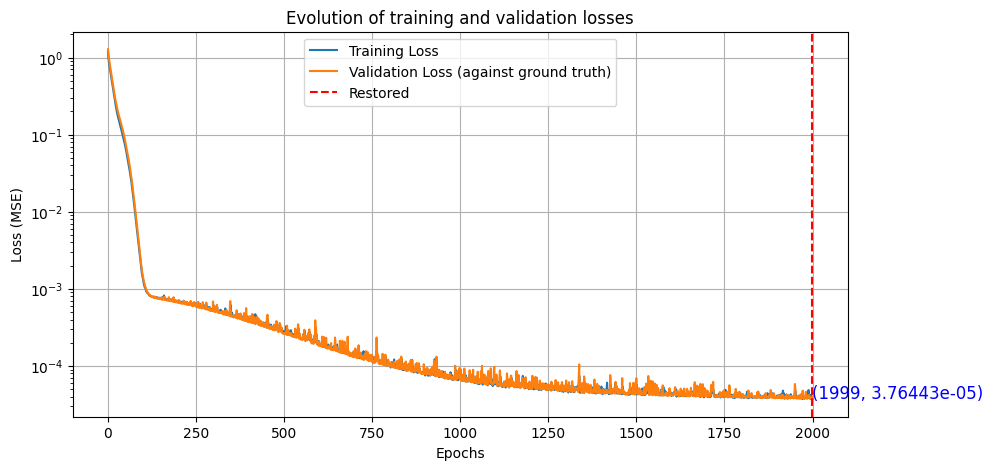

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8213


0.818962812423706

In [29]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 150
start_from_epoch = 200
loss = "mse"
metrics = []
schedule_tg = 100
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
batch = 32
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/punn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(n_features, ))) #_ for batch dim
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(1, activation="linear")) #output layer -> a^

punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#first column of Y is the label: acceleration
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_val_norm, Y_val_norm),
                                  batch_size=batch, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history, start_from_epoch)
punn_model.evaluate(x=X_val_norm, y=Y_val, batch_size=batch) #just to confirm final validation loss

In [30]:
punn_model.save("models/punn_model_best.h5")

## PUNN predictions
offline integration for testing, in reality it would be real-time

## Training trajectory

Training trajectory (1) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE/RMSE for acceleration: 9.73650e-07, 9.86737e-04
MSE/RMSE for velocity: 1.12460e-04, 1.06047e-02
MSE/RMSE for position: 9.86695e-02, 3.14117e-01
----


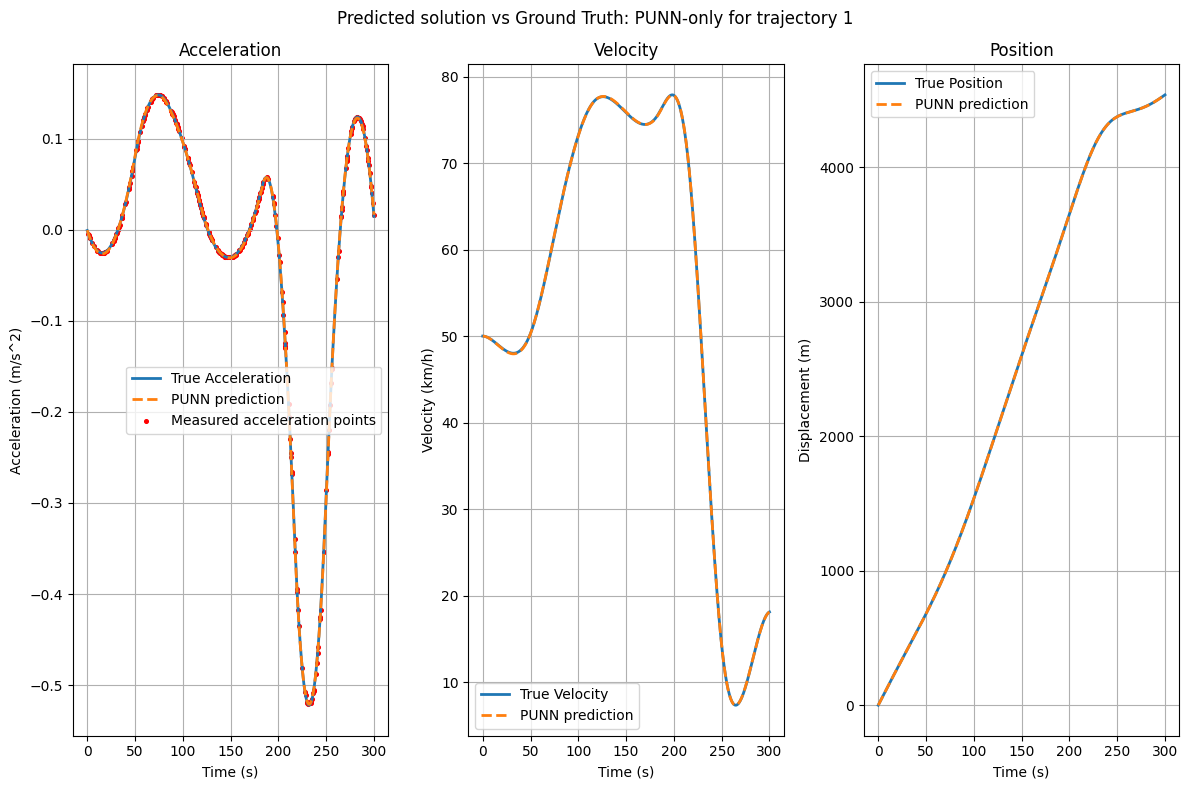

In [34]:
true_data = df_train_traj[["a_true_next", "v_true_next", "x_true_next"]].to_numpy()
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
print("Training trajectory (" + str(train_id) + ") statistics: ")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=X_norm, true_data=true_data, scaler_Y=scaler_Y)
print("----")
comparison_plot(t=t, true_data=true_data, meas_data=Y_mask,
    pred_data=[(punn_train_traj_eval, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory " + str(train_id)
)


## Testing trajectory (generalization ability)

Testing trajectory (0) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE/RMSE for acceleration: 1.17517e-05, 3.42808e-03
MSE/RMSE for velocity: 2.23023e-02, 1.49340e-01
MSE/RMSE for position: 8.78868e+01, 9.37480e+00
----


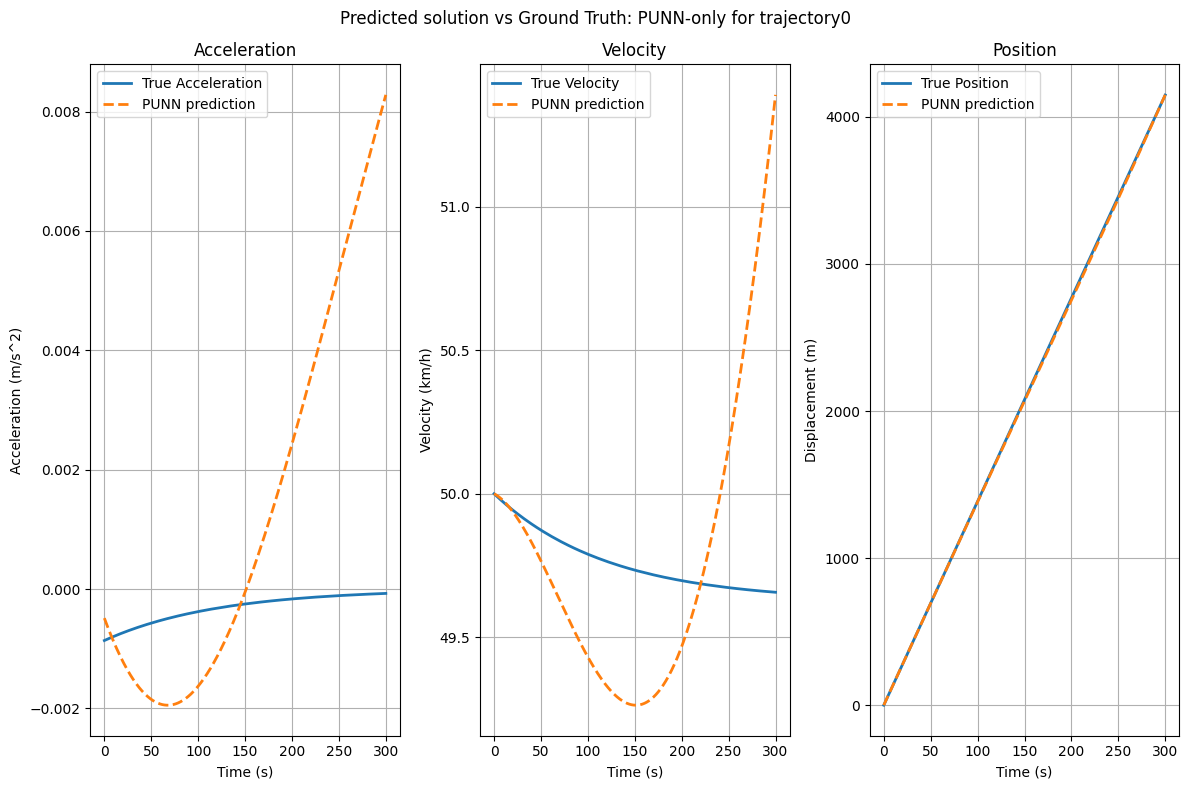

Testing trajectory (1) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 9.73650e-07, 9.86737e-04
MSE/RMSE for velocity: 1.12460e-04, 1.06047e-02
MSE/RMSE for position: 9.86695e-02, 3.14117e-01
----


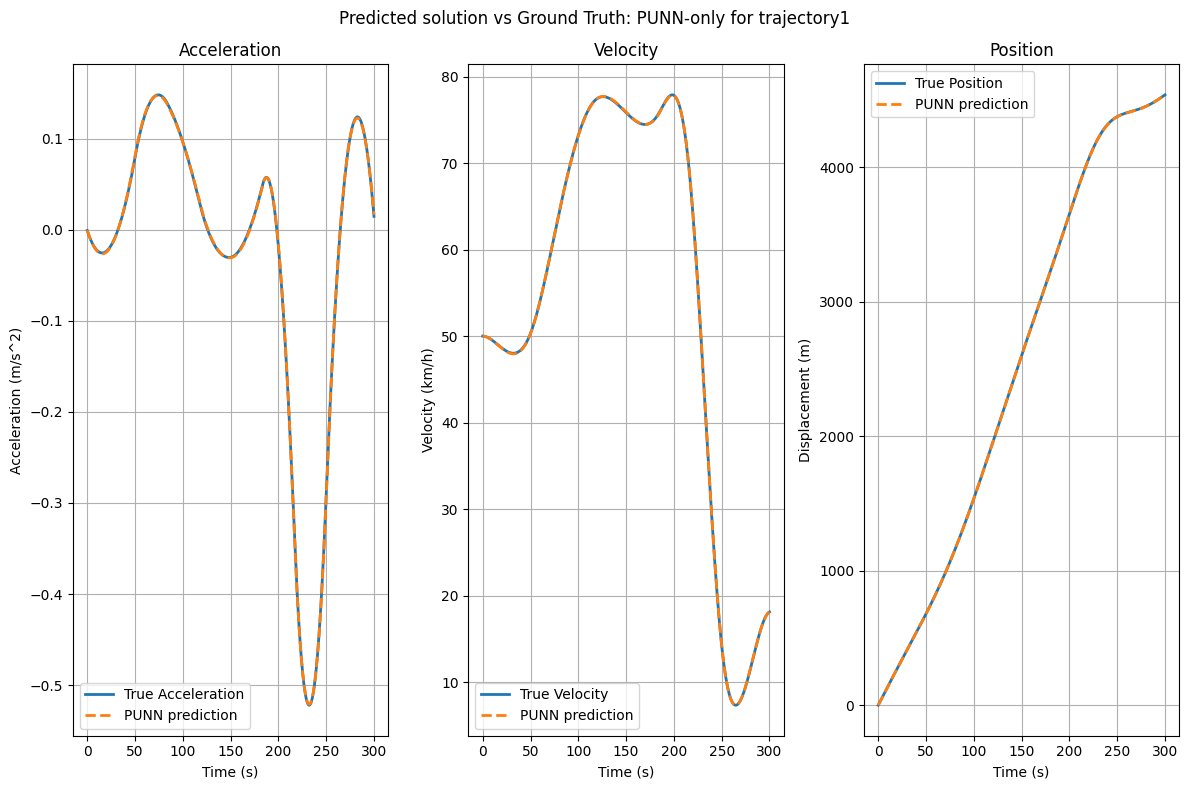

Testing trajectory (2) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 3.77036e-03, 6.14033e-02
MSE/RMSE for velocity: 4.45319e+01, 6.67322e+00
MSE/RMSE for position: 2.22871e+05, 4.72092e+02
----


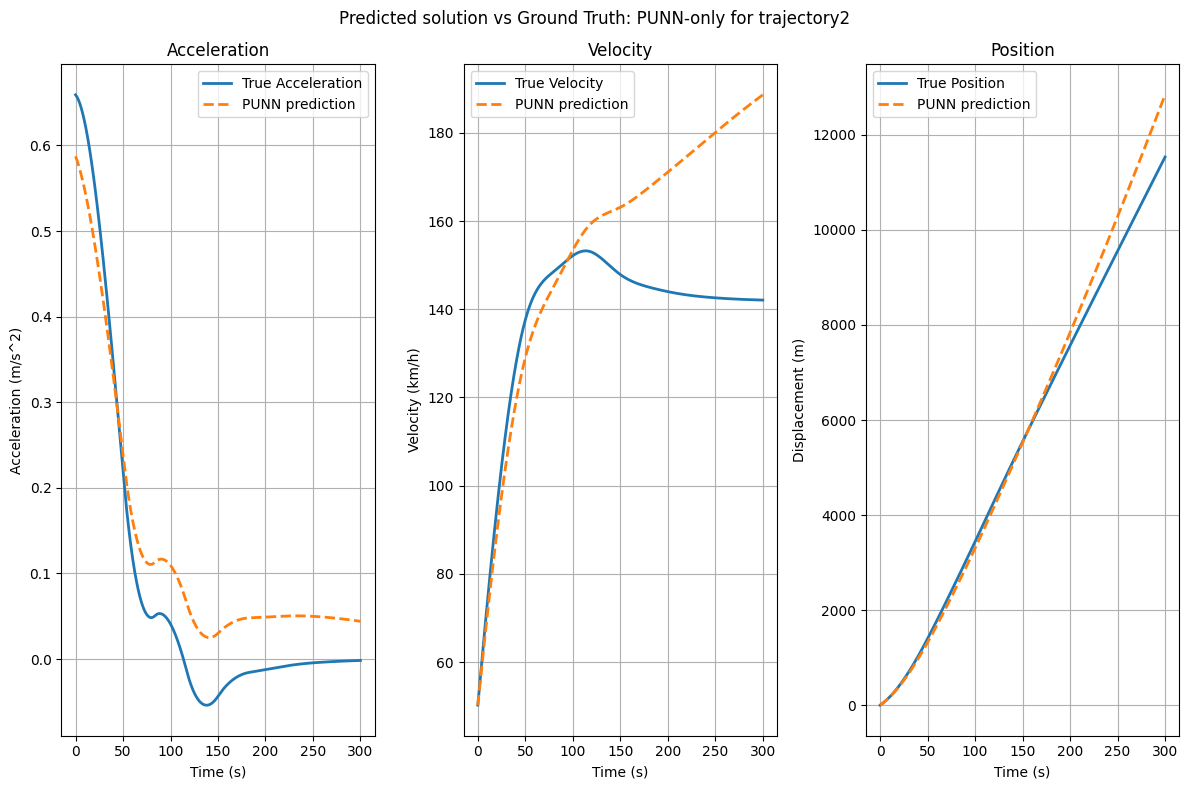

Testing trajectory (3) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 3.38340e-04, 1.83940e-02
MSE/RMSE for velocity: 3.42800e+00, 1.85148e+00
MSE/RMSE for position: 2.04861e+04, 1.43130e+02
----


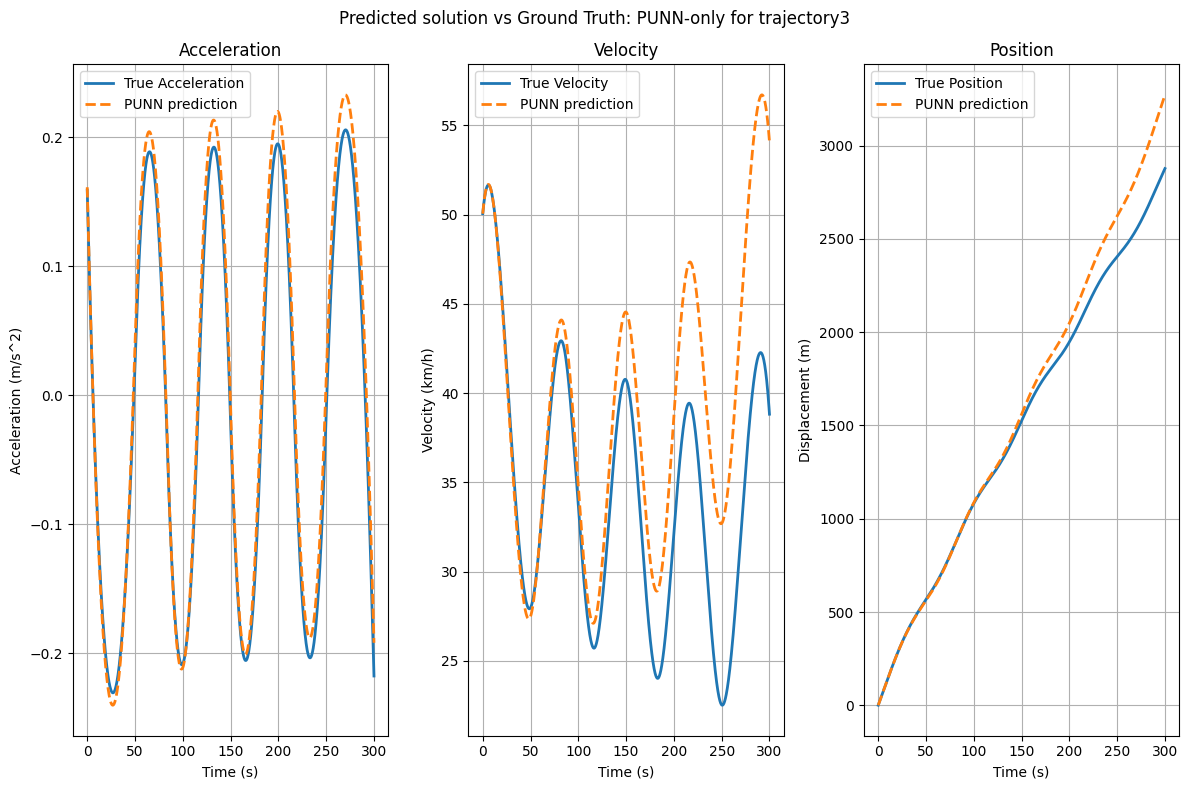

Testing trajectory (4) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 1.24250e-03, 3.52492e-02
MSE/RMSE for velocity: 6.04689e-01, 7.77618e-01
MSE/RMSE for position: 2.13508e+03, 4.62069e+01
----


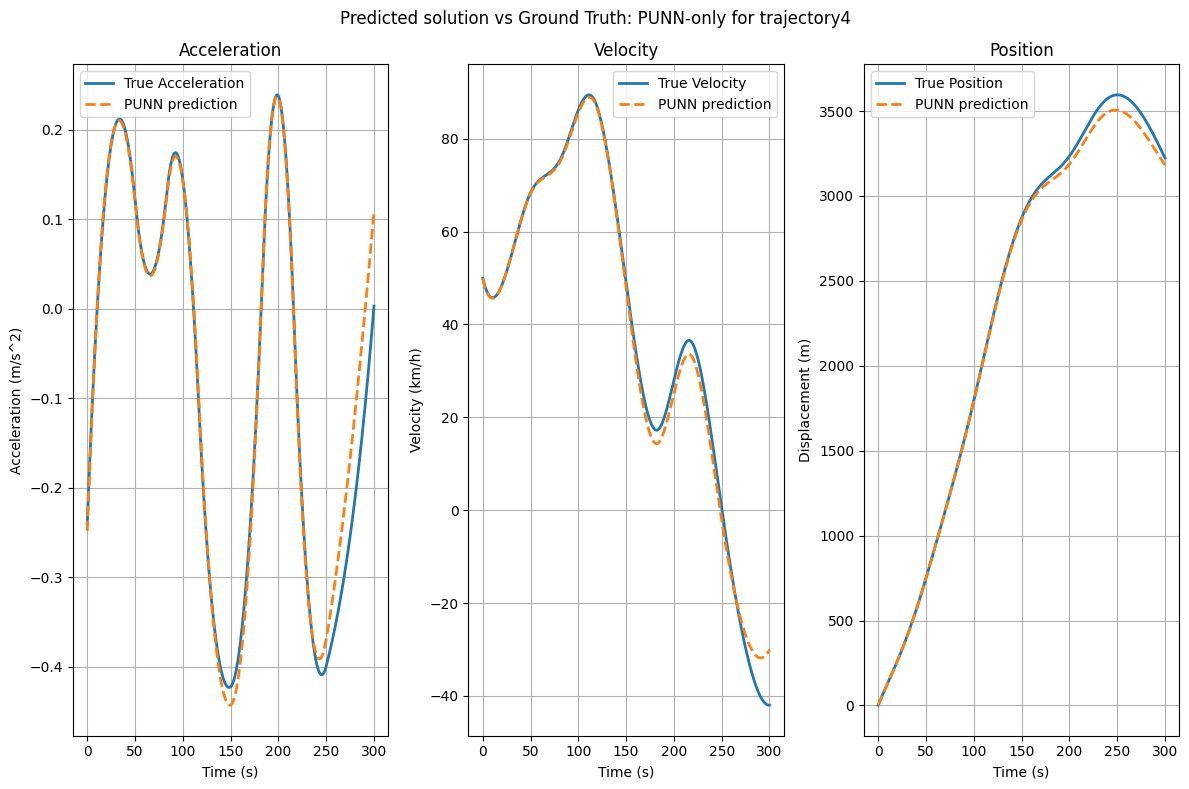

In [39]:
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction

for test_id in range(len(input_profiles)):
    df_test_traj = dataset[dataset['traj_id'] == test_id]
    X_test = df_test_traj[["t", "u", "v_true", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N
    X_test_norm = scaler_X.transform(X_test)
    true_data = df_test_traj[["a_true_next", "v_true_next", "x_true_next"]].to_numpy()

    print("Testing trajectory (" + str(test_id) + ") statistics: ")
    punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=true_data, scaler_Y=scaler_Y)
    print("----")
    comparison_plot(t=t, true_data=true_data, meas_data=None,
        pred_data=[(punn_test_traj_eval, "PUNN prediction")],
        suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory" + str(test_id)
    )

# PINN

## Combined Loss

In [ ]:
#not using this now
# def tf_cumulative_trapezoid(y, x):
#     """
#     Computes cumulative integral using the trapezoidal rule without breaking tensor computational graph
#     Both y and x must be 1D tensors of the same length.
#     """
#     dx = x[1:] - x[:-1]
#     areas = 0.5 * (y[1:] + y[:-1]) * dx
#     return tf.concat([[0.0], tf.math.cumsum(areas)], axis=0)


In [14]:
# collocation points
collocation_size = 20000
print("Number of collocation points: " + str(collocation_size))
#dimension size = 4 -> T x U x S (state: v, p)   
sampler = qmc.LatinHypercube(d=4)
collocation = sampler.random(n=collocation_size)
print(qmc.discrepancy(collocation)) #evaluate sampling distribution
l_bounds = [dataset['t'].min(), dataset['u'].min(), dataset['v_true'].min(), dataset['x_true'].min()]
u_bounds = [dataset['t'].max(), dataset['u'].max(), dataset['v_true'].max(), dataset['x_true'].max()]
X_c = qmc.scale(collocation, l_bounds, u_bounds).astype(np.float32)
pd.DataFrame(X_c).to_csv("data/collocation_data.csv")

Number of collocation points: 20000
9.665835599026451e-06


In [19]:
""" t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = input_interp[train_id] #get u from correct trajectory function
car.reset(x0)
df_c = simulate_traj(car=car, u_func=u_c, traj_id=train_id, t=t_c)
df_c.to_csv("data/train_traj_collocation.csv")
X_c = df_c[["t", "u", "v_true_m", "x_true"]].to_numpy()
X_c_norm = scaler_X.transform(X_c) """

class PinnModel(Sequential):
    def __init__(self, joint_training: bool, car,  *args, **kwargs):
        super().__init__(*args, **kwargs)
        if joint_training:
            #joint training of physics params
            """ self.c0 = self.add_weight(name="c0", shape=(), initializer="zeros",
                            trainable=True, dtype=tf.float32) #trainable -> added to tape.watch automatically according to docs
            self.c1 = self.add_weight(name="c1", shape=(), initializer="zeros",
                            trainable=True, dtype=tf.float32)
            self.phy_trainable = {"c0": self.c0, "c1": self.c1}
            #True values: c0 = 0.0075, c1 = 2*10**-4
            self.phy_trainable_true = phy_params """
        else:
            self.params = {
                "c0": tf.constant(car.c0, dtype=tf.float32),
                "c1": tf.constant(car.c1, dtype=tf.float32),
                "p": tf.constant(car.p, dtype=tf.float32),
                "m": tf.constant(car.m, dtype=tf.float32),
                "Af": tf.constant(car.Af, dtype=tf.float32),
                "Cd": tf.constant(car.Cd, dtype=tf.float32),
                "g": tf.constant(9.81, dtype=tf.float32),
                "road_grade": tf.constant(car.road_grade, dtype=tf.float32)
            }

class CombinedLoss(Loss):
    def __init__(self, model: keras.Model, X_c: np.ndarray,
                 scaler_X: MinMaxScaler, scaler_Y: StandardScaler, alpha: float):
        super().__init__()

        self.model = model
        self.alpha_d = alpha  #dictates data/physics ratio
        self.alpha_p = 1-alpha
        self.scaler_X = scaler_X
        self.scaler_Y = scaler_Y

        self.t_c, self.u, self.v, self.x = (tf.constant(X_c[:, i]) for i in range(X_c.shape[1]))
        self.X_c_norm = tf.constant(scaler_X.transform(X_c), dtype=tf.float32)

    def data_loss(self, y_true, y_pred):
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        g = self.model.params['g']     
        c0 = self.model.params['c0']     
        c1 = self.model.params['c1']     
        Cd = self.model.params['Cd']     
        m = self.model.params['m']     
        p = self.model.params['p']     
        road_grade = self.model.params["road_grade"]
        
        a_norm = self.model(self.X_c_norm) #use PUNN to predict on collocation points
        a_norm = tf.reshape(a_norm, shape=([-1])) #flatten for shape matching
        a_phy = a_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ #denormalize

        #resistive forces
        Fr = (c0 + c1 * self.v) * (m*g*tf.math.cos(road_grade))
        Fa = (p * Cd * Af * self.v**2) / 2.0
        Fg = m * g * tf.math.sin(road_grade)
        
        #physics residuals
        flow = (self.u - Fr - Fa - Fg)/m
        res = a_phy - flow  # Newton's law

        return tf.reduce_mean(tf.square(res))

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()

        return(
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss
        )

## Training

Epoch 1/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.5893 - mse: 1.0344

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.5791 - mse: 1.0149 - val_loss: 0.3384 - val_mse: 0.5678 - learning_rate: 0.0010
Epoch 2/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2558 - mse: 0.4100 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2539 - mse: 0.4072 - val_loss: 0.1953 - val_mse: 0.3111 - learning_rate: 0.0010
Epoch 3/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1571 - mse: 0.2432 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1553 - mse: 0.2408 - val_loss: 0.1218 - val_mse: 0.1929 - learning_rate: 0.0010
Epoch 4/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1181 - mse: 0.1899 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1143 - mse: 0.1831 - val_loss: 0.0978 - val_mse: 0.1625 - learning_rate: 0.0010
Epoch 5/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0790 - mse: 0.1253 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0781 - mse: 0.1238 - val_loss: 0.0706 - val_mse: 0.1185 - learning_rate: 0.0010
Epoch 6/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0520 - mse: 0.0814 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0514 - mse: 0.0804 - val_loss: 0.0473 - val_mse: 0.0772 - learning_rate: 0.0010
Epoch 7/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0359 - mse: 0.0549 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0355 - mse: 0.0543 - val_loss: 0.0310 - val_mse: 0.0482 - learning_rate: 0.0010
Epoch 8/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0229 - mse: 0.0327 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0222 - mse: 0.0314 - val_loss: 0.0165 - val_mse: 0.0228 - learning_rate: 0.0010
Epoch 9/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - mse: 0.0186 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0140 - mse: 0.0180 - val_loss: 0.0099 - val_mse: 0.0104 - learning_rate: 0.0010
Epoch 10/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mse: 0.0079 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0083 - mse: 0.0076 - val_loss: 0.0069 - val_mse: 0.0048 - learning_rate: 0.0010
Epoch 11/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mse: 0.0033 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0060 - mse: 0.0032 - val_loss: 0.0053 - val_mse: 0.0023 - learning_rate: 0.0010
Epoch 12/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0050 - mse: 0.0018 - val_loss: 0.0049 - val_mse: 0.0024 - learning_rate: 0.0010
Epoch 13/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - mse: 0.0017 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0045 - mse: 0.0017 - val_loss: 0.0044 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 14/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0044 - mse: 0.0015 - val_loss: 0.0043 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 15/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mse: 0.0012 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0041 - mse: 0.0012 - val_loss: 0.0041 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 16/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0040 - mse: 0.0012 - val_loss: 0.0040 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 17/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0039 - mse: 0.0011 - val_loss: 0.0039 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 18/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - mse: 0.0011     

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0039 - mse: 0.0011 - val_loss: 0.0038 - val_mse: 9.6779e-04 - learning_rate: 0.0010
Epoch 19/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0038 - mse: 0.0010 - val_loss: 0.0039 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 20/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0037 - mse: 0.0011 - val_loss: 0.0037 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 21/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0037 - mse: 0.0011 - val_loss: 0.0038 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 22/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0037 - mse: 0.0011 - val_loss: 0.0037 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 23/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mse: 9.8911e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0035 - mse: 9.7918e-04 - val_loss: 0.0034 - val_mse: 9.2369e-04 - learning_rate: 0.0010
Epoch 24/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0034 - mse: 8.2791e-04 - val_loss: 0.0036 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 25/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0036 - mse: 0.0012 - val_loss: 0.0035 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 26/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0034 - mse: 8.9104e-04 - val_loss: 0.0035 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 27/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0035 - mse: 0.0014 - val_loss: 0.0033 - val_mse: 9.5641e-04 - learning_rate: 0.0010
Epoch 28/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mse: 9.7477e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0033 - mse: 0.0010 - val_loss: 0.0033 - val_mse: 8.6426e-04 - learning_rate: 0.0010
Epoch 29/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0032 - mse: 8.0160e-04 - val_loss: 0.0033 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 30/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0032 - mse: 8.9687e-04 - val_loss: 0.0031 - val_mse: 8.8381e-04 - learning_rate: 0.0010
Epoch 31/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mse: 8.0548e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0031 - mse: 7.6523e-04 - val_loss: 0.0030 - val_mse: 6.0773e-04 - learning_rate: 0.0010
Epoch 32/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0030 - mse: 7.4049e-04 - val_loss: 0.0031 - val_mse: 8.7726e-04 - learning_rate: 0.0010
Epoch 33/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0034 - mse: 0.0015 - val_loss: 0.0036 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 34/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0034 - mse: 0.0014 - val_loss: 0.0031 - val_mse: 8.9669e-04 - learning_rate: 0.0010
Epoch 35/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0030 - mse: 8.3969e-04 - val_loss: 0.0029 - val_mse: 6.9471e-04 - learning_rate: 0.0010
Epoch 36/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0030 - mse: 9.3341e-04 - val_loss: 0.0029 - val_mse: 7.5802e-04 - learning_rate: 0.0010
Epoch 37/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0030 - mse: 9.7803e-04 - val_loss: 0.0030 - val_ms

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0024 - mse: 7.4014e-04 - val_loss: 0.0023 - val_mse: 6.0592e-04 - learning_rate: 0.0010
Epoch 55/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0023 - mse: 5.8602e-04 - val_loss: 0.0024 - val_mse: 8.9089e-04 - learning_rate: 0.0010
Epoch 56/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mse: 8.0801e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0023 - mse: 7.8710e-04 - val_loss: 0.0022 - val_mse: 5.6335e-04 - learning_rate: 0.0010
Epoch 57/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0023 - mse: 6.3927e-04 - val_loss: 0.0028 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 58/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0026 - mse: 0.0014 - val_loss: 0.0025 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 59/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0024 - mse: 9.9716e-04 - val_loss: 0.0022 - val_mse: 6.2915e-04 - learning_rate: 0.0010
Epoch 60/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0023 - mse: 7.7965e-04 - val_loss: 0.0024 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 61/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mse: 8.3116e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0022 - mse: 8.0811e-04 - val_loss: 0.0021 - val_mse: 5.1075e-04 - learning_rate: 0.0010
Epoch 62/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0021 - mse: 5.8855e-04 - val_loss: 0.0020 - val_mse: 5.6332e-04 - learning_rate: 0.0010
Epoch 63/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0022 - mse: 7.9722e-04 - val_loss: 0.0021 - val_mse: 6.4196e-04 - learning_rate: 0.0010
Epoch 64/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0021 - mse: 7.5713e-04 - val_loss: 0.0021 - val_mse: 8.5704e-04 - learning_rate: 0.0010
Epoch 65/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0021 - mse: 6.3256e-04 - val_loss: 0.0020 - val_mse: 5.9133e-04 - learning_rate: 0.0010
Epoch 66/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0020 - mse: 6.8984e-04 - val_loss: 0.0022 - val_mse: 9.3428e-04 - learning_rate: 0.0010
Epoch 67/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0021 - mse: 8.3337e-04 - val_loss: 0.0

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0019 - mse: 7.1336e-04 - val_loss: 0.0017 - val_mse: 4.5969e-04 - learning_rate: 0.0010
Epoch 72/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0017 - mse: 4.7835e-04 - val_loss: 0.0017 - val_mse: 4.9388e-04 - learning_rate: 0.0010
Epoch 73/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mse: 4.7336e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0017 - mse: 4.6348e-04 - val_loss: 0.0016 - val_mse: 4.1094e-04 - learning_rate: 0.0010
Epoch 74/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0017 - mse: 5.3985e-04 - val_loss: 0.0016 - val_mse: 4.5224e-04 - learning_rate: 0.0010
Epoch 75/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0017 - mse: 5.9549e-04 - val_loss: 0.0017 - val_mse: 6.1422e-04 - learning_rate: 0.0010
Epoch 76/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mse: 4.4589e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0016 - mse: 4.7968e-04 - val_loss: 0.0015 - val_mse: 3.5758e-04 - learning_rate: 0.0010
Epoch 77/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0015 - mse: 4.1505e-04 - val_loss: 0.0017 - val_mse: 7.5718e-04 - learning_rate: 0.0010
Epoch 78/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0016 - mse: 7.1191e-04 - val_loss: 0.0016 - val_mse: 6.2616e-04 - learning_rate: 0.0010
Epoch 79/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0015 - mse: 4.8314e-04 - val_loss: 0.0016 - val_mse: 7.3141e-04 - learning_rate: 0.0010
Epoch 80/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0015 - mse: 6.1808e-04 - val_loss: 0.0016 - val_mse: 7.8360e-04 - learning_rate: 0.0010
Epoch 81/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0014 - mse: 5.1802e-04 - val_loss: 0.0014 - val_mse: 4.1995e-04 - learning_rate: 0.0010
Epoch 82/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0013 - mse: 3.3342e-04 - val_loss: 0.0

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0013 - mse: 3.9244e-04 - val_loss: 0.0013 - val_mse: 3.4496e-04 - learning_rate: 0.0010
Epoch 84/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0013 - mse: 3.6939e-04 - val_loss: 0.0012 - val_mse: 3.4963e-04 - learning_rate: 0.0010
Epoch 85/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0013 - mse: 4.0104e-04 - val_loss: 0.0012 - val_mse: 4.0245e-04 - learning_rate: 0.0010
Epoch 86/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0012 - mse: 4.4971e-04 - val_loss: 0.0018 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 87/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0015 - mse: 9.5552e-04 - val_loss: 0.0023 - val_mse: 0.0027 - learning_rate: 0.0010
Epoch 88/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0018 - mse: 0.0016 - val_loss: 0.0013 - val_mse: 6.9802e-04 - learning_rate: 0.0010
Epoch 89/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mse: 0.0010     

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0015 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 2.8594e-04 - learning_rate: 0.0010
Epoch 90/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0014 - mse: 8.9671e-04 - val_loss: 0.0011 - val_mse: 3.7868e-04 - learning_rate: 0.0010
Epoch 91/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0011 - mse: 4.1041e-04 - val_loss: 0.0012 - val_mse: 6.6770e-04 - learning_rate: 0.0010
Epoch 92/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0013 - mse: 7.9066e-04 - val_loss: 0.0010 - val_mse: 3.9697e-04 - learning_rate: 0.0010
Epoch 93/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - mse: 5.9127e-04     

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0011 - mse: 5.8608e-04 - val_loss: 0.0010 - val_mse: 2.8590e-04 - learning_rate: 0.0010
Epoch 94/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0010 - mse: 2.9548e-04 - val_loss: 0.0010 - val_mse: 4.7888e-04 - learning_rate: 0.0010
Epoch 95/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0010 - mse: 4.1956e-04 - val_loss: 9.5306e-04 - val_mse: 3.0145e-04 - learning_rate: 0.0010
Epoch 96/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 9.8031e-04 - mse: 3.6901e-04 - val_loss: 0.0010 - val_mse: 5.9324e-04 - learning_rate: 0.0010
Epoch 97/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 9.5982e-04 - mse: 4.2237e-04 - val_loss: 9.5052e-04 - val_mse: 3.2354e-04 - learning_rate: 0.0010
Epoch 98/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 9.4646e-04 - mse: 3.2651e-04 - val_loss: 9.7172e-04 - val_mse: 5.2652e-04 - learning_rate: 0.0010
Epoch 99/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0010 - mse: 5.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0011 - mse: 0.0013 - val_loss: 5.7714e-04 - val_mse: 2.4245e-04 - learning_rate: 9.0000e-04
Epoch 153/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0010 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0014 - learning_rate: 9.0000e-04
Epoch 154/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.8444e-04 - mse: 0.0010 - val_loss: 0.0013 - val_mse: 0.0017 - learning_rate: 9.0000e-04
Epoch 155/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 9.7386e-04 - mse: 0.0011 - val_loss: 0.0010 - val_mse: 0.0011 - learning_rate: 9.0000e-04
Epoch 156/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.4117e-04 - mse: 7.7246e-04 - val_loss: 5.5797e-04 - val_mse: 2.6082e-04 - learning_rate: 9.0000e-04
Epoch 157/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.2517e-04 - mse: 3.7386e-04 - val_loss: 5.6040e-04 - val_mse: 2.8883e-04 - learning_rate: 9.0000e-04
Epoch 158/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.5117e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 5.7300e-04 - mse: 4.1132e-04 - val_loss: 4.6985e-04 - val_mse: 2.0327e-04 - learning_rate: 9.0000e-04
Epoch 188/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.9640e-04 - mse: 2.4215e-04 - val_loss: 5.6112e-04 - val_mse: 4.1551e-04 - learning_rate: 9.0000e-04
Epoch 189/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.6611e-04 - mse: 4.1842e-04 - val_loss: 9.3202e-04 - val_mse: 0.0011 - learning_rate: 9.0000e-04
Epoch 190/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.3635e-04 - mse: 7.2061e-04 - val_loss: 7.0393e-04 - val_mse: 6.7181e-04 - learning_rate: 9.0000e-04
Epoch 191/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.1511e-04 - mse: 5.0426e-04 - val_loss: 5.3918e-04 - val_mse: 3.2859e-04 - learning_rate: 9.0000e-04
Epoch 192/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.4713e-04 - mse: 3.4370e-04 - val_loss: 5.3874e-04 - val_mse: 3.7630e-04 - learning_rate: 9.0000e-04
Epoch 193/2000
10/10 ━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.5578e-04 - mse: 4.3505e-04 - val_loss: 4.4248e-04 - val_mse: 1.7904e-04 - learning_rate: 8.1000e-04
Epoch 201/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.9315e-04 - mse: 2.8437e-04 - val_loss: 6.4272e-04 - val_mse: 6.1969e-04 - learning_rate: 8.1000e-04
Epoch 202/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.7943e-04 - mse: 4.7367e-04 - val_loss: 5.7830e-04 - val_mse: 4.7070e-04 - learning_rate: 8.1000e-04
Epoch 203/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.5598e-04 - mse: 4.3702e-04 - val_loss: 4.4531e-04 - val_mse: 1.9716e-04 - learning_rate: 8.1000e-04
Epoch 204/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.1451e-04 - mse: 5.5097e-04 - val_loss: 6.0248e-04 - val_mse: 5.0154e-04 - learning_rate: 8.1000e-04
Epoch 205/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.8616e-04 - mse: 2.8023e-04 - val_loss: 4.6575e-04 - val_mse: 2.7105e-04 - learning_rate: 8.1000e-04
Epoch 206/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.1190e-04 - mse: 4.0442e-04 - val_loss: 4.1129e-04 - val_mse: 1.6185e-04 - learning_rate: 8.1000e-04
Epoch 216/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.4871e-04 - mse: 2.4172e-04 - val_loss: 4.0804e-04 - val_mse: 1.7200e-04 - learning_rate: 8.1000e-04
Epoch 217/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.6509e-04 - mse: 2.9507e-04 - val_loss: 4.1091e-04 - val_mse: 1.6264e-04 - learning_rate: 8.1000e-04
Epoch 218/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 4.0608e-04 - mse: 1.5239e-04 - val_loss: 4.1271e-04 - val_mse: 2.0641e-04 - learning_rate: 8.1000e-04
Epoch 219/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.0146e-04 - mse: 1.7173e-04 - val_loss: 4.4916e-04 - val_mse: 2.5222e-04 - learning_rate: 8.1000e-04
Epoch 220/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.2609e-04 - mse: 2.1838e-04 - val_loss: 4.5468e-04 - val_mse: 2.6073e-04 - learning_rate: 8.1000e-04
Epoch 221/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 5.2357e-04 - mse: 4.3800e-04 - val_loss: 3.6762e-04 - val_mse: 1.5026e-04 - learning_rate: 8.1000e-04
Epoch 237/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.0960e-04 - mse: 2.2872e-04 - val_loss: 4.4391e-04 - val_mse: 2.8513e-04 - learning_rate: 8.1000e-04
Epoch 238/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.6768e-04 - mse: 3.3789e-04 - val_loss: 8.1181e-04 - val_mse: 0.0010 - learning_rate: 8.1000e-04
Epoch 239/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.3242e-04 - mse: 6.4957e-04 - val_loss: 3.9242e-04 - val_mse: 2.3705e-04 - learning_rate: 8.1000e-04
Epoch 240/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.7548e-04 - mse: 3.7755e-04 - val_loss: 3.8054e-04 - val_mse: 1.6757e-04 - learning_rate: 8.1000e-04
Epoch 241/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.1776e-04 - mse: 2.5718e-04 - val_loss: 4.1231e-04 - val_mse: 2.4669e-04 - learning_rate: 8.1000e-04
Epoch 242/2000
10/10 ━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 6.8631e-04 - mse: 7.8079e-04 - val_loss: 3.6775e-04 - val_mse: 1.4388e-04 - learning_rate: 8.1000e-04
Epoch 248/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.8387e-04 - mse: 3.9247e-04 - val_loss: 4.9763e-04 - val_mse: 3.9385e-04 - learning_rate: 8.1000e-04
Epoch 249/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.4928e-04 - mse: 3.0144e-04 - val_loss: 5.6387e-04 - val_mse: 5.7676e-04 - learning_rate: 8.1000e-04
Epoch 250/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.7012e-04 - mse: 5.7381e-04 - val_loss: 8.4464e-04 - val_mse: 0.0011 - learning_rate: 8.1000e-04
Epoch 251/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.7230e-04 - mse: 5.8066e-04 - val_loss: 5.8023e-04 - val_mse: 5.7960e-04 - learning_rate: 8.1000e-04
Epoch 252/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.1900e-04 - mse: 4.5095e-04 - val_loss: 0.0014 - val_mse: 0.0022 - learning_rate: 8.1000e-04
Epoch 253/2000
10/10 ━━━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.7721e-04 - mse: 2.1205e-04 - val_loss: 3.3872e-04 - val_mse: 1.2740e-04 - learning_rate: 8.1000e-04
Epoch 264/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.3277e-04 - mse: 1.2470e-04 - val_loss: 6.3564e-04 - val_mse: 7.4604e-04 - learning_rate: 8.1000e-04
Epoch 265/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.2855e-04 - mse: 5.1713e-04 - val_loss: 4.3863e-04 - val_mse: 3.6549e-04 - learning_rate: 8.1000e-04
Epoch 266/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.2907e-04 - mse: 5.2755e-04 - val_loss: 4.8139e-04 - val_mse: 4.0389e-04 - learning_rate: 8.1000e-04
Epoch 267/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.3728e-04 - mse: 3.2959e-04 - val_loss: 4.2202e-04 - val_mse: 3.4141e-04 - learning_rate: 8.1000e-04
Epoch 268/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.4136e-04 - mse: 3.7094e-04 - val_loss: 4.1733e-04 - val_mse: 3.0730e-04 - learning_rate: 8.1000e-04
Epoch 269/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.7342e-04 - mse: 2.5307e-04 - val_loss: 3.0135e-04 - val_mse: 1.1826e-04 - learning_rate: 8.1000e-04
Epoch 289/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.1691e-04 - mse: 1.4318e-04 - val_loss: 3.0138e-04 - val_mse: 1.2580e-04 - learning_rate: 8.1000e-04
Epoch 290/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.8828e-04 - mse: 2.8898e-04 - val_loss: 3.6289e-04 - val_mse: 2.4228e-04 - learning_rate: 8.1000e-04
Epoch 291/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.0184e-04 - mse: 3.0216e-04 - val_loss: 8.5199e-04 - val_mse: 0.0012 - learning_rate: 8.1000e-04
Epoch 292/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.6033e-04 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0017 - learning_rate: 8.1000e-04
Epoch 293/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.5711e-04 - mse: 9.9235e-04 - val_loss: 4.9048e-04 - val_mse: 5.0239e-04 - learning_rate: 8.1000e-04
Epoch 294/2000
10/10 ━━━━━━━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.7643e-04 - mse: 4.5514e-04 - val_loss: 2.9208e-04 - val_mse: 1.0310e-04 - learning_rate: 8.1000e-04
Epoch 298/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.0031e-04 - mse: 3.2097e-04 - val_loss: 3.6283e-04 - val_mse: 2.4654e-04 - learning_rate: 8.1000e-04
Epoch 299/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.1005e-04 - mse: 3.3394e-04 - val_loss: 7.1255e-04 - val_mse: 9.1979e-04 - learning_rate: 8.1000e-04
Epoch 300/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.2649e-04 - mse: 5.7596e-04 - val_loss: 4.0023e-04 - val_mse: 3.1416e-04 - learning_rate: 7.2900e-04
Epoch 301/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.5176e-04 - mse: 2.2489e-04 - val_loss: 5.1438e-04 - val_mse: 5.5492e-04 - learning_rate: 7.2900e-04
Epoch 302/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.2398e-04 - mse: 3.7840e-04 - val_loss: 3.9736e-04 - val_mse: 3.2763e-04 - learning_rate: 7.2900e-04
Epoch 303/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.8942e-04 - mse: 1.5309e-04 - val_loss: 2.6889e-04 - val_mse: 9.7805e-05 - learning_rate: 7.2900e-04
Epoch 321/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.1035e-04 - mse: 1.8401e-04 - val_loss: 3.7149e-04 - val_mse: 3.0018e-04 - learning_rate: 7.2900e-04
Epoch 322/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.1284e-04 - mse: 1.8647e-04 - val_loss: 2.6683e-04 - val_mse: 1.0335e-04 - learning_rate: 7.2900e-04
Epoch 323/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.5985e-04 - mse: 9.0184e-05 - val_loss: 2.6729e-04 - val_mse: 1.0562e-04 - learning_rate: 7.2900e-04
Epoch 324/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8128e-04 - mse: 1.2326e-04 - val_loss: 2.8271e-04 - val_mse: 1.5945e-04 - learning_rate: 7.2900e-04
Epoch 325/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.8399e-04 - mse: 1.5236e-04 - val_loss: 2.9955e-04 - val_mse: 1.6817e-04 - learning_rate: 7.2900e-04
Epoch 326/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.5801e-04 - mse: 1.1898e-04 - val_loss: 2.4624e-04 - val_mse: 9.1679e-05 - learning_rate: 7.2900e-04
Epoch 345/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.4866e-04 - mse: 9.7690e-05 - val_loss: 3.4004e-04 - val_mse: 2.8082e-04 - learning_rate: 7.2900e-04
Epoch 346/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.3269e-04 - mse: 2.6552e-04 - val_loss: 3.0779e-04 - val_mse: 1.9879e-04 - learning_rate: 7.2900e-04
Epoch 347/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9608e-04 - mse: 1.8170e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.9055e-04 - mse: 1.7303e-04 - val_loss: 2.4170e-04 - val_mse: 9.1080e-05 - learning_rate: 7.2900e-04
Epoch 348/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6127e-04 - mse: 1.3256e-04 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.6246e-04 - mse: 1.3538e-04 - val_loss: 2.4224e-04 - val_mse: 8.4569e-05 - learning_rate: 7.2900e-04
Epoch 349/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.4007e-04 - mse: 7.9998e-05 - val_loss: 2.8211e-04 - val_mse: 1.7980e-04 - learning_rate: 7.2900e-04
Epoch 350/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.7201e-04 - mse: 1.5301e-04 - val_loss: 2.8129e-04 - val_mse: 1.7909e-04 - learning_rate: 7.2900e-04
Epoch 351/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.5495e-04 - mse: 1.2750e-04 - val_loss: 2.7712e-04 - val_mse: 1.6119e-04 - learning_rate: 7.2900e-04
Epoch 352/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.5740e-04 - mse: 1.3170e-04 - val_loss: 2.4973e-04 - val_mse: 1.0654e-04 - learning_rate: 7.2900e-04
Epoch 353/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.8842e-04 - mse: 1.9116e-04 - val_loss: 3.4364e-04 - val_mse: 3.0373e-04 - learning_rate: 7.2900e-04
Epoch 354/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.5621e-04 - mse: 1.5566e-04 - val_loss: 2.1371e-04 - val_mse: 7.7357e-05 - learning_rate: 7.2900e-04
Epoch 379/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.2349e-04 - mse: 9.9699e-05 - val_loss: 2.1399e-04 - val_mse: 7.8570e-05 - learning_rate: 7.2900e-04
Epoch 380/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.5252e-04 - mse: 1.5351e-04 - val_loss: 2.9315e-04 - val_mse: 2.5004e-04 - learning_rate: 7.2900e-04
Epoch 381/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.6715e-04 - mse: 1.8968e-04 - val_loss: 2.1528e-04 - val_mse: 9.4836e-05 - learning_rate: 7.2900e-04
Epoch 382/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.2121e-04 - mse: 9.6299e-05 - val_loss: 2.5260e-04 - val_mse: 1.5689e-04 - learning_rate: 7.2900e-04
Epoch 383/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.5495e-04 - mse: 1.6081e-04 - val_loss: 3.3032e-04 - val_mse: 3.1868e-04 - learning_rate: 7.2900e-04
Epoch 384/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.3445e-04 - mse: 1.3187e-04 - val_loss: 2.0489e-04 - val_mse: 6.9509e-05 - learning_rate: 7.2900e-04
Epoch 395/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.4020e-04 - mse: 1.4540e-04 - val_loss: 2.0791e-04 - val_mse: 7.6726e-05 - learning_rate: 7.2900e-04
Epoch 396/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.5309e-04 - mse: 1.6943e-04 - val_loss: 2.5849e-04 - val_mse: 1.6565e-04 - learning_rate: 7.2900e-04
Epoch 397/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.5019e-04 - mse: 1.6332e-04 - val_loss: 2.2092e-04 - val_mse: 9.6724e-05 - learning_rate: 7.2900e-04
Epoch 398/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.1617e-04 - mse: 9.7827e-05 - val_loss: 2.2554e-04 - val_mse: 1.3210e-04 - learning_rate: 7.2900e-04
Epoch 399/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.6725e-04 - mse: 2.0227e-04 - val_loss: 3.0432e-04 - val_mse: 2.7962e-04 - learning_rate: 7.2900e-04
Epoch 400/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.4798e-04 - mse: 1.7444e-04 - val_loss: 1.8928e-04 - val_mse: 6.0575e-05 - learning_rate: 6.5610e-04
Epoch 408/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.6388e-04 - mse: 2.0944e-04 - val_loss: 2.1825e-04 - val_mse: 1.0792e-04 - learning_rate: 6.5610e-04
Epoch 409/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.7614e-04 - mse: 2.2724e-04 - val_loss: 2.6007e-04 - val_mse: 1.9222e-04 - learning_rate: 6.5610e-04
Epoch 410/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.6565e-04 - mse: 2.1126e-04 - val_loss: 2.8957e-04 - val_mse: 2.6551e-04 - learning_rate: 6.5610e-04
Epoch 411/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.9727e-04 - mse: 2.7516e-04 - val_loss: 2.0890e-04 - val_mse: 1.0590e-04 - learning_rate: 6.5610e-04
Epoch 412/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.1524e-04 - mse: 1.1386e-04 - val_loss: 2.9460e-04 - val_mse: 2.8133e-04 - learning_rate: 6.5610e-04
Epoch 413/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.7814e-04 - mse: 6.6005e-05 - val_loss: 1.7456e-04 - val_mse: 5.7386e-05 - learning_rate: 6.5610e-04
Epoch 432/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.8184e-04 - mse: 7.3216e-05 - val_loss: 2.0846e-04 - val_mse: 1.1918e-04 - learning_rate: 6.5610e-04
Epoch 433/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.8554e-04 - mse: 8.1112e-05 - val_loss: 1.9045e-04 - val_mse: 8.4612e-05 - learning_rate: 6.5610e-04
Epoch 434/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.8384e-04 - mse: 7.6513e-05 - val_loss: 2.5557e-04 - val_mse: 2.2074e-04 - learning_rate: 6.5610e-04
Epoch 435/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.3674e-04 - mse: 1.7496e-04 - val_loss: 4.7996e-04 - val_mse: 6.7653e-04 - learning_rate: 6.5610e-04
Epoch 436/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.6962e-04 - mse: 4.4391e-04 - val_loss: 2.0263e-04 - val_mse: 1.3481e-04 - learning_rate: 6.5610e-04
Epoch 437/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.3117e-04 - mse: 2.1438e-04 - val_loss: 1.4357e-04 - val_mse: 4.7038e-05 - learning_rate: 6.5610e-04
Epoch 481/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6538e-04 - mse: 9.3056e-05 - val_loss: 3.1687e-04 - val_mse: 3.7380e-04 - learning_rate: 6.5610e-04
Epoch 482/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.4144e-04 - mse: 2.3981e-04 - val_loss: 2.4423e-04 - val_mse: 2.2129e-04 - learning_rate: 6.5610e-04
Epoch 483/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.3800e-04 - mse: 2.1993e-04 - val_loss: 4.5961e-04 - val_mse: 6.6992e-04 - learning_rate: 6.5610e-04
Epoch 484/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.3176e-04 - mse: 5.9848e-04 - val_loss: 2.2268e-04 - val_mse: 2.0846e-04 - learning_rate: 6.5610e-04
Epoch 485/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.5275e-04 - mse: 2.4771e-04 - val_loss: 2.3850e-04 - val_mse: 2.3772e-04 - learning_rate: 6.5610e-04
Epoch 486/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.5333e-04 - mse: 7.6718e-05 - val_loss: 1.3219e-04 - val_mse: 4.4308e-05 - learning_rate: 5.9049e-04
Epoch 506/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4622e-04 - mse: 6.7202e-05 - val_loss: 1.5490e-04 - val_mse: 8.9453e-05 - learning_rate: 5.9049e-04
Epoch 507/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.5277e-04 - mse: 8.3540e-05 - val_loss: 1.8445e-04 - val_mse: 1.3743e-04 - learning_rate: 5.9049e-04
Epoch 508/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.6405e-04 - mse: 1.0467e-04 - val_loss: 1.3763e-04 - val_mse: 4.6585e-05 - learning_rate: 5.9049e-04
Epoch 509/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.5309e-04 - mse: 8.2390e-05 - val_loss: 2.5070e-04 - val_mse: 2.7975e-04 - learning_rate: 5.9049e-04
Epoch 510/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.0098e-04 - mse: 1.7776e-04 - val_loss: 2.4062e-04 - val_mse: 2.6200e-04 - learning_rate: 5.9049e-04
Epoch 511/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.3951e-04 - mse: 6.6508e-05 - val_loss: 1.2347e-04 - val_mse: 3.4132e-05 - learning_rate: 5.9049e-04
Epoch 520/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.3082e-04 - mse: 4.9403e-05 - val_loss: 1.5957e-04 - val_mse: 1.1318e-04 - learning_rate: 5.9049e-04
Epoch 521/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.5119e-04 - mse: 9.3110e-05 - val_loss: 1.4540e-04 - val_mse: 8.1725e-05 - learning_rate: 5.9049e-04
Epoch 522/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.4695e-04 - mse: 8.4113e-05 - val_loss: 2.1107e-04 - val_mse: 1.9985e-04 - learning_rate: 5.9049e-04
Epoch 523/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.8880e-04 - mse: 1.6226e-04 - val_loss: 1.9923e-04 - val_mse: 1.7736e-04 - learning_rate: 5.9049e-04
Epoch 524/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.8491e-04 - mse: 1.4883e-04 - val_loss: 1.7329e-04 - val_mse: 1.4113e-04 - learning_rate: 5.9049e-04
Epoch 525/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.3778e-04 - mse: 7.1708e-05 - val_loss: 1.1953e-04 - val_mse: 3.3136e-05 - learning_rate: 5.9049e-04
Epoch 533/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.2423e-04 - mse: 4.2995e-05 - val_loss: 1.3016e-04 - val_mse: 5.9507e-05 - learning_rate: 5.9049e-04
Epoch 534/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.2490e-04 - mse: 4.9480e-05 - val_loss: 1.1722e-04 - val_mse: 3.9053e-05 - learning_rate: 5.9049e-04
Epoch 535/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.2806e-04 - mse: 5.8899e-05 - val_loss: 1.5902e-04 - val_mse: 1.2505e-04 - learning_rate: 5.9049e-04
Epoch 536/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3397e-04 - mse: 7.0699e-05 - val_loss: 1.2311e-04 - val_mse: 5.0168e-05 - learning_rate: 5.9049e-04
Epoch 537/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.2539e-04 - mse: 5.4240e-05 - val_loss: 1.2094e-04 - val_mse: 3.8344e-05 - learning_rate: 5.9049e-04
Epoch 538/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 1.2777e-04 - mse: 6.6937e-05 - val_loss: 1.1322e-04 - val_mse: 3.0969e-05 - learning_rate: 5.9049e-04
Epoch 548/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1.4258e-04 - mse: 9.1936e-05 - val_loss: 1.5297e-04 - val_mse: 1.0476e-04 - learning_rate: 5.9049e-04
Epoch 549/2000
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3564e-04 - mse: 7.1652e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 1.3128e-04 - mse: 6.5718e-05 - val_loss: 1.1228e-04 - val_mse: 3.0064e-05 - learning_rate: 5.9049e-04
Epoch 550/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.2982e-04 - mse: 6.7010e-05 - val_loss: 1.8530e-04 - val_mse: 1.7474e-04 - learning_rate: 5.9049e-04
Epoch 551/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.5875e-04 - mse: 1.2318e-04 - val_loss: 1.4639e-04 - val_mse: 1.0604e-04 - learning_rate: 5.9049e-04
Epoch 552/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.3597e-04 - mse: 8.2360e-05 - val_loss: 1.6360e-04 - val_mse: 1.3184e-04 - learning_rate: 5.9049e-04
Epoch 553/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.5365e-04 - mse: 1.1346e-04 - val_loss: 1.1192e-04 - val_mse: 4.2017e-05 - learning_rate: 5.9049e-04
Epoch 554/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.1037e-04 - mse: 3.6970e-05 - val_loss: 1.3512e-04 - val_mse: 8.4732e-05 - learning_rate: 5.9049e-04
Epoch 555/2000
10/10 ━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.4961e-04 - mse: 1.4187e-04 - val_loss: 8.7714e-05 - val_mse: 2.2250e-05 - learning_rate: 5.3144e-04
Epoch 601/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4287e-04 - mse: 1.3117e-04 - val_loss: 9.1520e-05 - val_mse: 2.7029e-05 - learning_rate: 5.3144e-04
Epoch 602/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.0222e-04 - mse: 5.0731e-05 - val_loss: 8.8556e-05 - val_mse: 2.7546e-05 - learning_rate: 5.3144e-04
Epoch 603/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.9051e-05 - mse: 2.8089e-05 - val_loss: 1.3141e-04 - val_mse: 1.1314e-04 - learning_rate: 5.3144e-04
Epoch 604/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1952e-04 - mse: 8.8809e-05 - val_loss: 1.4135e-04 - val_mse: 1.2533e-04 - learning_rate: 5.3144e-04
Epoch 605/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1340e-04 - mse: 7.4957e-05 - val_loss: 1.4417e-04 - val_mse: 1.3647e-04 - learning_rate: 5.3144e-04
Epoch 606/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.9801e-05 - mse: 2.3874e-05 - val_loss: 7.7999e-05 - val_mse: 2.2134e-05 - learning_rate: 5.3144e-04
Epoch 630/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.9230e-05 - mse: 2.3863e-05 - val_loss: 7.8821e-05 - val_mse: 2.4964e-05 - learning_rate: 5.3144e-04
Epoch 631/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9565e-05 - mse: 2.6433e-05 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.9575e-05 - mse: 2.6022e-05 - val_loss: 7.5089e-05 - val_mse: 1.7434e-05 - learning_rate: 5.3144e-04
Epoch 632/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.7225e-05 - mse: 2.1840e-05 - val_loss: 8.1510e-05 - val_mse: 3.0413e-05 - learning_rate: 5.3144e-04
Epoch 633/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 8.2686e-05 - mse: 3.2600e-05 - val_loss: 9.0493e-05 - val_mse: 4.9359e-05 - learning_rate: 5.3144e-04
Epoch 634/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.3560e-04 - mse: 1.3605e-04 - val_loss: 2.1720e-04 - val_mse: 3.0229e-04 - learning_rate: 5.3144e-04
Epoch 635/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.6653e-04 - mse: 1.9562e-04 - val_loss: 1.2311e-04 - val_mse: 1.1591e-04 - learning_rate: 5.3144e-04
Epoch 636/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.3401e-04 - mse: 1.3035e-04 - val_loss: 8.3437e-05 - val_mse: 3.3630e-05 - learning_rate: 5.3144e-04
Epoch 637/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 8.1879e-05 - mse: 4.0885e-05 - val_loss: 6.9727e-05 - val_mse: 1.5063e-05 - learning_rate: 5.3144e-04
Epoch 651/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.3066e-05 - mse: 2.2614e-05 - val_loss: 7.2015e-05 - val_mse: 2.3074e-05 - learning_rate: 5.3144e-04
Epoch 652/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.1019e-05 - mse: 2.0034e-05 - val_loss: 7.6666e-05 - val_mse: 3.1881e-05 - learning_rate: 5.3144e-04
Epoch 653/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.0522e-05 - mse: 3.8429e-05 - val_loss: 8.1484e-05 - val_mse: 3.9681e-05 - learning_rate: 5.3144e-04
Epoch 654/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6266e-05 - mse: 5.0467e-05 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.6384e-05 - mse: 5.0611e-05 - val_loss: 6.8210e-05 - val_mse: 1.4542e-05 - learning_rate: 5.3144e-04
Epoch 655/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 7.3525e-05 - mse: 2.5912e-05 - val_loss: 7.0962e-05 - val_mse: 1.9592e-05 - learning_rate: 5.3144e-04
Epoch 656/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.5591e-05 - mse: 2.9809e-05 - val_loss: 6.9439e-05 - val_mse: 1.4745e-05 - learning_rate: 5.3144e-04
Epoch 657/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.5944e-05 - mse: 3.0304e-05 - val_loss: 8.7912e-05 - val_mse: 5.1116e-05 - learning_rate: 5.3144e-04
Epoch 658/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.5422e-05 - mse: 4.8358e-05 - val_loss: 7.1338e-05 - val_mse: 2.0956e-05 - learning_rate: 5.3144e-04
Epoch 659/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.7465e-05 - mse: 3.2416e-05 - val_loss: 9.8856e-05 - val_mse: 7.8728e-05 - learning_rate: 5.3144e-04
Epoch 660/2000
10/10 ━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 6.0319e-05 - mse: 2.3938e-05 - val_loss: 5.5134e-05 - val_mse: 1.4325e-05 - learning_rate: 4.7830e-04
Epoch 706/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7589e-05 - mse: 1.9101e-05 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.7493e-05 - mse: 1.9018e-05 - val_loss: 5.2490e-05 - val_mse: 9.5790e-06 - learning_rate: 4.7830e-04
Epoch 707/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.4932e-05 - mse: 1.3917e-05 - val_loss: 5.3629e-05 - val_mse: 1.2586e-05 - learning_rate: 4.7830e-04
Epoch 708/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.7334e-05 - mse: 1.9712e-05 - val_loss: 6.3487e-05 - val_mse: 3.3668e-05 - learning_rate: 4.7830e-04
Epoch 709/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.4303e-05 - mse: 3.4490e-05 - val_loss: 5.2414e-05 - val_mse: 9.8182e-06 - learning_rate: 4.7830e-04
Epoch 710/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.5933e-05 - mse: 1.7141e-05 - val_loss: 6.1505e-05 - val_mse: 2.7355e-05 - learning_rate: 4.7830e-04
Epoch 711/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.6854e-05 - mse: 3.8842e-05 - val_loss: 5.5794e-05 - val_mse: 1.7782e-05 - learning_rate: 4.7830e-04
Epoch 712/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.6173e-05 - mse: 2.0767e-05 - val_loss: 4.9571e-05 - val_mse: 8.5100e-06 - learning_rate: 4.7830e-04
Epoch 717/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1771e-05 - mse: 1.2621e-05 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.3159e-05 - mse: 1.5293e-05 - val_loss: 4.9423e-05 - val_mse: 7.9551e-06 - learning_rate: 4.7830e-04
Epoch 718/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.2653e-05 - mse: 1.4057e-05 - val_loss: 5.8260e-05 - val_mse: 2.5886e-05 - learning_rate: 4.7830e-04
Epoch 719/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.0981e-05 - mse: 3.0635e-05 - val_loss: 8.3269e-05 - val_mse: 7.4351e-05 - learning_rate: 4.7830e-04
Epoch 720/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.9936e-05 - mse: 4.7643e-05 - val_loss: 6.7300e-05 - val_mse: 4.4305e-05 - learning_rate: 4.7830e-04
Epoch 721/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.5684e-05 - mse: 4.0323e-05 - val_loss: 5.2920e-05 - val_mse: 1.5440e-05 - learning_rate: 4.7830e-04
Epoch 722/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.1469e-05 - mse: 1.3015e-05 - val_loss: 5.6787e-05 - val_mse: 2.4333e-05 - learning_rate: 4.7830e-04
Epoch 723/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.9652e-05 - mse: 1.4105e-05 - val_loss: 4.6002e-05 - val_mse: 7.6774e-06 - learning_rate: 4.7830e-04
Epoch 734/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.4187e-05 - mse: 2.3272e-05 - val_loss: 1.0517e-04 - val_mse: 1.2424e-04 - learning_rate: 4.7830e-04
Epoch 735/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.5430e-05 - mse: 8.4176e-05 - val_loss: 5.0725e-05 - val_mse: 1.8078e-05 - learning_rate: 4.7830e-04
Epoch 736/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 5.9592e-05 - mse: 3.3828e-05 - val_loss: 6.3043e-05 - val_mse: 4.2136e-05 - learning_rate: 4.7830e-04
Epoch 737/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.4103e-05 - mse: 6.3232e-05 - val_loss: 9.0127e-05 - val_mse: 9.7578e-05 - learning_rate: 4.7830e-04
Epoch 738/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.1497e-04 - mse: 1.4377e-04 - val_loss: 1.1839e-04 - val_mse: 1.4970e-04 - learning_rate: 4.7830e-04
Epoch 739/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.8300e-05 - mse: 1.4616e-05 - val_loss: 4.4129e-05 - val_mse: 7.6011e-06 - learning_rate: 4.7830e-04
Epoch 749/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.7048e-05 - mse: 1.3410e-05 - val_loss: 5.6755e-05 - val_mse: 3.4107e-05 - learning_rate: 4.7830e-04
Epoch 750/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.3689e-05 - mse: 2.7393e-05 - val_loss: 7.2538e-05 - val_mse: 6.2889e-05 - learning_rate: 4.7830e-04
Epoch 751/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.7521e-05 - mse: 3.4292e-05 - val_loss: 4.5258e-05 - val_mse: 1.0831e-05 - learning_rate: 4.7830e-04
Epoch 752/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.6120e-05 - mse: 3.1160e-05 - val_loss: 5.9090e-05 - val_mse: 3.7679e-05 - learning_rate: 4.7830e-04
Epoch 753/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.2176e-05 - mse: 4.3717e-05 - val_loss: 6.4062e-05 - val_mse: 4.7208e-05 - learning_rate: 4.7830e-04
Epoch 754/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.8413e-05 - mse: 2.5068e-05 - val_loss: 3.8783e-05 - val_mse: 6.8536e-06 - learning_rate: 4.7830e-04
Epoch 785/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.1085e-05 - mse: 1.1298e-05 - val_loss: 3.9357e-05 - val_mse: 8.0853e-06 - learning_rate: 4.7830e-04
Epoch 786/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.1597e-05 - mse: 1.2084e-05 - val_loss: 4.2028e-05 - val_mse: 1.3819e-05 - learning_rate: 4.7830e-04
Epoch 787/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.3037e-05 - mse: 3.4778e-05 - val_loss: 6.3419e-05 - val_mse: 5.4160e-05 - learning_rate: 4.7830e-04
Epoch 788/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.9240e-05 - mse: 6.5188e-05 - val_loss: 7.1887e-05 - val_mse: 7.3219e-05 - learning_rate: 4.7830e-04
Epoch 789/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.1670e-05 - mse: 5.0549e-05 - val_loss: 6.8753e-05 - val_mse: 6.5892e-05 - learning_rate: 4.7830e-04
Epoch 790/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.9939e-05 - mse: 3.1663e-05 - val_loss: 3.6910e-05 - val_mse: 5.7539e-06 - learning_rate: 4.3047e-04
Epoch 802/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 4.7528e-05 - mse: 2.6681e-05 - val_loss: 5.4844e-05 - val_mse: 4.0552e-05 - learning_rate: 4.3047e-04
Epoch 803/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.2702e-05 - mse: 3.6657e-05 - val_loss: 3.8798e-05 - val_mse: 9.1027e-06 - learning_rate: 4.3047e-04
Epoch 804/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.8905e-05 - mse: 9.8553e-06 - val_loss: 4.2215e-05 - val_mse: 1.7341e-05 - learning_rate: 4.3047e-04
Epoch 805/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0616e-05 - mse: 1.3861e-05 - val_loss: 3.7440e-05 - val_mse: 7.8791e-06 - learning_rate: 4.3047e-04
Epoch 806/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6545e-05 - mse: 6.4687e-06 - val_loss: 3.9673e-05 - val_mse: 1.2780e-05 - learning_rate: 4.3047e-04
Epoch 807/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.2309e-05 - mse: 7.4029e-06 - val_loss: 3.1116e-05 - val_mse: 5.2225e-06 - learning_rate: 4.3047e-04
Epoch 866/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.1883e-05 - mse: 6.7378e-06 - val_loss: 3.4712e-05 - val_mse: 1.2131e-05 - learning_rate: 4.3047e-04
Epoch 867/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.3177e-05 - mse: 2.8689e-05 - val_loss: 3.5716e-05 - val_mse: 1.4687e-05 - learning_rate: 4.3047e-04
Epoch 868/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.3720e-05 - mse: 1.0214e-05 - val_loss: 3.3312e-05 - val_mse: 9.6201e-06 - learning_rate: 4.3047e-04
Epoch 869/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6489e-05 - mse: 1.5763e-05 - val_loss: 3.9865e-05 - val_mse: 2.2314e-05 - learning_rate: 4.3047e-04
Epoch 870/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6462e-05 - mse: 1.5712e-05 - val_loss: 6.5163e-05 - val_mse: 7.1226e-05 - learning_rate: 4.3047e-04
Epoch 871/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.1290e-05 - mse: 9.4101e-06 - val_loss: 2.8905e-05 - val_mse: 4.9794e-06 - learning_rate: 3.8742e-04
Epoch 909/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.2951e-05 - mse: 1.2828e-05 - val_loss: 3.0356e-05 - val_mse: 7.5936e-06 - learning_rate: 3.8742e-04
Epoch 910/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.3278e-05 - mse: 1.3493e-05 - val_loss: 3.1108e-05 - val_mse: 9.5983e-06 - learning_rate: 3.8742e-04
Epoch 911/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.9558e-05 - mse: 6.5652e-06 - val_loss: 2.9737e-05 - val_mse: 6.9432e-06 - learning_rate: 3.8742e-04
Epoch 912/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8952e-05 - mse: 5.3604e-06 - val_loss: 2.9846e-05 - val_mse: 7.1885e-06 - learning_rate: 3.8742e-04
Epoch 913/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.0339e-05 - mse: 8.2217e-06 - val_loss: 2.9240e-05 - val_mse: 6.2587e-06 - learning_rate: 3.8742e-04
Epoch 914/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 3.0205e-05 - mse: 1.1265e-05 - val_loss: 2.6855e-05 - val_mse: 4.8748e-06 - learning_rate: 3.8742e-04
Epoch 952/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7956e-05 - mse: 6.9923e-06 - val_loss: 4.4807e-05 - val_mse: 4.0343e-05 - learning_rate: 3.8742e-04
Epoch 953/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.8826e-05 - mse: 2.8392e-05 - val_loss: 2.9323e-05 - val_mse: 9.7952e-06 - learning_rate: 3.8742e-04
Epoch 954/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8762e-05 - mse: 8.6842e-06 - val_loss: 2.7076e-05 - val_mse: 5.4325e-06 - learning_rate: 3.8742e-04
Epoch 955/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8924e-05 - mse: 9.0800e-06 - val_loss: 3.2892e-05 - val_mse: 1.6776e-05 - learning_rate: 3.8742e-04
Epoch 956/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.9972e-05 - mse: 1.1151e-05 - val_loss: 3.3392e-05 - val_mse: 1.7557e-05 - learning_rate: 3.8742e-04
Epoch 957/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.8070e-05 - mse: 8.4907e-06 - val_loss: 2.6012e-05 - val_mse: 4.6620e-06 - learning_rate: 3.8742e-04
Epoch 983/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.6755e-05 - mse: 6.0869e-06 - val_loss: 2.7978e-05 - val_mse: 8.5102e-06 - learning_rate: 3.8742e-04
Epoch 984/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.8124e-05 - mse: 8.9550e-06 - val_loss: 2.7437e-05 - val_mse: 7.8251e-06 - learning_rate: 3.8742e-04
Epoch 985/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.0018e-05 - mse: 1.2659e-05 - val_loss: 2.7069e-05 - val_mse: 7.2622e-06 - learning_rate: 3.8742e-04
Epoch 986/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8405e-05 - mse: 9.8187e-06 - val_loss: 4.8114e-05 - val_mse: 4.7400e-05 - learning_rate: 3.8742e-04
Epoch 987/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.0558e-05 - mse: 3.3183e-05 - val_loss: 4.5841e-05 - val_mse: 4.2717e-05 - learning_rate: 3.8742e-04
Epoch 988/2000
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.6543e-05 - mse: 7.0190e-06 - val_loss: 2.5061e-05 - val_mse: 4.0842e-06 - learning_rate: 3.4868e-04
Epoch 1002/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.6524e-05 - mse: 6.8505e-06 - val_loss: 2.6288e-05 - val_mse: 6.5561e-06 - learning_rate: 3.4868e-04
Epoch 1003/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.7088e-05 - mse: 8.1010e-06 - val_loss: 2.6115e-05 - val_mse: 6.4120e-06 - learning_rate: 3.4868e-04
Epoch 1004/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.6029e-05 - mse: 6.1736e-06 - val_loss: 3.0762e-05 - val_mse: 1.5420e-05 - learning_rate: 3.4868e-04
Epoch 1005/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.9986e-05 - mse: 1.3971e-05 - val_loss: 2.6831e-05 - val_mse: 7.9965e-06 - learning_rate: 3.4868e-04
Epoch 1006/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8149e-05 - mse: 1.0460e-05 - val_loss: 3.4555e-05 - val_mse: 2.2757e-05 - learning_rate: 3.4868e-04
Epoch 1007/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.3806e-05 - mse: 7.8675e-06 - val_loss: 2.1724e-05 - val_mse: 3.8960e-06 - learning_rate: 3.1381e-04
Epoch 1130/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1322e-05 - mse: 3.1103e-06 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.1421e-05 - mse: 3.3143e-06 - val_loss: 2.1394e-05 - val_mse: 3.3258e-06 - learning_rate: 3.1381e-04
Epoch 1131/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1701e-05 - mse: 3.9388e-06 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 2.1737e-05 - mse: 4.0099e-06 - val_loss: 2.1302e-05 - val_mse: 3.2184e-06 - learning_rate: 3.1381e-04
Epoch 1132/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 2.2135e-05 - mse: 4.7892e-06 - val_loss: 2.2793e-05 - val_mse: 6.0418e-06 - learning_rate: 3.1381e-04
Epoch 1133/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.3406e-05 - mse: 7.2825e-06 - val_loss: 3.2511e-05 - val_mse: 2.5017e-05 - learning_rate: 3.1381e-04
Epoch 1134/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.7948e-05 - mse: 1.6142e-05 - val_loss: 2.7429e-05 - val_mse: 1.4967e-05 - learning_rate: 3.1381e-04
Epoch 1135/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.4677e-05 - mse: 9.7404e-06 - val_loss: 2.4844e-05 - val_mse: 1.0184e-05 - learning_rate: 3.1381e-04
Epoch 1136/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.6842e-05 - mse: 1.3961e-05 - val_loss: 2.3387e-05 - val_mse: 7.4812e-06 - learning_rate: 3.1381e-04
Epoch 1137/2000
10/

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.0343e-05 - mse: 4.4455e-06 - val_loss: 1.9590e-05 - val_mse: 2.9948e-06 - learning_rate: 2.8243e-04
Epoch 1212/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.2358e-05 - mse: 8.4392e-06 - val_loss: 1.9634e-05 - val_mse: 3.1164e-06 - learning_rate: 2.8243e-04
Epoch 1213/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.1132e-05 - mse: 6.0372e-06 - val_loss: 2.2980e-05 - val_mse: 9.3820e-06 - learning_rate: 2.8243e-04
Epoch 1214/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.1254e-05 - mse: 6.2086e-06 - val_loss: 2.1787e-05 - val_mse: 7.2887e-06 - learning_rate: 2.8243e-04
Epoch 1215/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.0666e-05 - mse: 5.1445e-06 - val_loss: 2.0694e-05 - val_mse: 5.0516e-06 - learning_rate: 2.8243e-04
Epoch 1216/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 2.3141e-05 - mse: 9.9678e-06 - val_loss: 2.0325e-05 - val_mse: 4.6104e-06 - learning_rate: 2.8243e-04
Epoch 1217/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.9397e-05 - mse: 6.1353e-06 - val_loss: 1.7494e-05 - val_mse: 2.6948e-06 - learning_rate: 2.5419e-04
Epoch 1349/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.8161e-05 - mse: 3.9884e-06 - val_loss: 2.0639e-05 - val_mse: 9.1971e-06 - learning_rate: 2.5419e-04
Epoch 1350/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.9997e-05 - mse: 7.7457e-06 - val_loss: 2.1501e-05 - val_mse: 1.0478e-05 - learning_rate: 2.5419e-04
Epoch 1351/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.0042e-05 - mse: 7.6802e-06 - val_loss: 3.1950e-05 - val_mse: 3.1695e-05 - learning_rate: 2.5419e-04
Epoch 1352/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.0988e-05 - mse: 2.9261e-05 - val_loss: 4.8136e-05 - val_mse: 6.2543e-05 - learning_rate: 2.5419e-04
Epoch 1353/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.5573e-05 - mse: 3.7963e-05 - val_loss: 4.5305e-05 - val_mse: 5.7891e-05 - learning_rate: 2.5419e-04
Epoch 1354/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.0876e-05 - mse: 1.0348e-05 - val_loss: 1.6910e-05 - val_mse: 2.6640e-06 - learning_rate: 2.5419e-04
Epoch 1382/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.9262e-05 - mse: 7.1425e-06 - val_loss: 2.0098e-05 - val_mse: 8.7326e-06 - learning_rate: 2.5419e-04
Epoch 1383/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.2473e-05 - mse: 1.3407e-05 - val_loss: 3.3141e-05 - val_mse: 3.4621e-05 - learning_rate: 2.5419e-04
Epoch 1384/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.1018e-05 - mse: 2.9911e-05 - val_loss: 3.5514e-05 - val_mse: 3.8597e-05 - learning_rate: 2.5419e-04
Epoch 1385/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.2144e-05 - mse: 3.2123e-05 - val_loss: 1.9021e-05 - val_mse: 6.7938e-06 - learning_rate: 2.5419e-04
Epoch 1386/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.3407e-05 - mse: 1.5206e-05 - val_loss: 1.7840e-05 - val_mse: 4.8361e-06 - learning_rate: 2.5419e-04
Epoch 1387/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.6894e-05 - mse: 3.7881e-06 - val_loss: 1.6146e-05 - val_mse: 2.3744e-06 - learning_rate: 2.2877e-04
Epoch 1420/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.6880e-05 - mse: 3.6899e-06 - val_loss: 1.6204e-05 - val_mse: 2.5474e-06 - learning_rate: 2.2877e-04
Epoch 1421/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.0747e-05 - mse: 1.1324e-05 - val_loss: 2.1476e-05 - val_mse: 1.2801e-05 - learning_rate: 2.2877e-04
Epoch 1422/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.9088e-05 - mse: 2.7392e-05 - val_loss: 2.3829e-05 - val_mse: 1.7245e-05 - learning_rate: 2.2877e-04
Epoch 1423/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.2460e-05 - mse: 5.3519e-05 - val_loss: 3.1708e-05 - val_mse: 3.2581e-05 - learning_rate: 2.2877e-04
Epoch 1424/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.9349e-05 - mse: 1.2500e-04 - val_loss: 2.8894e-05 - val_mse: 2.7159e-05 - learning_rate: 2.2877e-04
Epoch 1425/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.9279e-05 - mse: 1.0861e-05 - val_loss: 1.4716e-05 - val_mse: 2.1534e-06 - learning_rate: 2.0589e-04
Epoch 1535/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5784e-05 - mse: 4.1698e-06 - val_loss: 1.7461e-05 - val_mse: 7.4455e-06 - learning_rate: 2.0589e-04
Epoch 1536/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.8804e-05 - mse: 1.0091e-05 - val_loss: 1.5459e-05 - val_mse: 3.6755e-06 - learning_rate: 2.0589e-04
Epoch 1537/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.9475e-05 - mse: 1.1445e-05 - val_loss: 2.0965e-05 - val_mse: 1.3750e-05 - learning_rate: 2.0589e-04
Epoch 1538/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.0575e-05 - mse: 1.3105e-05 - val_loss: 1.4813e-05 - val_mse: 2.4256e-06 - learning_rate: 2.0589e-04
Epoch 1539/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.5519e-05 - mse: 3.7830e-06 - val_loss: 1.5288e-05 - val_mse: 3.4132e-06 - learning_rate: 2.0589e-04
Epoch 1540/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.4747e-05 - mse: 3.8795e-06 - val_loss: 1.3851e-05 - val_mse: 2.1132e-06 - learning_rate: 1.8530e-04
Epoch 1616/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.4810e-05 - mse: 4.0175e-06 - val_loss: 2.4536e-05 - val_mse: 2.2893e-05 - learning_rate: 1.8530e-04
Epoch 1617/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.2214e-05 - mse: 1.8458e-05 - val_loss: 1.6906e-05 - val_mse: 8.4819e-06 - learning_rate: 1.8530e-04
Epoch 1618/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.5864e-05 - mse: 6.1632e-06 - val_loss: 1.5217e-05 - val_mse: 4.8226e-06 - learning_rate: 1.8530e-04
Epoch 1619/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.4369e-05 - mse: 3.1714e-06 - val_loss: 1.7896e-05 - val_mse: 1.0082e-05 - learning_rate: 1.8530e-04
Epoch 1620/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.5500e-05 - mse: 5.4187e-06 - val_loss: 1.9365e-05 - val_mse: 1.2822e-05 - learning_rate: 1.8530e-04
Epoch 1621/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.4037e-05 - mse: 4.0432e-06 - val_loss: 1.2856e-05 - val_mse: 1.7551e-06 - learning_rate: 1.6677e-04
Epoch 1705/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.3206e-05 - mse: 2.4847e-06 - val_loss: 1.3225e-05 - val_mse: 2.1939e-06 - learning_rate: 1.6677e-04
Epoch 1706/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.4071e-05 - mse: 4.0414e-06 - val_loss: 1.8883e-05 - val_mse: 1.3375e-05 - learning_rate: 1.6677e-04
Epoch 1707/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.5430e-05 - mse: 6.7584e-06 - val_loss: 1.3161e-05 - val_mse: 2.1467e-06 - learning_rate: 1.6677e-04
Epoch 1708/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.3221e-05 - mse: 2.3518e-06 - val_loss: 1.4436e-05 - val_mse: 4.6058e-06 - learning_rate: 1.6677e-04
Epoch 1709/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4492e-05 - mse: 4.9006e-06 - val_loss: 1.3317e-05 - val_mse: 2.5482e-06 - learning_rate: 1.6677e-04
Epoch 1710/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.4413e-05 - mse: 6.0554e-06 - val_loss: 1.2169e-05 - val_mse: 1.7360e-06 - learning_rate: 1.6677e-04
Epoch 1784/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.2839e-05 - mse: 3.0054e-06 - val_loss: 1.4105e-05 - val_mse: 5.5150e-06 - learning_rate: 1.6677e-04
Epoch 1785/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.4156e-05 - mse: 5.6416e-06 - val_loss: 1.4637e-05 - val_mse: 6.6338e-06 - learning_rate: 1.6677e-04
Epoch 1786/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.3788e-05 - mse: 4.8722e-06 - val_loss: 1.3664e-05 - val_mse: 4.6799e-06 - learning_rate: 1.6677e-04
Epoch 1787/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.3020e-05 - mse: 3.4352e-06 - val_loss: 1.2392e-05 - val_mse: 2.3450e-06 - learning_rate: 1.6677e-04
Epoch 1788/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.5159e-05 - mse: 7.5560e-06 - val_loss: 1.3179e-05 - val_mse: 3.5967e-06 - learning_rate: 1.6677e-04
Epoch 1789/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.2701e-05 - mse: 2.8000e-06 - val_loss: 1.2130e-05 - val_mse: 1.7232e-06 - learning_rate: 1.6677e-04
Epoch 1792/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.2386e-05 - mse: 2.2288e-06 - val_loss: 1.3637e-05 - val_mse: 4.4685e-06 - learning_rate: 1.6677e-04
Epoch 1793/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.3190e-05 - mse: 3.6173e-06 - val_loss: 1.2953e-05 - val_mse: 3.3794e-06 - learning_rate: 1.6677e-04
Epoch 1794/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.3092e-05 - mse: 3.6277e-06 - val_loss: 1.2620e-05 - val_mse: 2.7950e-06 - learning_rate: 1.6677e-04
Epoch 1795/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.3512e-05 - mse: 4.4125e-06 - val_loss: 1.5142e-05 - val_mse: 7.5786e-06 - learning_rate: 1.6677e-04
Epoch 1796/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.5432e-05 - mse: 8.0876e-06 - val_loss: 1.5216e-05 - val_mse: 7.7523e-06 - learning_rate: 1.6677e-04
Epoch 1797/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 2.2713e-05 - mse: 2.2480e-05 - val_loss: 1.1993e-05 - val_mse: 1.6062e-06 - learning_rate: 1.5009e-04
Epoch 1804/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.4682e-05 - mse: 6.8394e-06 - val_loss: 1.2216e-05 - val_mse: 2.0886e-06 - learning_rate: 1.5009e-04
Epoch 1805/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.2057e-05 - mse: 1.8576e-06 - val_loss: 1.2227e-05 - val_mse: 2.0136e-06 - learning_rate: 1.5009e-04
Epoch 1806/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.2207e-05 - mse: 2.1045e-06 - val_loss: 1.6146e-05 - val_mse: 9.6516e-06 - learning_rate: 1.5009e-04
Epoch 1807/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.4423e-05 - mse: 6.4132e-06 - val_loss: 1.2888e-05 - val_mse: 3.4849e-06 - learning_rate: 1.5009e-04
Epoch 1808/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.4724e-05 - mse: 7.0338e-06 - val_loss: 1.4753e-05 - val_mse: 7.1257e-06 - learning_rate: 1.5009e-04
Epoch 1809/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.3257e-05 - mse: 4.3766e-06 - val_loss: 1.1776e-05 - val_mse: 1.4555e-06 - learning_rate: 1.5009e-04
Epoch 1822/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.2110e-05 - mse: 2.1878e-06 - val_loss: 1.3543e-05 - val_mse: 4.6919e-06 - learning_rate: 1.5009e-04
Epoch 1823/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.3562e-05 - mse: 4.8969e-06 - val_loss: 1.8201e-05 - val_mse: 1.3466e-05 - learning_rate: 1.5009e-04
Epoch 1824/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.5168e-05 - mse: 7.9761e-06 - val_loss: 1.2367e-05 - val_mse: 2.3207e-06 - learning_rate: 1.5009e-04
Epoch 1825/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.2289e-05 - mse: 2.4131e-06 - val_loss: 1.2040e-05 - val_mse: 1.9111e-06 - learning_rate: 1.5009e-04
Epoch 1826/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.3550e-05 - mse: 5.0087e-06 - val_loss: 2.4448e-05 - val_mse: 2.6558e-05 - learning_rate: 1.5009e-04
Epoch 1827/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.1967e-05 - mse: 3.1033e-06 - val_loss: 1.1101e-05 - val_mse: 1.4548e-06 - learning_rate: 1.3509e-04
Epoch 1910/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.1206e-05 - mse: 1.6708e-06 - val_loss: 1.2730e-05 - val_mse: 4.7349e-06 - learning_rate: 1.3509e-04
Epoch 1911/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - loss: 1.2641e-05 - mse: 4.4960e-06 - val_loss: 1.6123e-05 - val_mse: 1.0971e-05 - learning_rate: 1.3509e-04
Epoch 1912/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3843e-05 - mse: 6.7916e-06 - val_loss: 1.1771e-05 - val_mse: 2.8602e-06 - learning_rate: 1.3509e-04
Epoch 1913/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.2340e-05 - mse: 3.8593e-06 - val_loss: 1.1596e-05 - val_mse: 2.4769e-06 - learning_rate: 1.3509e-04
Epoch 1914/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.1574e-05 - mse: 2.4690e-06 - val_loss: 1.2181e-05 - val_mse: 3.6259e-06 - learning_rate: 1.3509e-04
Epoch 1915/2000
 8/

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.2113e-05 - mse: 3.5154e-06 - val_loss: 1.1042e-05 - val_mse: 1.3635e-06 - learning_rate: 1.3509e-04
Epoch 1916/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.1257e-05 - mse: 1.7642e-06 - val_loss: 1.1029e-05 - val_mse: 1.4142e-06 - learning_rate: 1.3509e-04
Epoch 1917/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.1422e-05 - mse: 2.1296e-06 - val_loss: 1.1358e-05 - val_mse: 2.0782e-06 - learning_rate: 1.3509e-04
Epoch 1918/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.2366e-05 - mse: 3.9478e-06 - val_loss: 1.2474e-05 - val_mse: 4.0588e-06 - learning_rate: 1.3509e-04
Epoch 1919/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5590e-05 - mse: 1.0179e-05 - val_loss: 1.2849e-05 - val_mse: 4.9529e-06 - learning_rate: 1.3509e-04
Epoch 1920/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3138e-05 - mse: 5.4896e-06 - val_loss: 1.7823e-05 - val_mse: 1.4534e-05 - learning_rate: 1.3509e-04
Epoch 1921/2000
10/1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.1417e-05 - mse: 2.9664e-06 - val_loss: 1.0506e-05 - val_mse: 1.2195e-06 - learning_rate: 1.3509e-04
Epoch 1992/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.0552e-05 - mse: 1.4033e-06 - val_loss: 1.1026e-05 - val_mse: 2.2599e-06 - learning_rate: 1.3509e-04
Epoch 1993/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.1099e-05 - mse: 2.4475e-06 - val_loss: 1.1343e-05 - val_mse: 2.8686e-06 - learning_rate: 1.3509e-04
Epoch 1994/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.0783e-05 - mse: 1.8598e-06 - val_loss: 1.2061e-05 - val_mse: 4.3911e-06 - learning_rate: 1.3509e-04
Epoch 1995/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.1817e-05 - mse: 3.8710e-06 - val_loss: 1.3444e-05 - val_mse: 7.3506e-06 - learning_rate: 1.3509e-04
Epoch 1996/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.4857e-05 - mse: 9.8667e-06 - val_loss: 1.2447e-05 - val_mse: 5.2097e-06 - learning_rate: 1.3509e-04
Epoch 1997/2000
10/1

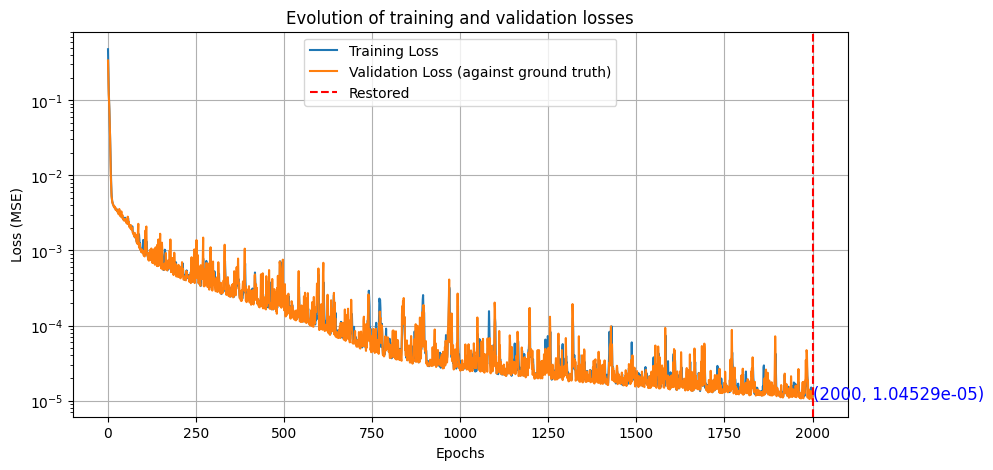

In [21]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 100
start_from_epoch = 200
schedule_tg = 100
metrics = ["mse"]
opt = Adam(learning_rate=1e-3, weight_decay=1e-2)
batch = 32
alpha = 0.5 #physics weight = 1-alpha
#don't think boundary loss is needed when providing the states directly,
# as they serve as x0 -> a hard constraint for initial condition at each time step
joint_training = False
#------

#NN architecture
pinn_model = PinnModel(joint_training=joint_training, car=car)
pinn_model.add(Input(shape=(n_features, )))
for _ in range(0, n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(1, activation="linear")) #output layer -> a^

#Custom PINN loss
loss = CombinedLoss(model=pinn_model, X_c=X_c, scaler_X=scaler_X, scaler_Y=scaler_Y, alpha=alpha)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/pinn_model_forward.h5',
    monitor='val_mse', #track mse loss against true trajectory (not custom loss)
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

class CustomWeightLog(Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        for key, value in self.model.phy_trainable.items():
            logs[key] = value
    def on_train_end(self, logs=None):
        print(f"Custom trainable weights converged to:")
        for key, value in self.loss.train_params.items():
            true_value = self.model.phy_trainable_true[key]
            percentage = abs((value-true_value)/true_value)*100
            print(f"{key} = {value.numpy()}, true value = {true_value} ({percentage}% difference)")

custom_weight_logger = CustomWeightLog()

if joint_training:
    callbacks = [early_stopping, lr_scheduler, checkpoint, custom_weight_logger]
    #callbacks = [lr_scheduler, checkpoint, custom_weight_logger] #removed ES
else:
    callbacks = [early_stopping, lr_scheduler, checkpoint]

#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train_norm,
                                  validation_data=(X_val_norm, Y_val_norm), #validating against true values here, not measurements
                                  batch_size=batch, epochs=epochs,
                                  callbacks=callbacks, verbose=True)
loss_plot(history_pinn_fwd.history, start_from_epoch)

In [22]:
pinn_model.save("models/pinn_model_forward_best.h5")

# PUNN vs PINN

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0455e-05 - mse: 1.2791e-06
Training trajectory (1) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE/RMSE for acceleration: 9.73650e-07, 9.86737e-04
MSE/RMSE for velocity: 1.12460e-04, 1.06047e-02
MSE/RMSE for position: 9.86695e-02, 3.14117e-01
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 3.29554e-08, 1.81536e-04
MSE/RMSE for velocity: 3.68481e-05, 6.07026e-03
MSE/RMSE for position: 8.12843e-01, 9.01578e-01
----


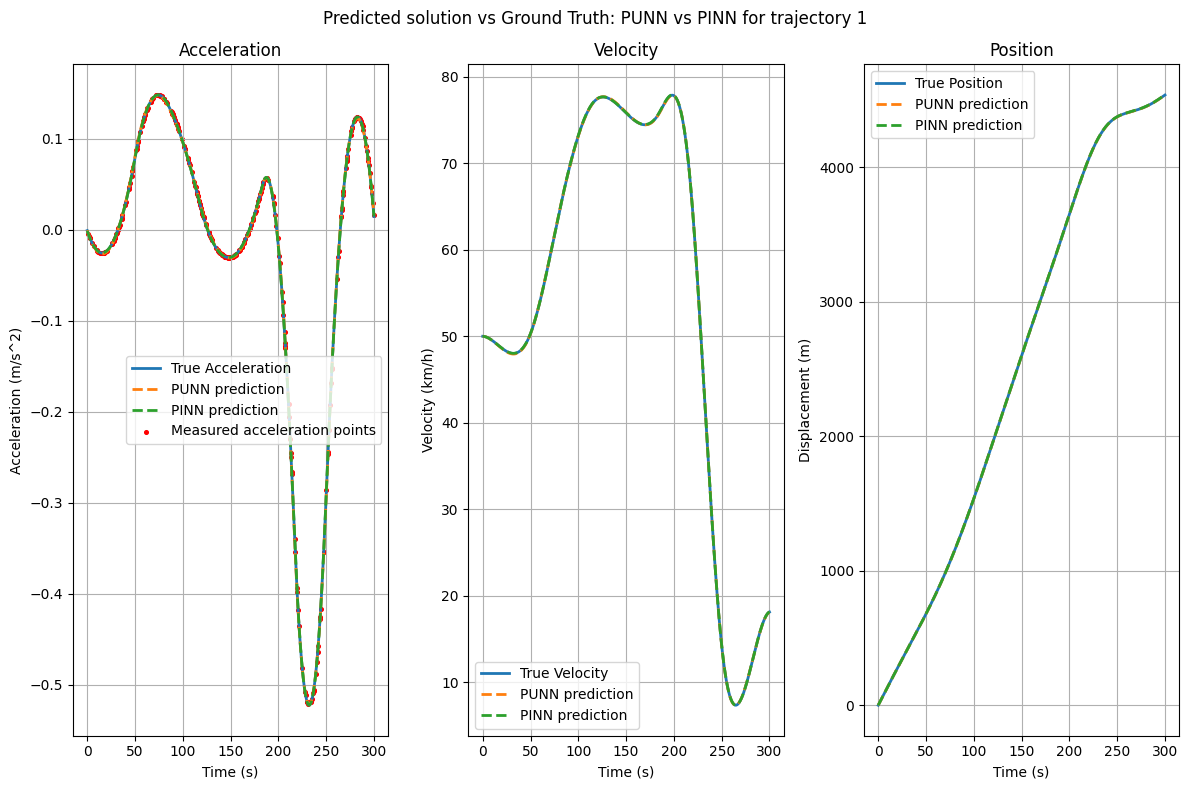

Testing trajectory (0) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 1.17517e-05, 3.42808e-03
MSE/RMSE for velocity: 2.23023e-02, 1.49340e-01
MSE/RMSE for position: 8.78868e+01, 9.37480e+00
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 2.56617e-06, 1.60193e-03
MSE/RMSE for velocity: 5.55294e-02, 2.35647e-01
MSE/RMSE for position: 4.75271e+02, 2.18007e+01
----


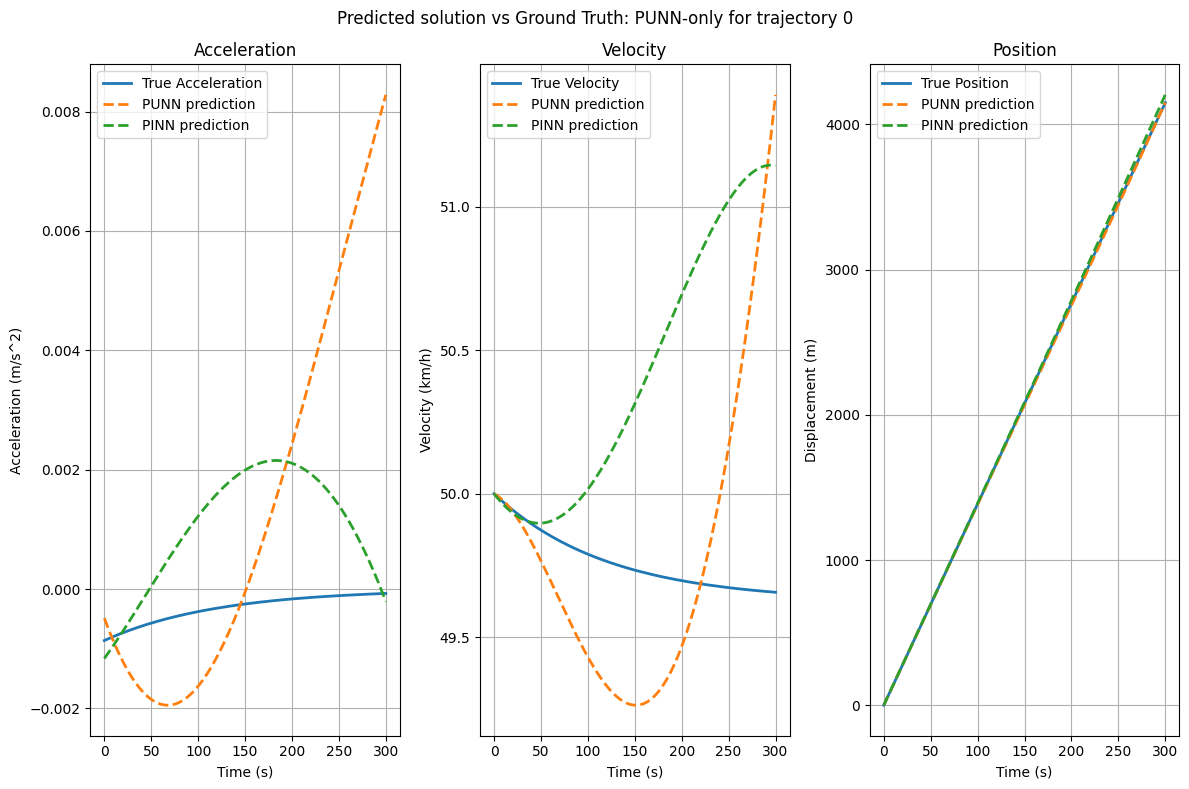

Testing trajectory (2) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE/RMSE for acceleration: 3.77036e-03, 6.14033e-02
MSE/RMSE for velocity: 4.45319e+01, 6.67322e+00
MSE/RMSE for position: 2.22871e+05, 4.72092e+02
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE/RMSE for acceleration: 1.67787e-05, 4.09618e-03
MSE/RMSE for velocity: 5.16287e-02, 2.27220e-01
MSE/RMSE for position: 2.53411e+02, 1.59189e+01
----


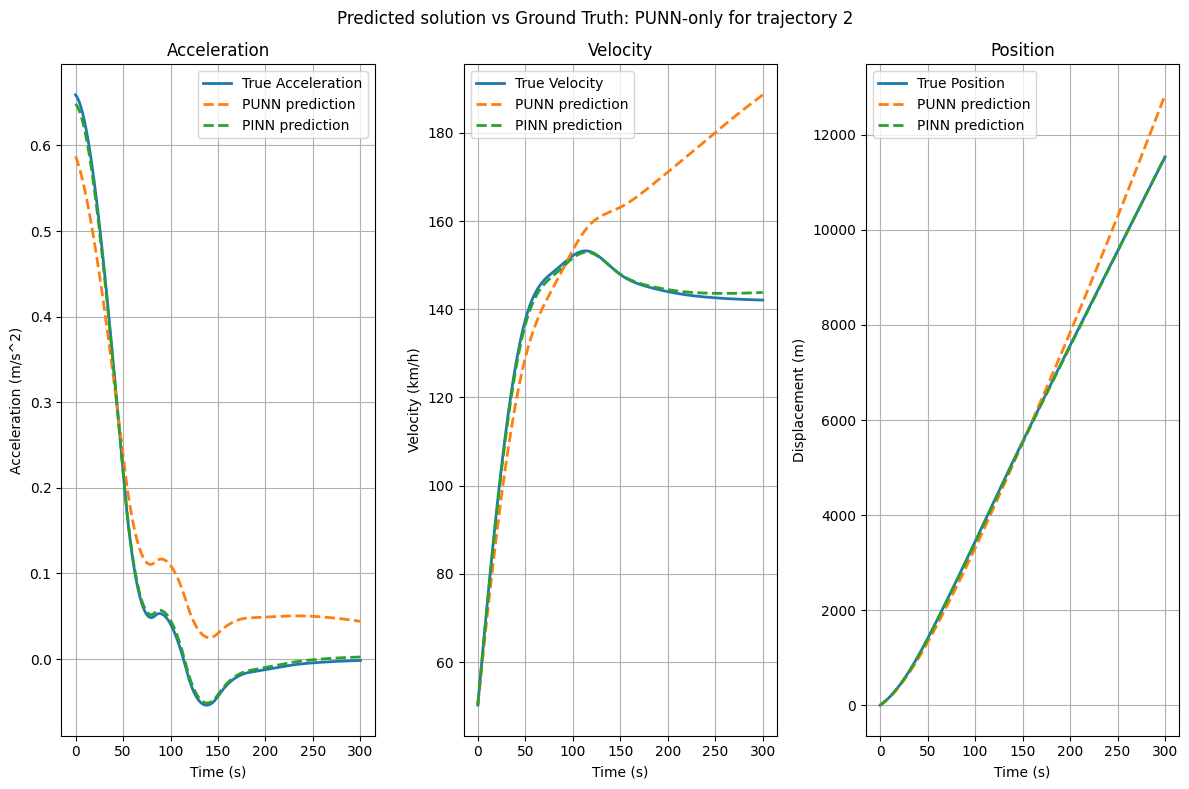

Testing trajectory (3) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE/RMSE for acceleration: 3.38340e-04, 1.83940e-02
MSE/RMSE for velocity: 3.42800e+00, 1.85148e+00
MSE/RMSE for position: 2.04861e+04, 1.43130e+02
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE/RMSE for acceleration: 2.09005e-06, 1.44570e-03
MSE/RMSE for velocity: 9.35270e-03, 9.67093e-02
MSE/RMSE for position: 1.91627e+01, 4.37753e+00
----


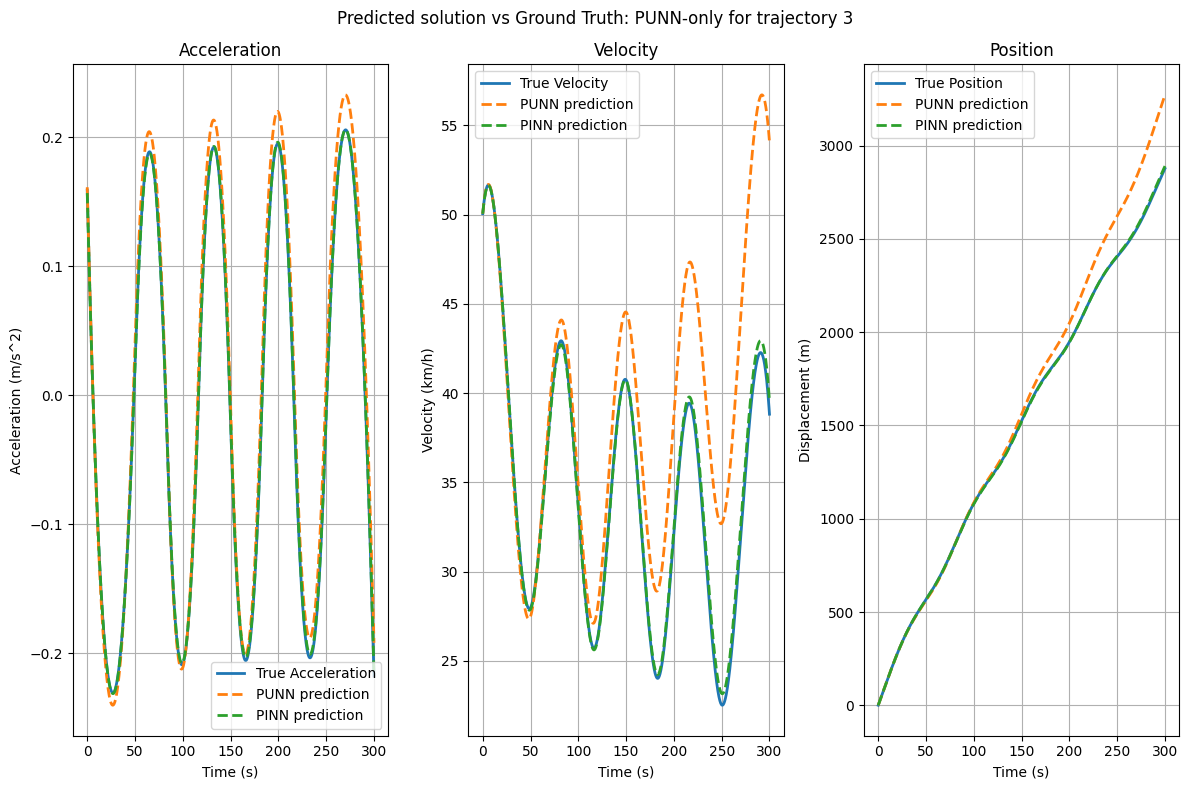

Testing trajectory (4) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE/RMSE for acceleration: 1.24250e-03, 3.52492e-02
MSE/RMSE for velocity: 6.04689e-01, 7.77618e-01
MSE/RMSE for position: 2.13508e+03, 4.62069e+01
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE/RMSE for acceleration: 4.10781e-06, 2.02677e-03
MSE/RMSE for velocity: 4.58219e-03, 6.76919e-02
MSE/RMSE for position: 1.09658e+02, 1.04718e+01
----


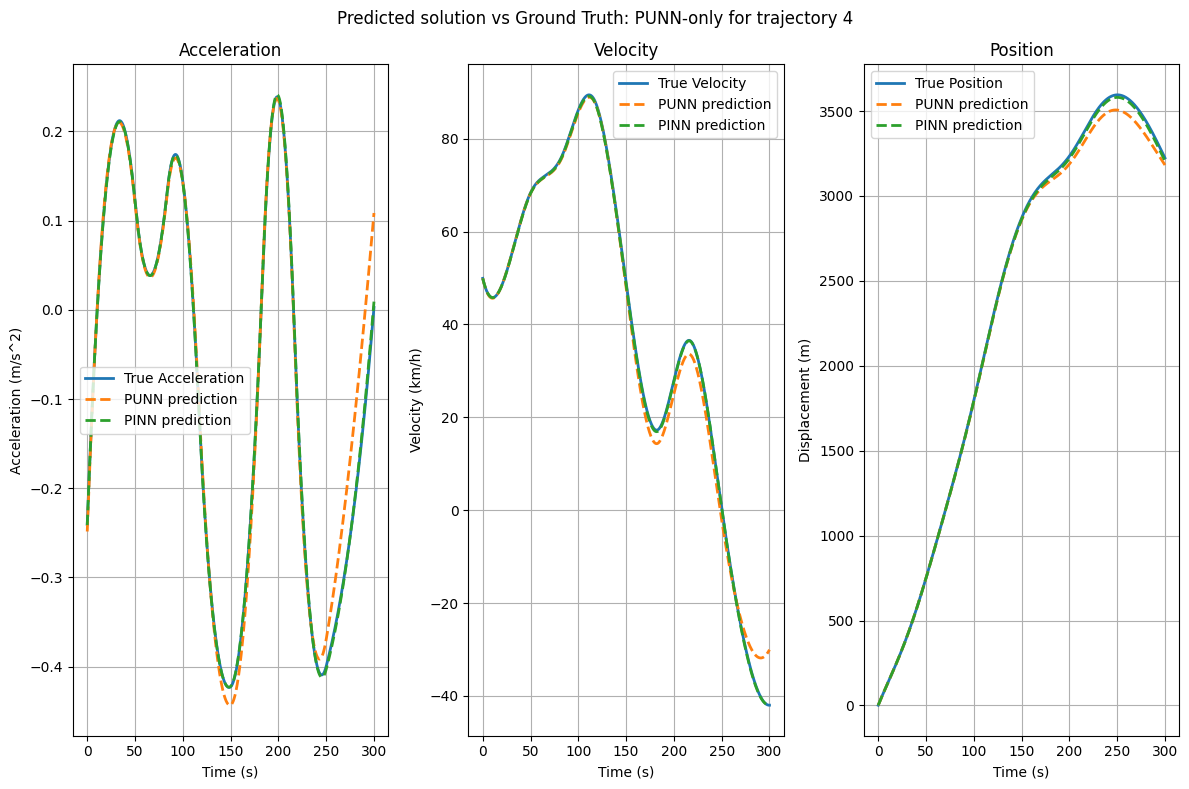

In [42]:
punn_model = load_model("models/punn_model_best.h5", compile=False)  # Load model just for prediction

#Load custom pinn model
''' custom_objects = {"PinnModel": PinnModel}
with custom_object_scope(custom_objects):
    pinn_model = load_model("models/pinn_model_forward_best.h5", compile=False)
print("Converged phy values:", pinn_model.phy_trainable)
 '''

pinn_model.evaluate(x=X_val_norm, y=Y_val_norm, batch_size=batch) #just to confirm final validation loss
# For train trajectory
true_data = df_train_traj[["a_true_next", "v_true_next", "x_true_next"]].to_numpy()
print("Training trajectory (" + str(train_id) + ") statistics: ")
print("PUNN:")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=X_norm, true_data=true_data, scaler_Y=scaler_Y)
print("PINN:")
pinn_train_traj_eval = evaluate_results(model=pinn_model, X_norm=X_norm, true_data=true_data, scaler_Y=scaler_Y)
print("----")
comparison_plot(t=t, true_data=true_data, meas_data=Y_mask,
    pred_data=[(punn_train_traj_eval, "PUNN prediction"), (pinn_train_traj_eval, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + str(train_id)
)

# For other trajectories (test)
for test_id in range(len(input_profiles)):
    if test_id == train_id:
        continue
    df_test_traj = dataset[dataset['traj_id'] == test_id]
    X_test = df_test_traj[["t", "u", "v_true", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N
    X_test_norm = scaler_X.transform(X_test)
    true_data = df_test_traj[["a_true_next", "v_true_next", "x_true_next"]].to_numpy()

    print("Testing trajectory (" + str(test_id) + ") statistics: ")
    print("PUNN:")
    punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=true_data, scaler_Y=scaler_Y)
    print("PINN:")
    pinn_test_traj_eval = evaluate_results(model=pinn_model, X_norm=X_test_norm, true_data=true_data, scaler_Y=scaler_Y)
    print("----")
    comparison_plot(t=t, true_data=true_data, meas_data=None,
        pred_data=[(punn_test_traj_eval, "PUNN prediction"), (pinn_test_traj_eval, "PINN prediction")],
        suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory " + str(test_id)
    )